In [9]:
# importing baseline packages
import os
import warnings
import multiprocessing

from PyQt5.QtGui.QIcon import isNull
# import third party tools
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
import configparser
import torch
import optuna
import shap

# importing data processing packages
import numpy as np
import pandas as pd
import pickle as pk
import sklearn
from docutils.nodes import label
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif

# importing machine learning modelling related packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, confusion_matrix, make_scorer, ndcg_score
import joblib

# importing visualisation libraries & stylesheets
import matplotlib.pyplot as plt

from src.visuals_utility import ColourStyling, custColour, plot_filled_values_percent

plt.style.use('../content/custom_mpl_stylesheet.mplstyle')

# # import custom classes
import utility, logger_setup
import visuals_utility
from visuals_utility import ColourStyling

In [2]:
custColour = ColourStyling()
# function to render colour coded print statements
def beautify(str_to_print: str, format_type: int = 0) -> str:
    if format_type == 0:
        return custColour.mgt + str_to_print + custColour.res
    if format_type == 1:
        return custColour.grn + str_to_print + custColour.res
    if format_type == 2:
        return custColour.gld + str_to_print + custColour.res
    if format_type == 3:
        return custColour.red + str_to_print + custColour.res

In [3]:
warnings.filterwarnings('ignore', category=UserWarning, module='comet_ml')

dict_version = {
    'python': os.popen('python --version').read().strip(),
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'sklearn': sklearn.__version__,
    'xgboost': xgb.__version__
}

for key, value in dict_version.items():
    print(f'{beautify(key, 1)} version is: {beautify(value)}')
    
print(f'Are CUDA cores available to use: {beautify(str(torch.cuda.is_available()))}')
print(f'CPU cores available to use: {beautify(str(multiprocessing.cpu_count()))}')

python version is: Python 3.11.5
numpy version is: 1.26.3
pandas version is: 2.1.4
sklearn version is: 1.2.2
xgboost version is: 2.0.3
Are CUDA cores available to use: True
CPU cores available to use: 16


In [4]:
# instantiate object for custom utility class 
datautil = DataPrepUtil()
# load configs from config.ini file
config = configparser.ConfigParser()
config.read('../conf/config.ini')

['../conf/config.ini']

<div style="background-color:rgba(255, 255, 204, 0.4); font-family:'Arial';">
  <strong>
  The code is reading multiple input dataset CSV files into pandas DataFrames and then creating copies of these DataFrames.
  </strong>
</div>

In [4]:
file_sessions = pd.read_csv('../data/abnb_sessions.csv')
file_train_users = pd.read_csv('../data/abnb_train_users.csv')
file_test_users = pd.read_csv('../data/abnb_test_users.csv')
file_age_gender = pd.read_csv('../data/abnb_age_gender_bkts.csv')
file_countries = pd.read_csv('../data/abnb_countries.csv')

data_sessions_raw = file_sessions.copy()
data_users_train_raw = file_train_users.copy()
data_users_test_raw = file_test_users.copy()
data_demog_raw = file_age_gender.copy()
data_countries_raw =file_countries.copy()

In [6]:
# renaming column names to have consistent nomenclature, identifying target column name
cols_renamed = {}
col_target = ['country_destination']
target_label = 'country_destination'
cols_insignificant = []
var_out_fname = 'submission_01'

In [18]:
data_sessions_raw.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
# This code iterates over all columns in the data_users_train_raw DataFrame. For each column, it prints the column name, its cardinality (the number of unique values), and the first 10 unique values. The printed output is color-coded using the beautify function.
for var in data_sessions_raw.columns:
    print(f'{beautify(var, 1)} having cardinality of {beautify(str(data_sessions_raw[var].nunique()))} and first 10 unique values as:\n {beautify(str(data_sessions_raw[var].unique()[0:10]), 2)}')

user_id having cardinality of 135483 and first 10 unique values as:
 ['d1mm9tcy42' 'yo8nz8bqcq' '4grx6yxeby' 'ncf87guaf0' '4rvqpxoh3h'
 'c8mfesvkv0' 'xwxei6hdk4' '5f45ro5uzk' 'ro2stddszp' 'qtw88d9pbl']
action having cardinality of 359 and first 10 unique values as:
 ['lookup' 'search_results' 'personalize' 'index' 'similar_listings'
 'ajax_refresh_subtotal' 'show' 'header_userpic' 'ask_question' nan]
action_type having cardinality of 10 and first 10 unique values as:
 [nan 'click' 'data' 'view' 'submit' 'message_post' '-unknown-'
 'booking_request' 'partner_callback' 'booking_response']
action_detail having cardinality of 155 and first 10 unique values as:
 [nan 'view_search_results' 'wishlist_content_update' 'similar_listings'
 'change_trip_characteristics' 'p3' 'header_userpic' 'contact_host'
 'message_post' '-unknown-']
device_type having cardinality of 14 and first 10 unique values as:
 ['Windows Desktop' '-unknown-' 'Mac Desktop' 'Android Phone' 'iPhone'
 'iPad Tablet' 'Android Ap

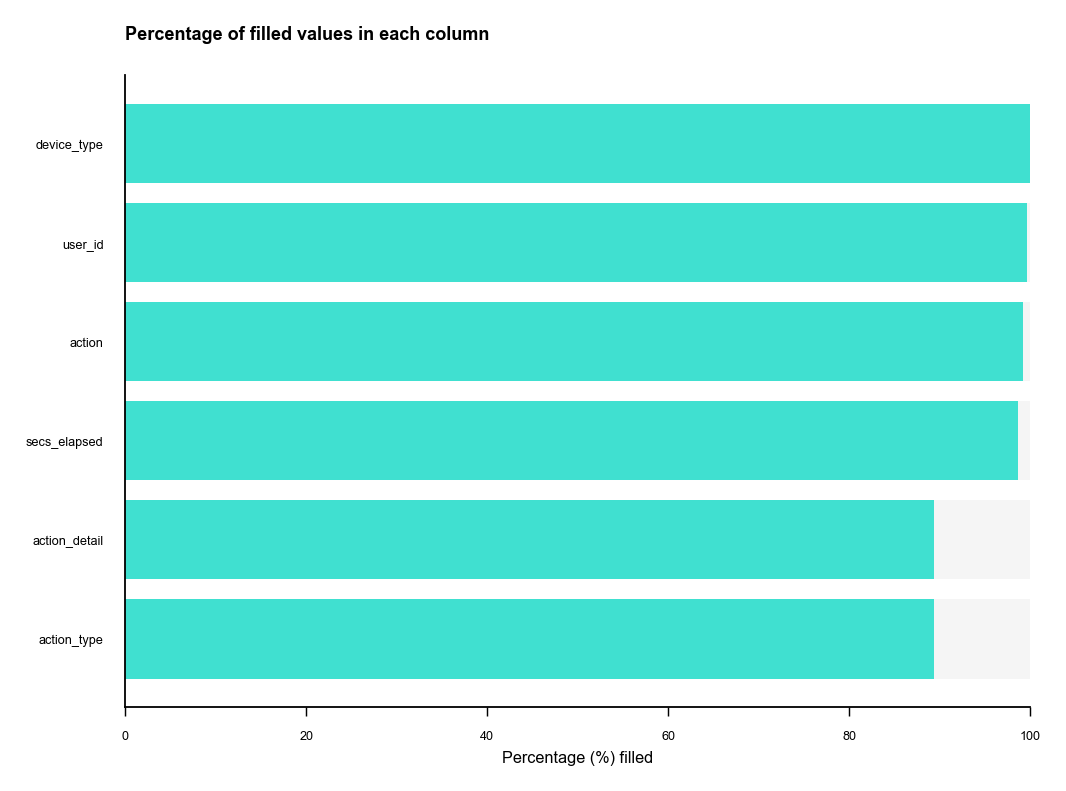

In [11]:
def plot_filled_values_percent(df: pd.DataFrame, color='teal', figsize: tuple = (8, 6), dpi: int = 130):
    filled_values_percent = (df.notnull().sum() / len(df) * 100).sort_values()
    fig, axes = plt.subplots(figsize=figsize, dpi=dpi)
    # Create bars representing total values (set to 100)
    axes.barh(filled_values_percent.index, [100] * len(df.columns), color='#f5f5f5')
    # Create bars representing filled values
    axes.barh(filled_values_percent.index, filled_values_percent, color='turquoise')

    axes.set_xlim([0, 100])
    axes.set_xlabel('Percentage (%) filled')
    axes.set_title('Percentage of filled values in each column')
    plt.show()
    

plot_filled_values_percent(data_sessions_raw)

In [12]:
data_sessions_raw.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [15]:
data_sessions_raw[data_sessions_raw['user_id'].isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed
6715,NaN,calendar_tab_inner2,-unknown-,-unknown-,Mac Desktop,4890.0
6716,NaN,create,submit,create_user,Mac Desktop,NaN
6717,NaN,header_userpic,data,header_userpic,Mac Desktop,768.0
6718,NaN,calendar_tab_inner2,-unknown-,-unknown-,Mac Desktop,7578.0
19921,NaN,edit,view,edit_profile,iPad Tablet,6194.0
...,...,...,...,...,...,...
10556659,NaN,personalize,data,wishlist_content_update,Windows Desktop,919.0
10556660,NaN,search_results,click,view_search_results,Windows Desktop,6683.0
10556661,NaN,search_results,click,view_search_results,Windows Desktop,976.0
10556662,NaN,search_results,click,view_search_results,Windows Desktop,2314.0


In [19]:
data_sessions_raw = data_sessions_raw.rename(columns={'user_id': 'id'})

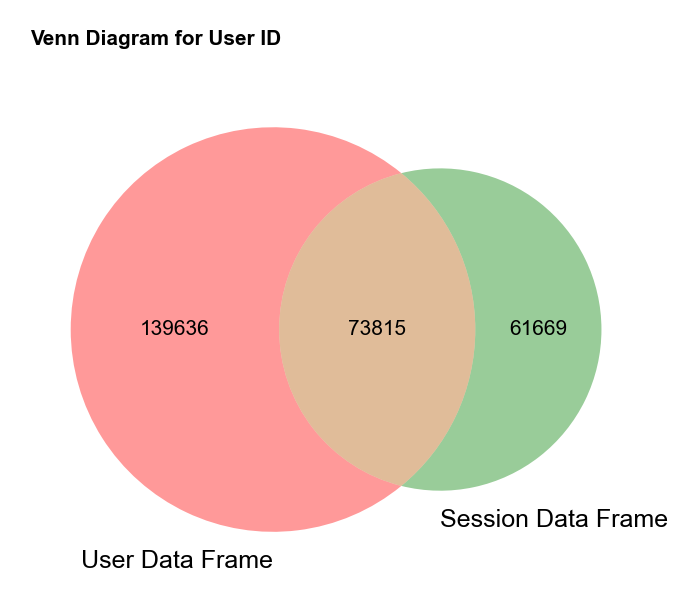

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# def plot_venn_diagram(df1, df1_display_name, df2, df2_display_name, join_column, join_column_display_name):
#     # Convert the joining column to a set for each dataframe
#     set1 = set(df1[join_column])
#     set2 = set(df2[join_column])
#     common_values = set1.intersection(set2)
#     # Create the venn diagram
#     plt.figure(figsize=(8, 6))  # Adjust the figure size if necessary
#     venn = venn2([set1, set2], (df1_display_name, df2_display_name))
# 
#     # Display the plot
#     plt.title(f"Venn Diagram for {join_column_display_name}")
#     plt.show()
#     return list(common_values)

def plot_venn_diagram(df1, df1_display_name, df2, df2_display_name, join_column, join_column_display_name, figsize: tuple = (6, 4), dpi: int = 150):
    # Convert the joining column to a set for each dataframe
    set1 = set(df1[join_column])
    set2 = set(df2[join_column])

    common_values = set1.intersection(set2)
    # Create the venn diagram
    fig, axes = plt.subplots(figsize=figsize, dpi=dpi)
    venn = venn2([set1, set2], (df1_display_name, df2_display_name))

    # Display the plot
    plt.title(f"Venn Diagram for {join_column_display_name}")
    plt.show()
    return list(common_values)

# Example usage
common_ids = plot_venn_diagram(data_users_train_raw, 'User Data Frame', data_sessions_raw, 'Session Data Frame', 'id', 'User ID')


In [29]:
data_users_train_raw[data_users_train_raw['id'].isin(common_ids)]['country_destination'].value_counts()

country_destination
NDF      45041
US       20095
other     3655
FR        1435
IT         979
GB         731
ES         707
CA         440
DE         250
NL         247
AU         152
PT          83
Name: count, dtype: int64

In [8]:
# features to include all but last column, which usually is the target class
cols_raw_features = data_users_train_raw.columns[:-1]
cols_insignificant = ['id', 'date_first_booking']
X_full = pd.concat((data_users_train_raw[cols_raw_features], data_users_test_raw), axis=0, ignore_index=True).copy()

In [9]:
# Do full data wide simple preprocessing 
# Filling nan (age and first_affiliate_tracked)

# Updating age outliers to -1
v_age = X_full.age.values
X_full['age'] = np.where(np.logical_or(v_age<14, v_age>100), -1, v_age)

In [10]:
# exclude test data set
X = X_full[:data_users_train_raw.shape[0]][cols_raw_features]
y = data_users_train_raw[col_target]
X_test = X_full[data_users_train_raw.shape[0]:][cols_raw_features]

In [11]:
# label encode the target variable 
enc_le = LabelEncoder()
tmp_y = y.values
y = enc_le.fit_transform(tmp_y.ravel())

In [12]:
# This code splits the data into training and validation sets, then drops the insignificant columns from the full dataset, training set, validation set, and test set.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=43)

X_full = X_full.drop(cols_insignificant, axis=1)
X_train = X_train.drop(cols_insignificant, axis=1)
X_val = X_val.drop(cols_insignificant, axis=1)
X_test = X_test.drop(cols_insignificant, axis=1)

In [13]:
X_full.shape, X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((275547, 13), (170760, 13), (42691, 13), (62096, 13), (170760,), (42691,))

<div style="background-color:rgba(255, 255, 204, 0.4); font-family:'Arial';">
<strong>
This code sets up a preprocessing pipeline for transforming various data columns before feeding them into a machine learning model. It includes encoding categorical columns, imputing missing values, and transforming date columns. The `ColumnTransformer` composes multiple pipelines to handle different types of transformations for specific columns while leaving the rest unchanged.
</strong>
<br><br>
<ul>
<li>
<strong>OneHotEncoder</strong> is used for categorical variables, with `handle_unknown='ignore'` to manage unseen categories during model fitting.
</li>
<li>
<strong>DateTransformer</strong> is applied to date columns.
</li>
<li>
<strong>SimpleImputer(strategy='most_frequent')</strong> handles missing values by imputing the most frequent value.
</li>
</ul>
The pipelines (`pipe_trans_cat_01`, `pipe_trans_age`, `pipe_trans_fat`, `pipe_trans_date_01`) for different columns are combined into a single `ColumnTransformer` named `ctrans_preproc_01`, which applies the specified transformations to corresponding columns and leaves the rest of the columns untouched (`remainder='passthrough'`).
<br><br>
Various categorical columns (like 'gender', 'signup_method', etc.), the 'age' column, 'first_affiliate_tracked', and 'date_account_created' are specified for appropriate transformations.
</div>



In [14]:
# OHE to encode categorical columns
enc_ohe = OneHotEncoder(handle_unknown='ignore')
# custom transformer to split one date time column into its constituting elements (data, month and year)
trans_date = DateTransformer()
# imputer to replace nulls with the most frequent value
enc_imputer_freq = SimpleImputer(strategy='most_frequent')

# preprocessing pipeline to perform OHE
col_trans_cat_01 = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
             'affiliate_provider', 'signup_app', 'first_device_type', 'first_browser'] 
pipe_trans_cat_01 = Pipeline(
    steps = [
        ('encoding', enc_ohe)
    ]
)

# preprocessing pipeline to perform frequent value imputation
col_age = ['age']
pipe_trans_age = Pipeline(
     steps=[
         ('imputing', enc_imputer_freq)
     ]
)

# preprocessing pipeline to perform imputation first and then OHE
col_fat = ['first_affiliate_tracked']
pipe_trans_fat = Pipeline(
    steps=[
        ('imputing', enc_imputer_freq),
        ('encoding', enc_ohe)
    ]
)

# preprocessing pipeline to perform custom processing (column split)
col_trans_date_01 = ['date_account_created']
pipe_trans_date_01 = Pipeline(
    steps = [
        ('datesplit', trans_date)
    ]
)

# stitching the full pipeline together as a ColumnTransformer
ctrans_preproc_01 = ColumnTransformer(
    transformers=[
        ('tcat_01', pipe_trans_cat_01, col_trans_cat_01),
        ('tage', pipe_trans_age, col_age),
        ('tfat', pipe_trans_fat, col_fat),
        ('tdate_01', pipe_trans_date_01, col_trans_date_01)
    ],
    remainder='passthrough'
)

In [15]:
def ndcg_at_5(y_true, y_pred_proba, k=5):
    # Convert y_true to a binary relevance array
    y_true_binary = np.zeros_like(y_pred_proba)
    y_true_binary[np.arange(len(y_true)), y_true] = 1
    
    # Sort by predicted probabilities
    top_k_indices = np.argsort(y_pred_proba, axis=1)[:, -k:][:, ::-1]
    
    # Compute DCG
    gains = y_true_binary[np.arange(len(y_true))[:, None], top_k_indices]
    discounts = np.log2(np.arange(2, k + 2))
    dcg = np.sum(gains / discounts, axis=1)

    # Compute IDCG
    ideal_gains = np.sort(y_true_binary, axis=1)[:, -k:][:, ::-1]
    idcg = np.sum(ideal_gains / discounts, axis=1)

    # Compute NDCG
    ndcg = np.mean(dcg / (idcg + 1e-10))
    return ndcg

<div style="background-color:rgba(255, 255, 204, 0.4); font-family:'Arial';">
<strong>
This code performs a hyperparameter optimization using Optuna for different classifier models (RandomForestClassifier, KNeighborsClassifier, XGBoostClassifier, and LogisticRegression). It defines an objective function that trains and evaluates these models using cross-validation, and saves the best model configurations in a dictionary (`models`) based on accuracy.
</strong>

Optuna is an automatic hyperparameter optimization framework designed to make hyperparameter tuning easy, efficient, and scalable. It allows you to define an objective function (which you want to optimize) and uses various algorithms to find the best hyperparameters that minimize (or maximize) your objective function.

<ul>
  <li>
  <strong>Objective Function</strong>: This function defines the task you want to optimize. It takes hyperparameters as input and returns a score that describes the performance of your model with those hyperparameters
  </li>
  <li>
  <strong>Study</strong>: A study is an optimization session that includes multiple trials. It manages the trials and stores their results.
  </li>
  <li>
  <strong>Trials</strong>: A trial represents a single execution of the objective function. Each trial suggests a new set of hyperparameters and evaluates the model. The trial object helps in suggesting hyperparameters and keeping track of the trial's results.
  </li>
 <li>
  <strong>Optimize Function</strong>: The optimize function runs the study. It takes the objective function and the number of trials to run. Optuna's optimization algorithms select hyperparameters for each trial, and the objective function is evaluated with those hyperparameters.
  </li>
  <li>
  <strong>Cross Validation</strong>: Cross-validation is often used within the objective function to ensure that the evaluation of the model's performance is reliable and avoids overfitting.
  </li>
</ul>

</div>

In [16]:
%%time

models = {}
study_trials = 400
study_scorer = 'ndcg_at_5'
is_tuning_needed = True
export_version = 'v7.71'
import_version = 'v0.1'

if is_tuning_needed:
    print(f'TUNING IS REQUESTED: Current version = {beautify(str(export_version))}')
    # START of Optuna objective function 
    def objective(trial):
        classifier_models = trial.suggest_categorical('model', ['xgb'])
        print(f'Trial: {trial}')
        print(f'Trial number: {trial.number}')
        
        if classifier_models == 'rfc':
            # n_estimators: Specifies the number of decision trees in the RandomForestClassifier. A larger number of trees can improve model performance by reducing variance, but also increases computation time/complexity.
            rfc_n_estimators = trial.suggest_int('rfc_n_estimators', 50, 300)
            # max_depth: Sets the maximum depth for each decision tree in the RandomForestClassifier. Limiting depth helps prevent overfitting by controlling tree size/complexity, but shallow trees may lead to underfitting.
            rfc_max_depth = trial.suggest_int('rfc_max_depth', 1, 10)
            # criterion: Determines the function to measure the quality of a split in the RandomForestClassifier. Common options are "gini" for the Gini impurity and "entropy" for the information gain.
            rfc_criterion = trial.suggest_categorical('rfc_criterion', ['gini', 'entropy'])
            # min_samples_split: Minimum samples needed to split an internal node in the RandomForestClassifier. Higher values reduce overfitting but may cause underfitting by limiting splits.
            rfc_min_samples_split = trial.suggest_float('rfc_min_samples_split', 0.01, 1.0)
            
            model_rfc = RandomForestClassifier(n_estimators=rfc_n_estimators, max_depth=rfc_max_depth, criterion=rfc_criterion, min_samples_split=rfc_min_samples_split)
            pipe_model = Pipeline(
                steps=[
                    ('preprocessing', ctrans_preproc_01),
                    ('modelling', model_rfc)
                ]
            )
        elif classifier_models == 'knn':
            # n_neighbors: Number of neighbors to consider in KNN. Affects the bias-variance trade-off, influencing model complexity and accuracy.
            knn_n_neighbors = trial.suggest_int('knn_n_neighbors', 1, 5)
            # weights: Determines neighbor influence in KNN. 'Uniform' weights all points equally; 'distance' assigns more weight to closer neighbors. Affects decision boundaries and performance.
            knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
            # p: Determines the power parameter for the Minkowski distance metric in KNN. p=1 uses Manhattan distance, while p=2 uses Euclidean distance.
            knn_p = trial.suggest_int('knn_p', 1, 2)
            
            model_knn = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, p=knn_p)
            pipe_model = Pipeline(
                steps=[
                    ('preprocessing', ctrans_preproc_01),
                    ('modelling', model_knn)
                ]
            )            
        elif classifier_models == 'xgb':
            # n_estimators: Number of boosting rounds in XGBClassifier. More estimators can improve model performance but may increase training time and risk overfitting.
            xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 10, 100)
            # learning_rate: Shrinks the contribution of each boosting round in XGBClassifier. Lower values improve model robustness but require more estimators.
            xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 1e-5, 10)
            # max_depth: Maximum depth of each tree in XGBClassifier. Controls model complexity; deeper trees can capture more patterns but may lead to overfitting.
            xgb_max_depth = trial.suggest_int('xgb_max_depth', 2, 10)
            # subsample: Proportion of training data sampled for each boosting round in XGBClassifier. Prevents overfitting; lower values increase model robustness but may reduce performance.
            xgb_subsample = trial.suggest_float('xgb_subsample', 0.5, 0.9)
            # colsample_bytree: Fraction of features sampled for each tree in XGBClassifier. Controls overfitting; lower values increase model robustness by introducing randomness in feature selection.
            xgb_colsample_bytree = trial.suggest_float('xgb_colsample_bytree', 0.3, 0.9)
            # objective: Defines the learning task and the corresponding loss function in XGBClassifier. Common values include 'binary:logistic' for binary classification and 'multi:softprob' for multi-class classification.
            xgb_objective = trial.suggest_categorical('xgb_objective', ['multi:softprob'])
            
            model_xgb = xgb.XGBClassifier(n_estimators=xgb_n_estimators, learning_rate=xgb_learning_rate, max_depth=xgb_max_depth, subsample=xgb_subsample, colsample_bytree=xgb_colsample_bytree, objective=xgb_objective, device='cuda')
            pipe_model = Pipeline(
                steps=[
                    ('preprocessing', ctrans_preproc_01),
                    ('modelling', model_xgb)
                ]
            )  
        else:
            # C: Inverse of regularization strength in LogisticRegression. Smaller values specify stronger regularization, controlling model complexity to prevent overfitting.
            lr_C = trial.suggest_float('C', 1e-5, 1000)
            # max_iter: Maximum number of iterations for the solver in LogisticRegression. Ensures convergence and model accuracy during training by setting an upper limit on iterations.
            lr_max_iter = trial.suggest_int('max_iter', 10, 1000)
            # fit_intercept: Determines whether to include an intercept term in the LogisticRegression model. True adds an intercept; False assumes data is already centered.
            lr_fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
            
            model_lr = LogisticRegression(C=lr_C, max_iter=lr_max_iter, fit_intercept=lr_fit_intercept)
            pipe_model = Pipeline(
                steps=[
                    ('preprocessing', ctrans_preproc_01),
                    ('modelling', model_lr)
                ]
            )
        print(f'Trial {beautify(str(trial.number))} Scoring Starts...')
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)    

        # Perform cross-validation
        ndcg_scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_vl = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_vl = y_train[train_idx], y_train[val_idx]
            pipe_model.fit(X_tr, y_tr)
            y_vl_pred_proba =  pipe_model.predict_proba(X_vl)
            ndcg_scores.append(ndcg_at_5(y_vl, y_vl_pred_proba, k=5))
        
        scores = ndcg_scores
        score = np.mean(scores)
        # Print the results
        print("NDCG@5 scores:", scores)
        print("Mean NDCG@5 score:", score)
    
        print(f'Trial {beautify(str(trial.number))} Before Saving to Models...')
        models[trial.number] = pipe_model
        print(f'Trial {beautify(str(trial.number))} After Saving to Models...')
        return score
    # END of Optuna objective function
    
    # creation of Optuna study
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=43))
    
    # optimise the study
    study.optimize(objective, n_trials=study_trials)
else:
    print(f'TUNING ISN\'T REQUESTED: Pick previous model pipeline instance(s) from version = {beautify(str(import_version))}')
    model_pipe_prev_best = joblib.load(f'../out/models/model_pipe_{import_version}.pkl')
    model_pipe_prev_knn = joblib.load(f'../out/models/knn_model_pipe_{import_version}.pkl')
    model_pipe_prev_rfc = joblib.load(f'../out/models/rfc_model_pipe_{import_version}.pkl')
    model_pipe_prev_xgb = joblib.load(f'../out/models/xgb_model_pipe_{import_version}.pkl')
    

[I 2024-09-23 19:21:29,492] A new study created in memory with name: no-name-8fb6cdd4-abe0-45d6-bb5b-c3b376db21b8


TUNING IS REQUESTED: Current version = v7.71
Trial: <optuna.trial._trial.Trial object at 0x000001FA912CECD0>
Trial number: 0
Trial 0 Scoring Starts...


D:\softwares\anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2024-09-23 19:21:34,083] Trial 0 finished with value: 0.5146694801933098 and parameters: {'model': 'xgb', 'xgb_n_estimators': 20, 'xgb_learning_rate': 6.090669302129421, 'xgb_max_depth': 3, 'xgb_subsample': 0.5962358479861395, 'xgb_colsample_bytree': 0.4962834334866839, 'xgb_objective': 'multi:softprob'}. Best is trial 0 with value: 0.

NDCG@5 scores: [0.45953919146632805, 0.48981980256164803, 0.459522521185177, 0.4762512849885926, 0.6882146007648037]
Mean NDCG@5 score: 0.5146694801933098
Trial 0 Before Saving to Models...
Trial 0 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA54BBAD0>
Trial number: 1
Trial 1 Scoring Starts...


[I 2024-09-23 19:21:41,923] Trial 1 finished with value: 0.4642128527857551 and parameters: {'model': 'xgb', 'xgb_n_estimators': 88, 'xgb_learning_rate': 6.660905470078126, 'xgb_max_depth': 6, 'xgb_subsample': 0.5116055297697442, 'xgb_colsample_bytree': 0.7402489777681698, 'xgb_objective': 'multi:softprob'}. Best is trial 0 with value: 0.5146694801933098.


NDCG@5 scores: [0.45953919146632805, 0.6558351170370635, 0.459522521185177, 0.2675782175407287, 0.47858921669947807]
Mean NDCG@5 score: 0.4642128527857551
Trial 1 Before Saving to Models...
Trial 1 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FACC291650>
Trial number: 2
Trial 2 Scoring Starts...


[I 2024-09-23 19:21:47,576] Trial 2 finished with value: 0.7033929910299263 and parameters: {'model': 'xgb', 'xgb_n_estimators': 45, 'xgb_learning_rate': 8.02047316581548, 'xgb_max_depth': 4, 'xgb_subsample': 0.5227539746604607, 'xgb_colsample_bytree': 0.8199891845395202, 'xgb_objective': 'multi:softprob'}. Best is trial 2 with value: 0.7033929910299263.


NDCG@5 scores: [0.7612963870096264, 0.6310978536234038, 0.6181636872864883, 0.7612930739622866, 0.7451139532678258]
Mean NDCG@5 score: 0.7033929910299263
Trial 2 Before Saving to Models...
Trial 2 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB22A5C10>
Trial number: 3
Trial 3 Scoring Starts...


[I 2024-09-23 19:21:52,341] Trial 3 finished with value: 0.39594882635164214 and parameters: {'model': 'xgb', 'xgb_n_estimators': 30, 'xgb_learning_rate': 4.049900430578116, 'xgb_max_depth': 4, 'xgb_subsample': 0.5306650799985789, 'xgb_colsample_bytree': 0.8059348165378228, 'xgb_objective': 'multi:softprob'}. Best is trial 2 with value: 0.7033929910299263.


NDCG@5 scores: [0.3336170175769188, 0.45950788075416416, 0.3299873873149852, 0.397098518232002, 0.45953332788014045]
Mean NDCG@5 score: 0.39594882635164214
Trial 3 Before Saving to Models...
Trial 3 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA24B5550>
Trial number: 4
Trial 4 Scoring Starts...


[I 2024-09-23 19:22:00,111] Trial 4 finished with value: 0.5945882324037679 and parameters: {'model': 'xgb', 'xgb_n_estimators': 87, 'xgb_learning_rate': 9.714651199702965, 'xgb_max_depth': 5, 'xgb_subsample': 0.881795250043466, 'xgb_colsample_bytree': 0.5674550165038313, 'xgb_objective': 'multi:softprob'}. Best is trial 2 with value: 0.7033929910299263.


NDCG@5 scores: [0.7612963870096264, 0.5496484586797685, 0.6597139298592571, 0.570603620270308, 0.4316787661998793]
Mean NDCG@5 score: 0.5945882324037679
Trial 4 Before Saving to Models...
Trial 4 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FA912D0390>
Trial number: 5
Trial 5 Scoring Starts...


[I 2024-09-23 19:22:31,529] Trial 5 finished with value: 0.8050792235485378 and parameters: {'model': 'xgb', 'xgb_n_estimators': 70, 'xgb_learning_rate': 0.8250096719710571, 'xgb_max_depth': 10, 'xgb_subsample': 0.6192014002755051, 'xgb_colsample_bytree': 0.4573828935578289, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.8057410147857994, 0.8054873171422495, 0.8053075941852605, 0.8043323214326712, 0.8045278701967088]
Mean NDCG@5 score: 0.8050792235485378
Trial 5 Before Saving to Models...
Trial 5 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4E85F10>
Trial number: 6
Trial 6 Scoring Starts...


[I 2024-09-23 19:22:35,354] Trial 6 finished with value: 0.37086212420810905 and parameters: {'model': 'xgb', 'xgb_n_estimators': 10, 'xgb_learning_rate': 5.432029720778907, 'xgb_max_depth': 6, 'xgb_subsample': 0.7545494710286091, 'xgb_colsample_bytree': 0.8869224804492037, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.4620355380028842, 0.45950788075416416, 0.20385646771940372, 0.2913888349752366, 0.43752189958885657]
Mean NDCG@5 score: 0.37086212420810905
Trial 6 Before Saving to Models...
Trial 6 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC409350>
Trial number: 7
Trial 7 Scoring Starts...


[I 2024-09-23 19:22:43,425] Trial 7 finished with value: 0.6609737062252493 and parameters: {'model': 'xgb', 'xgb_n_estimators': 92, 'xgb_learning_rate': 9.101531656270808, 'xgb_max_depth': 6, 'xgb_subsample': 0.5416075799419051, 'xgb_colsample_bytree': 0.4085487571547406, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.5196480186211593, 0.7612766296453626, 0.5597197860416624, 0.7477186213274246, 0.7165054754906377]
Mean NDCG@5 score: 0.6609737062252493
Trial 7 Before Saving to Models...
Trial 7 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAC26A4450>
Trial number: 8
Trial 8 Scoring Starts...


[I 2024-09-23 19:22:52,413] Trial 8 finished with value: 0.5190701465829614 and parameters: {'model': 'xgb', 'xgb_n_estimators': 96, 'xgb_learning_rate': 4.119535714333752, 'xgb_max_depth': 9, 'xgb_subsample': 0.7688709117904704, 'xgb_colsample_bytree': 0.6772714775292967, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.32978734339633564, 0.352183261406646, 0.41380026791727825, 0.7480174220462013, 0.7515624381483457]
Mean NDCG@5 score: 0.5190701465829614
Trial 8 Before Saving to Models...
Trial 8 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7A20D0>
Trial number: 9
Trial 9 Scoring Starts...


[I 2024-09-23 19:22:57,560] Trial 9 finished with value: 0.5846120710162269 and parameters: {'model': 'xgb', 'xgb_n_estimators': 35, 'xgb_learning_rate': 8.967473729935929, 'xgb_max_depth': 3, 'xgb_subsample': 0.661762097230163, 'xgb_colsample_bytree': 0.8961434954364622, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.7597053432307086, 0.5018528654718822, 0.49849782269234527, 0.550559625646818, 0.6124446980393806]
Mean NDCG@5 score: 0.5846120710162269
Trial 9 Before Saving to Models...
Trial 9 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA5505B50>
Trial number: 10
Trial 10 Scoring Starts...


[I 2024-09-23 19:23:05,202] Trial 10 finished with value: 0.3200805890186314 and parameters: {'model': 'xgb', 'xgb_n_estimators': 76, 'xgb_learning_rate': 4.450619674282701, 'xgb_max_depth': 7, 'xgb_subsample': 0.6645021956346541, 'xgb_colsample_bytree': 0.7361927951807932, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.20068241469496437, 0.4131635881454124, 0.36282039568844726, 0.1953778989536295, 0.4283586476107036]
Mean NDCG@5 score: 0.3200805890186314
Trial 10 Before Saving to Models...
Trial 10 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7A21D0>
Trial number: 11
Trial 11 Scoring Starts...


[I 2024-09-23 19:23:11,149] Trial 11 finished with value: 0.36469194017245554 and parameters: {'model': 'xgb', 'xgb_n_estimators': 46, 'xgb_learning_rate': 6.701454945572171, 'xgb_max_depth': 8, 'xgb_subsample': 0.7438239485036183, 'xgb_colsample_bytree': 0.6240206785089937, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.3976503265333004, 0.4523717471166195, 0.2893965062638474, 0.2555306076220671, 0.4285105133264434]
Mean NDCG@5 score: 0.36469194017245554
Trial 11 Before Saving to Models...
Trial 11 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA547F250>
Trial number: 12
Trial 12 Scoring Starts...


[I 2024-09-23 19:23:16,922] Trial 12 finished with value: 0.6077858767112734 and parameters: {'model': 'xgb', 'xgb_n_estimators': 28, 'xgb_learning_rate': 1.9916227746122528, 'xgb_max_depth': 9, 'xgb_subsample': 0.6161331111083026, 'xgb_colsample_bytree': 0.6935776966943124, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.5781703562538081, 0.7612766296453626, 0.5625323727906981, 0.5842123372628321, 0.5527376876036659]
Mean NDCG@5 score: 0.6077858767112734
Trial 12 Before Saving to Models...
Trial 12 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB22A5790>
Trial number: 13
Trial 13 Scoring Starts...


[I 2024-09-23 19:23:23,602] Trial 13 finished with value: 0.6446949019969813 and parameters: {'model': 'xgb', 'xgb_n_estimators': 37, 'xgb_learning_rate': 1.4447923394445032, 'xgb_max_depth': 5, 'xgb_subsample': 0.6241078107378359, 'xgb_colsample_bytree': 0.44603880976857735, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.8152071701903807, 0.557017724344194, 0.7612892402262372, 0.32864882709474585, 0.7613115481293488]
Mean NDCG@5 score: 0.6446949019969813
Trial 13 Before Saving to Models...
Trial 13 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7B3E90>
Trial number: 14
Trial 14 Scoring Starts...


[I 2024-09-23 19:23:30,913] Trial 14 finished with value: 0.7398197896257173 and parameters: {'model': 'xgb', 'xgb_n_estimators': 63, 'xgb_learning_rate': 2.4534400762010686, 'xgb_max_depth': 8, 'xgb_subsample': 0.7880586591416892, 'xgb_colsample_bytree': 0.7171565201730559, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.7553916359054215, 0.6614518016698879, 0.7612892402262372, 0.7612930739622866, 0.759673196364753]
Mean NDCG@5 score: 0.7398197896257173
Trial 14 Before Saving to Models...
Trial 14 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7B1B90>
Trial number: 15
Trial 15 Scoring Starts...


[I 2024-09-23 19:23:35,350] Trial 15 finished with value: 0.545837075875441 and parameters: {'model': 'xgb', 'xgb_n_estimators': 19, 'xgb_learning_rate': 9.43642484541863, 'xgb_max_depth': 6, 'xgb_subsample': 0.859869447746965, 'xgb_colsample_bytree': 0.41914793066178835, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.7612963870096264, 0.38548503312421944, 0.748447943884567, 0.48335128357957724, 0.350604731779215]
Mean NDCG@5 score: 0.545837075875441
Trial 15 Before Saving to Models...
Trial 15 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC82AF90>
Trial number: 16
Trial 16 Scoring Starts...


[I 2024-09-23 19:23:42,528] Trial 16 finished with value: 0.3444404239459134 and parameters: {'model': 'xgb', 'xgb_n_estimators': 64, 'xgb_learning_rate': 9.654086162686816, 'xgb_max_depth': 10, 'xgb_subsample': 0.5096674499922178, 'xgb_colsample_bytree': 0.58878200007319, 'xgb_objective': 'multi:softprob'}. Best is trial 5 with value: 0.8050792235485378.


NDCG@5 scores: [0.2012213784400106, 0.490004373941011, 0.35689218268322365, 0.23976228102814284, 0.43432190363717893]
Mean NDCG@5 score: 0.3444404239459134
Trial 16 Before Saving to Models...
Trial 16 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FA912976D0>
Trial number: 17
Trial 17 Scoring Starts...


[I 2024-09-23 19:23:53,765] Trial 17 finished with value: 0.8191733075792499 and parameters: {'model': 'xgb', 'xgb_n_estimators': 36, 'xgb_learning_rate': 0.6372150459674623, 'xgb_max_depth': 7, 'xgb_subsample': 0.5020333138796856, 'xgb_colsample_bytree': 0.6667665538020131, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.8182360968264292, 0.8193424648265895, 0.8205893497460479, 0.8183972542646653, 0.8193013722325169]
Mean NDCG@5 score: 0.8191733075792499
Trial 17 Before Saving to Models...
Trial 17 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA2782A50>
Trial number: 18
Trial 18 Scoring Starts...


[I 2024-09-23 19:24:02,283] Trial 18 finished with value: 0.4243684923129213 and parameters: {'model': 'xgb', 'xgb_n_estimators': 89, 'xgb_learning_rate': 8.836015813724243, 'xgb_max_depth': 10, 'xgb_subsample': 0.7959455279213896, 'xgb_colsample_bytree': 0.4108277745294533, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.45953919146632805, 0.45950788075416416, 0.3727240637505906, 0.3705379977133831, 0.45953332788014045]
Mean NDCG@5 score: 0.4243684923129213
Trial 18 Before Saving to Models...
Trial 18 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7A27D0>
Trial number: 19
Trial 19 Scoring Starts...


[I 2024-09-23 19:24:08,325] Trial 19 finished with value: 0.6973002403345596 and parameters: {'model': 'xgb', 'xgb_n_estimators': 49, 'xgb_learning_rate': 8.858996096483779, 'xgb_max_depth': 4, 'xgb_subsample': 0.6773250778915936, 'xgb_colsample_bytree': 0.6701621854925371, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.6584459237554736, 0.7612766296453626, 0.6944977728979677, 0.6649479205875536, 0.7073329547864404]
Mean NDCG@5 score: 0.6973002403345596
Trial 19 Before Saving to Models...
Trial 19 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FA91200190>
Trial number: 20
Trial 20 Scoring Starts...


[I 2024-09-23 19:24:12,552] Trial 20 finished with value: 0.4662686342179138 and parameters: {'model': 'xgb', 'xgb_n_estimators': 19, 'xgb_learning_rate': 4.901101709594014, 'xgb_max_depth': 2, 'xgb_subsample': 0.6246509877236603, 'xgb_colsample_bytree': 0.7512238118196151, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.45953919146632805, 0.5699243534034905, 0.47536513600158997, 0.2012380259976784, 0.6252764642204823]
Mean NDCG@5 score: 0.4662686342179138
Trial 20 Before Saving to Models...
Trial 20 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC829650>
Trial number: 21
Trial 21 Scoring Starts...


[I 2024-09-23 19:24:20,184] Trial 21 finished with value: 0.44640007252229597 and parameters: {'model': 'xgb', 'xgb_n_estimators': 75, 'xgb_learning_rate': 9.415543022040731, 'xgb_max_depth': 8, 'xgb_subsample': 0.5860914059948745, 'xgb_colsample_bytree': 0.8429827083799504, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.4839160159146314, 0.5387631546178323, 0.4571323816138773, 0.27321480887568145, 0.47897400158945747]
Mean NDCG@5 score: 0.44640007252229597
Trial 21 Before Saving to Models...
Trial 21 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7D6AD0>
Trial number: 22
Trial 22 Scoring Starts...


[I 2024-09-23 19:24:27,139] Trial 22 finished with value: 0.3531986706125909 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 8.448980426789687, 'xgb_max_depth': 10, 'xgb_subsample': 0.8315845115756568, 'xgb_colsample_bytree': 0.5365187987758357, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.27576308742271227, 0.47342690386708364, 0.3353825101064674, 0.24236208586462904, 0.4390587658020621]
Mean NDCG@5 score: 0.3531986706125909
Trial 22 Before Saving to Models...
Trial 22 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC84B810>
Trial number: 23
Trial 23 Scoring Starts...


[I 2024-09-23 19:24:34,075] Trial 23 finished with value: 0.4033374535990573 and parameters: {'model': 'xgb', 'xgb_n_estimators': 64, 'xgb_learning_rate': 4.326986468655206, 'xgb_max_depth': 8, 'xgb_subsample': 0.6938745958414506, 'xgb_colsample_bytree': 0.37695620494564397, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.4524895888530226, 0.43887592308837237, 0.4518127468433202, 0.2776587453227232, 0.395850263887848]
Mean NDCG@5 score: 0.4033374535990573
Trial 23 Before Saving to Models...
Trial 23 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC795C10>
Trial number: 24
Trial 24 Scoring Starts...


[I 2024-09-23 19:24:41,566] Trial 24 finished with value: 0.6930592419995578 and parameters: {'model': 'xgb', 'xgb_n_estimators': 68, 'xgb_learning_rate': 2.0470701146443906, 'xgb_max_depth': 8, 'xgb_subsample': 0.542246882561033, 'xgb_colsample_bytree': 0.30438569623435485, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.7588641490476217, 0.7588132955339468, 0.735126104811334, 0.6010221878069266, 0.61147047279796]
Mean NDCG@5 score: 0.6930592419995578
Trial 24 Before Saving to Models...
Trial 24 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F5A390>
Trial number: 25
Trial 25 Scoring Starts...


[I 2024-09-23 19:24:47,166] Trial 25 finished with value: 0.5560513739945205 and parameters: {'model': 'xgb', 'xgb_n_estimators': 40, 'xgb_learning_rate': 9.69255534575552, 'xgb_max_depth': 8, 'xgb_subsample': 0.6654742138933345, 'xgb_colsample_bytree': 0.3724513023094725, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.6531837410060876, 0.7490351994685027, 0.459522521185177, 0.4589820804326951, 0.45953332788014045]
Mean NDCG@5 score: 0.5560513739945205
Trial 25 Before Saving to Models...
Trial 25 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F64810>
Trial number: 26
Trial 26 Scoring Starts...


[I 2024-09-23 19:24:51,556] Trial 26 finished with value: 0.3608982987896404 and parameters: {'model': 'xgb', 'xgb_n_estimators': 15, 'xgb_learning_rate': 7.262119475491013, 'xgb_max_depth': 10, 'xgb_subsample': 0.5064103671728476, 'xgb_colsample_bytree': 0.6504844984281521, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.19860606146270984, 0.4446838049772465, 0.3544865978750527, 0.3501699475107727, 0.4565450821224201]
Mean NDCG@5 score: 0.3608982987896404
Trial 26 Before Saving to Models...
Trial 26 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F66350>
Trial number: 27
Trial 27 Scoring Starts...


[I 2024-09-23 19:24:59,207] Trial 27 finished with value: 0.6278479723031607 and parameters: {'model': 'xgb', 'xgb_n_estimators': 76, 'xgb_learning_rate': 2.9219825207846393, 'xgb_max_depth': 6, 'xgb_subsample': 0.8259407545002471, 'xgb_colsample_bytree': 0.6577961881061194, 'xgb_objective': 'multi:softprob'}. Best is trial 17 with value: 0.8191733075792499.


NDCG@5 scores: [0.5497859011060723, 0.549765397088872, 0.5497800375198848, 0.7612930739622866, 0.7286154518386877]
Mean NDCG@5 score: 0.6278479723031607
Trial 27 Before Saving to Models...
Trial 27 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FA912972D0>
Trial number: 28
Trial 28 Scoring Starts...


[I 2024-09-23 19:25:10,148] Trial 28 finished with value: 0.8210932278221408 and parameters: {'model': 'xgb', 'xgb_n_estimators': 44, 'xgb_learning_rate': 0.7755872793716544, 'xgb_max_depth': 6, 'xgb_subsample': 0.6872775624279701, 'xgb_colsample_bytree': 0.40892085403761036, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.8202538541058445, 0.8210320506464867, 0.822128729896984, 0.8205853655724222, 0.8214661388889674]
Mean NDCG@5 score: 0.8210932278221408
Trial 28 Before Saving to Models...
Trial 28 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7C6B10>
Trial number: 29
Trial 29 Scoring Starts...


[I 2024-09-23 19:25:14,258] Trial 29 finished with value: 0.47867825398117764 and parameters: {'model': 'xgb', 'xgb_n_estimators': 16, 'xgb_learning_rate': 5.084014237454743, 'xgb_max_depth': 4, 'xgb_subsample': 0.5857991281387658, 'xgb_colsample_bytree': 0.35679413652866176, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.3011850459113865, 0.40267302547986356, 0.7612892402262372, 0.2012380259976784, 0.7270059322907225]
Mean NDCG@5 score: 0.47867825398117764
Trial 29 Before Saving to Models...
Trial 29 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4D04ED0>
Trial number: 30
Trial 30 Scoring Starts...


[I 2024-09-23 19:25:22,504] Trial 30 finished with value: 0.4620437912102332 and parameters: {'model': 'xgb', 'xgb_n_estimators': 86, 'xgb_learning_rate': 3.5511311528829403, 'xgb_max_depth': 9, 'xgb_subsample': 0.510384907692778, 'xgb_colsample_bytree': 0.3013437462920118, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.16994150506874187, 0.3997072806407344, 0.42950786555448167, 0.7612930739622866, 0.5497692308249212]
Mean NDCG@5 score: 0.4620437912102332
Trial 30 Before Saving to Models...
Trial 30 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F527D0>
Trial number: 31
Trial 31 Scoring Starts...


[I 2024-09-23 19:25:31,335] Trial 31 finished with value: 0.3896275942208038 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 6.739335770743708, 'xgb_max_depth': 10, 'xgb_subsample': 0.6918020085762672, 'xgb_colsample_bytree': 0.3954824979323888, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.39905580791053163, 0.460253542706642, 0.4361387962710957, 0.270265437074041, 0.3824243871417088]
Mean NDCG@5 score: 0.3896275942208038
Trial 31 Before Saving to Models...
Trial 31 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4956810>
Trial number: 32
Trial 32 Scoring Starts...


[I 2024-09-23 19:25:40,239] Trial 32 finished with value: 0.6296192872792619 and parameters: {'model': 'xgb', 'xgb_n_estimators': 96, 'xgb_learning_rate': 1.6607100747432328, 'xgb_max_depth': 5, 'xgb_subsample': 0.8738239935481099, 'xgb_colsample_bytree': 0.3489846817350886, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.5102319514128865, 0.5647255527573323, 0.751130456520271, 0.5607154017435328, 0.7612930739622866]
Mean NDCG@5 score: 0.6296192872792619
Trial 32 Before Saving to Models...
Trial 32 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4EA3090>
Trial number: 33
Trial 33 Scoring Starts...


[I 2024-09-23 19:25:46,340] Trial 33 finished with value: 0.45503880890112497 and parameters: {'model': 'xgb', 'xgb_n_estimators': 51, 'xgb_learning_rate': 8.872907043699117, 'xgb_max_depth': 4, 'xgb_subsample': 0.8850631750862845, 'xgb_colsample_bytree': 0.8984235602090931, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.5166172201686535, 0.35900424127507496, 0.459522521185177, 0.45981239380354394, 0.48023766807317564]
Mean NDCG@5 score: 0.45503880890112497
Trial 33 Before Saving to Models...
Trial 33 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4F8A090>
Trial number: 34
Trial 34 Scoring Starts...


[I 2024-09-23 19:25:53,312] Trial 34 finished with value: 0.5247491137576112 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 3.2129226714242476, 'xgb_max_depth': 10, 'xgb_subsample': 0.8994874145235543, 'xgb_colsample_bytree': 0.5671278600793463, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.7612963870096264, 0.32547371796091007, 0.5497800375198848, 0.24904406709718682, 0.7381513592004483]
Mean NDCG@5 score: 0.5247491137576112
Trial 34 Before Saving to Models...
Trial 34 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7C5650>
Trial number: 35
Trial 35 Scoring Starts...


[I 2024-09-23 19:25:57,519] Trial 35 finished with value: 0.33604952029651936 and parameters: {'model': 'xgb', 'xgb_n_estimators': 14, 'xgb_learning_rate': 4.470616764362898, 'xgb_max_depth': 8, 'xgb_subsample': 0.7504285310520169, 'xgb_colsample_bytree': 0.7023898621267505, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.2979464298159207, 0.350755555452382, 0.35555012317256623, 0.2651093828881579, 0.41088611015356985]
Mean NDCG@5 score: 0.33604952029651936
Trial 35 Before Saving to Models...
Trial 35 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA5475410>
Trial number: 36
Trial 36 Scoring Starts...


[I 2024-09-23 19:26:06,110] Trial 36 finished with value: 0.5516413811277711 and parameters: {'model': 'xgb', 'xgb_n_estimators': 98, 'xgb_learning_rate': 6.619715789145949, 'xgb_max_depth': 2, 'xgb_subsample': 0.7358924040838511, 'xgb_colsample_bytree': 0.42694860384376054, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.5497859011060723, 0.549765397088872, 0.459522521185177, 0.4378400122964473, 0.7612930739622866]
Mean NDCG@5 score: 0.5516413811277711
Trial 36 Before Saving to Models...
Trial 36 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB4EE6110>
Trial number: 37
Trial 37 Scoring Starts...


[I 2024-09-23 19:26:13,926] Trial 37 finished with value: 0.4659634312029704 and parameters: {'model': 'xgb', 'xgb_n_estimators': 82, 'xgb_learning_rate': 3.5030663192187026, 'xgb_max_depth': 6, 'xgb_subsample': 0.7814156584526368, 'xgb_colsample_bytree': 0.4029766055507631, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.39400371257812306, 0.3829843704864872, 0.4114930575275074, 0.7575621457940697, 0.38377386962866444]
Mean NDCG@5 score: 0.4659634312029704
Trial 37 Before Saving to Models...
Trial 37 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC84B750>
Trial number: 38
Trial 38 Scoring Starts...


[I 2024-09-23 19:26:24,508] Trial 38 finished with value: 0.6134567083219037 and parameters: {'model': 'xgb', 'xgb_n_estimators': 64, 'xgb_learning_rate': 1.600354507044476, 'xgb_max_depth': 9, 'xgb_subsample': 0.6330806513970073, 'xgb_colsample_bytree': 0.6280183119699558, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.713892503407073, 0.6770131633191164, 0.2886764111727545, 0.6893518624953259, 0.6983496012152485]
Mean NDCG@5 score: 0.6134567083219037
Trial 38 Before Saving to Models...
Trial 38 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F664D0>
Trial number: 39
Trial 39 Scoring Starts...


[I 2024-09-23 19:26:32,547] Trial 39 finished with value: 0.5286098701022114 and parameters: {'model': 'xgb', 'xgb_n_estimators': 85, 'xgb_learning_rate': 9.690670930727114, 'xgb_max_depth': 4, 'xgb_subsample': 0.5353495278446824, 'xgb_colsample_bytree': 0.8780934742677484, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.5507929815236554, 0.6381705027331884, 0.6934861676161644, 0.45953332788014045, 0.3010663707579085]
Mean NDCG@5 score: 0.5286098701022114
Trial 39 Before Saving to Models...
Trial 39 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA48C4150>
Trial number: 40
Trial 40 Scoring Starts...


[I 2024-09-23 19:26:41,692] Trial 40 finished with value: 0.37878394210931965 and parameters: {'model': 'xgb', 'xgb_n_estimators': 100, 'xgb_learning_rate': 9.190771679789082, 'xgb_max_depth': 9, 'xgb_subsample': 0.6974770970113576, 'xgb_colsample_bytree': 0.5811699348765509, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.39677190067253093, 0.47263801513475207, 0.3307400796559241, 0.2612196602031521, 0.43255005488023907]
Mean NDCG@5 score: 0.37878394210931965
Trial 40 Before Saving to Models...
Trial 40 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB82FEA10>
Trial number: 41
Trial 41 Scoring Starts...


[I 2024-09-23 19:27:12,576] Trial 41 finished with value: 0.7738914634496885 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 1.0690309797826312, 'xgb_max_depth': 10, 'xgb_subsample': 0.7460588829954289, 'xgb_colsample_bytree': 0.8952274886454838, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.7659976213356005, 0.7894601389953844, 0.7872041790459315, 0.7923555682378434, 0.734439809633683]
Mean NDCG@5 score: 0.7738914634496885
Trial 41 Before Saving to Models...
Trial 41 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC84BF90>
Trial number: 42
Trial 42 Scoring Starts...


[I 2024-09-23 19:27:19,840] Trial 42 finished with value: 0.46093053973424664 and parameters: {'model': 'xgb', 'xgb_n_estimators': 73, 'xgb_learning_rate': 3.5473549706176057, 'xgb_max_depth': 3, 'xgb_subsample': 0.5184672230834283, 'xgb_colsample_bytree': 0.49607382301486946, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.5038802368377547, 0.3997072806407344, 0.19697279078400148, 0.7612930739622866, 0.4427993164464561]
Mean NDCG@5 score: 0.46093053973424664
Trial 42 Before Saving to Models...
Trial 42 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7AB050>
Trial number: 43
Trial 43 Scoring Starts...


[I 2024-09-23 19:27:25,507] Trial 43 finished with value: 0.3499544321178673 and parameters: {'model': 'xgb', 'xgb_n_estimators': 42, 'xgb_learning_rate': 4.793877307045848, 'xgb_max_depth': 7, 'xgb_subsample': 0.5343768847000248, 'xgb_colsample_bytree': 0.47786736711095645, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.32291100103419934, 0.45950788075416416, 0.17825426593701757, 0.3560080629962269, 0.4330909498677286]
Mean NDCG@5 score: 0.3499544321178673
Trial 43 Before Saving to Models...
Trial 43 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC84BAD0>
Trial number: 44
Trial 44 Scoring Starts...


[I 2024-09-23 19:27:30,385] Trial 44 finished with value: 0.497155657452932 and parameters: {'model': 'xgb', 'xgb_n_estimators': 28, 'xgb_learning_rate': 6.521600850932227, 'xgb_max_depth': 7, 'xgb_subsample': 0.7727208545660773, 'xgb_colsample_bytree': 0.43015798273312256, 'xgb_objective': 'multi:softprob'}. Best is trial 28 with value: 0.8210932278221408.


NDCG@5 scores: [0.45953919146632805, 0.7386941866386578, 0.459522521185177, 0.36848906009435645, 0.45953332788014045]
Mean NDCG@5 score: 0.497155657452932
Trial 44 Before Saving to Models...
Trial 44 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC84BAD0>
Trial number: 45
Trial 45 Scoring Starts...


[I 2024-09-23 19:27:35,707] Trial 45 finished with value: 0.8244765149548442 and parameters: {'model': 'xgb', 'xgb_n_estimators': 12, 'xgb_learning_rate': 0.3897513494058552, 'xgb_max_depth': 6, 'xgb_subsample': 0.851044039024317, 'xgb_colsample_bytree': 0.6234943115301047, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.823840071606436, 0.8244104684455628, 0.8257488928525102, 0.8240077150666154, 0.8243754268030972]
Mean NDCG@5 score: 0.8244765149548442
Trial 45 Before Saving to Models...
Trial 45 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC84BAD0>
Trial number: 46
Trial 46 Scoring Starts...


[I 2024-09-23 19:27:42,309] Trial 46 finished with value: 0.43483048791066403 and parameters: {'model': 'xgb', 'xgb_n_estimators': 57, 'xgb_learning_rate': 5.44226731482609, 'xgb_max_depth': 6, 'xgb_subsample': 0.8545409438094627, 'xgb_colsample_bytree': 0.5461166391399038, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.1908466330259126, 0.6993059751883662, 0.201234192261629, 0.3623179869879635, 0.7204476520894487]
Mean NDCG@5 score: 0.43483048791066403
Trial 46 Before Saving to Models...
Trial 46 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB82FE810>
Trial number: 47
Trial 47 Scoring Starts...


[I 2024-09-23 19:27:50,364] Trial 47 finished with value: 0.4924147127408848 and parameters: {'model': 'xgb', 'xgb_n_estimators': 84, 'xgb_learning_rate': 8.322171721459576, 'xgb_max_depth': 7, 'xgb_subsample': 0.5793666714942919, 'xgb_colsample_bytree': 0.7651825674674639, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.4711311376649684, 0.6965181592394192, 0.459522521185177, 0.3753684177347188, 0.45953332788014045]
Mean NDCG@5 score: 0.4924147127408848
Trial 47 Before Saving to Models...
Trial 47 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F642D0>
Trial number: 48
Trial 48 Scoring Starts...


[I 2024-09-23 19:27:55,598] Trial 48 finished with value: 0.8238236232002901 and parameters: {'model': 'xgb', 'xgb_n_estimators': 10, 'xgb_learning_rate': 0.527472907870757, 'xgb_max_depth': 7, 'xgb_subsample': 0.6007893795392799, 'xgb_colsample_bytree': 0.4585031624304472, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8224361488204878, 0.8241081960606341, 0.8246494960702462, 0.822953730406945, 0.8249705446431372]
Mean NDCG@5 score: 0.8238236232002901
Trial 48 Before Saving to Models...
Trial 48 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA5506D50>
Trial number: 49
Trial 49 Scoring Starts...


[I 2024-09-23 19:27:59,778] Trial 49 finished with value: 0.4450311966011832 and parameters: {'model': 'xgb', 'xgb_n_estimators': 14, 'xgb_learning_rate': 8.968209699841422, 'xgb_max_depth': 7, 'xgb_subsample': 0.5094408772737484, 'xgb_colsample_bytree': 0.6435926265288001, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.449630015339944, 0.6330474902184163, 0.201234192261629, 0.532654391451287, 0.4085898937346391]
Mean NDCG@5 score: 0.4450311966011832
Trial 49 Before Saving to Models...
Trial 49 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F68F10>
Trial number: 50
Trial 50 Scoring Starts...


[I 2024-09-23 19:28:07,165] Trial 50 finished with value: 0.5006282478476842 and parameters: {'model': 'xgb', 'xgb_n_estimators': 73, 'xgb_learning_rate': 7.147558551690215, 'xgb_max_depth': 6, 'xgb_subsample': 0.6700276609185782, 'xgb_colsample_bytree': 0.4660157879599621, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.21151617493290795, 0.713600863813201, 0.459522521185177, 0.4259781215406253, 0.6925235577665102]
Mean NDCG@5 score: 0.5006282478476842
Trial 50 Before Saving to Models...
Trial 50 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB4EE60D0>
Trial number: 51
Trial 51 Scoring Starts...


[I 2024-09-23 19:28:16,163] Trial 51 finished with value: 0.34280972414470756 and parameters: {'model': 'xgb', 'xgb_n_estimators': 95, 'xgb_learning_rate': 7.894581184549071, 'xgb_max_depth': 10, 'xgb_subsample': 0.8631630738017212, 'xgb_colsample_bytree': 0.544457120795065, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.318753323969715, 0.4358564168095959, 0.31042295294046873, 0.23216278024902426, 0.41685314675473406]
Mean NDCG@5 score: 0.34280972414470756
Trial 51 Before Saving to Models...
Trial 51 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA5447E10>
Trial number: 52
Trial 52 Scoring Starts...


[I 2024-09-23 19:28:22,189] Trial 52 finished with value: 0.5588370605112278 and parameters: {'model': 'xgb', 'xgb_n_estimators': 49, 'xgb_learning_rate': 6.235657560002234, 'xgb_max_depth': 4, 'xgb_subsample': 0.5130344494896246, 'xgb_colsample_bytree': 0.3986502962832373, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6752369772023875, 0.18441436687803128, 0.7612892402262372, 0.45953332788014045, 0.7137113903693425]
Mean NDCG@5 score: 0.5588370605112278
Trial 52 Before Saving to Models...
Trial 52 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA5447E10>
Trial number: 53
Trial 53 Scoring Starts...


[I 2024-09-23 19:28:29,230] Trial 53 finished with value: 0.36667478179228863 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 5.370453671186569, 'xgb_max_depth': 10, 'xgb_subsample': 0.7126430255908262, 'xgb_colsample_bytree': 0.7004825908171606, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.2962744407299508, 0.3525492024135185, 0.4107390516118001, 0.38150481172087675, 0.39230640248529686]
Mean NDCG@5 score: 0.36667478179228863
Trial 53 Before Saving to Models...
Trial 53 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA5447E10>
Trial number: 54
Trial 54 Scoring Starts...


[I 2024-09-23 19:28:34,292] Trial 54 finished with value: 0.43279247315459746 and parameters: {'model': 'xgb', 'xgb_n_estimators': 34, 'xgb_learning_rate': 3.929739265185059, 'xgb_max_depth': 2, 'xgb_subsample': 0.6775394699135401, 'xgb_colsample_bytree': 0.4192874526171077, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.45950788075416416, 0.3514940581579208, 0.40955123045675124, 0.4838700049378227]
Mean NDCG@5 score: 0.43279247315459746
Trial 54 Before Saving to Models...
Trial 54 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC8299D0>
Trial number: 55
Trial 55 Scoring Starts...


[I 2024-09-23 19:28:38,368] Trial 55 finished with value: 0.6504136363479323 and parameters: {'model': 'xgb', 'xgb_n_estimators': 15, 'xgb_learning_rate': 7.933147034439587, 'xgb_max_depth': 3, 'xgb_subsample': 0.8572641497971958, 'xgb_colsample_bytree': 0.4095212858527205, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7246970634119184, 0.549765397088872, 0.7612892402262372, 0.46228891652108905, 0.7540275644915443]
Mean NDCG@5 score: 0.6504136363479323
Trial 55 Before Saving to Models...
Trial 55 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7B7050>
Trial number: 56
Trial 56 Scoring Starts...


[I 2024-09-23 19:28:46,173] Trial 56 finished with value: 0.5222685074482246 and parameters: {'model': 'xgb', 'xgb_n_estimators': 83, 'xgb_learning_rate': 8.768304058180014, 'xgb_max_depth': 2, 'xgb_subsample': 0.7469804305005836, 'xgb_colsample_bytree': 0.7858881542092491, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7607724230900559, 0.5284102610889385, 0.41274663231159153, 0.6208679477038991, 0.28854527304663813]
Mean NDCG@5 score: 0.5222685074482246
Trial 56 Before Saving to Models...
Trial 56 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F6B410>
Trial number: 57
Trial 57 Scoring Starts...


[I 2024-09-23 19:28:54,989] Trial 57 finished with value: 0.3571879546588773 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 5.830709484959049, 'xgb_max_depth': 9, 'xgb_subsample': 0.7018716063618144, 'xgb_colsample_bytree': 0.6472176149203988, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3219123961966165, 0.3997072806407344, 0.3449394170437281, 0.2913116456214956, 0.4280690337918121]
Mean NDCG@5 score: 0.3571879546588773
Trial 57 Before Saving to Models...
Trial 57 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F515D0>
Trial number: 58
Trial 58 Scoring Starts...


[I 2024-09-23 19:29:00,062] Trial 58 finished with value: 0.41672027250691235 and parameters: {'model': 'xgb', 'xgb_n_estimators': 31, 'xgb_learning_rate': 4.281536720691188, 'xgb_max_depth': 7, 'xgb_subsample': 0.6129763377133162, 'xgb_colsample_bytree': 0.5631019807692299, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3978845734295057, 0.45950788075416416, 0.5484307116961362, 0.24494224010892066, 0.4328359565458348]
Mean NDCG@5 score: 0.41672027250691235
Trial 58 Before Saving to Models...
Trial 58 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC829AD0>
Trial number: 59
Trial 59 Scoring Starts...


[I 2024-09-23 19:29:16,885] Trial 59 finished with value: 0.8188727054031724 and parameters: {'model': 'xgb', 'xgb_n_estimators': 95, 'xgb_learning_rate': 1.0689118918463587, 'xgb_max_depth': 5, 'xgb_subsample': 0.8179311573858015, 'xgb_colsample_bytree': 0.36168008442042204, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8181662423377912, 0.8188463897587923, 0.820274925302641, 0.8178655599417349, 0.819210409674902]
Mean NDCG@5 score: 0.8188727054031724
Trial 59 Before Saving to Models...
Trial 59 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC829AD0>
Trial number: 60
Trial 60 Scoring Starts...


[I 2024-09-23 19:29:23,513] Trial 60 finished with value: 0.4737025127404377 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 3.5090005055410676, 'xgb_max_depth': 6, 'xgb_subsample': 0.6313602771704427, 'xgb_colsample_bytree': 0.34596541644717105, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3898899951217359, 0.38139734723821983, 0.4325588391741752, 0.7612930739622866, 0.4033733082057708]
Mean NDCG@5 score: 0.4737025127404377
Trial 60 Before Saving to Models...
Trial 60 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F5AB90>
Trial number: 61
Trial 61 Scoring Starts...


[I 2024-09-23 19:29:31,962] Trial 61 finished with value: 0.5019301273870185 and parameters: {'model': 'xgb', 'xgb_n_estimators': 91, 'xgb_learning_rate': 9.835750858784182, 'xgb_max_depth': 5, 'xgb_subsample': 0.7820881406234543, 'xgb_colsample_bytree': 0.5528478721326913, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.2560943627074726, 0.5048623090622024, 0.755007388581394, 0.7551249411755521, 0.23856163540847125]
Mean NDCG@5 score: 0.5019301273870185
Trial 61 Before Saving to Models...
Trial 61 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAC8E91B90>
Trial number: 62
Trial 62 Scoring Starts...


[I 2024-09-23 19:29:39,677] Trial 62 finished with value: 0.5542733053006244 and parameters: {'model': 'xgb', 'xgb_n_estimators': 79, 'xgb_learning_rate': 7.975584001999819, 'xgb_max_depth': 4, 'xgb_subsample': 0.5173694617669095, 'xgb_colsample_bytree': 0.8972137791558692, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.42332295685508314, 0.682401342549336, 0.5001989210275909, 0.5284838948536289, 0.6369594112174827]
Mean NDCG@5 score: 0.5542733053006244
Trial 62 Before Saving to Models...
Trial 62 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F5A110>
Trial number: 63
Trial 63 Scoring Starts...


[I 2024-09-23 19:29:47,180] Trial 63 finished with value: 0.6646980210640057 and parameters: {'model': 'xgb', 'xgb_n_estimators': 74, 'xgb_learning_rate': 7.223859087584573, 'xgb_max_depth': 7, 'xgb_subsample': 0.5261966891795908, 'xgb_colsample_bytree': 0.331215506270154, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6765082985564372, 0.7386295129299583, 0.7033967252724035, 0.46237880170286694, 0.7425767668583623]
Mean NDCG@5 score: 0.6646980210640057
Trial 63 Before Saving to Models...
Trial 63 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4E8F550>
Trial number: 64
Trial 64 Scoring Starts...


[I 2024-09-23 19:29:53,759] Trial 64 finished with value: 0.4348686164163979 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 8.059432741603986, 'xgb_max_depth': 10, 'xgb_subsample': 0.7328218040188238, 'xgb_colsample_bytree': 0.3560337221681976, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.5974033601760603, 0.459522521185177, 0.2028500144769308, 0.45502799477749334]
Mean NDCG@5 score: 0.4348686164163979
Trial 64 Before Saving to Models...
Trial 64 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA54778D0>
Trial number: 65
Trial 65 Scoring Starts...


[I 2024-09-23 19:29:59,400] Trial 65 finished with value: 0.4233468306171105 and parameters: {'model': 'xgb', 'xgb_n_estimators': 41, 'xgb_learning_rate': 9.429105297787624, 'xgb_max_depth': 7, 'xgb_subsample': 0.6733788138685053, 'xgb_colsample_bytree': 0.8768551991704525, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.47372969893645767, 0.47848443710997673, 0.4670104646423057, 0.24860083051981663, 0.44890872187699543]
Mean NDCG@5 score: 0.4233468306171105
Trial 65 Before Saving to Models...
Trial 65 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F64A50>
Trial number: 66
Trial 66 Scoring Starts...


[I 2024-09-23 19:30:07,293] Trial 66 finished with value: 0.586032180235164 and parameters: {'model': 'xgb', 'xgb_n_estimators': 78, 'xgb_learning_rate': 1.6413802996181852, 'xgb_max_depth': 3, 'xgb_subsample': 0.7622053142874823, 'xgb_colsample_bytree': 0.8878442381133334, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.670456075602185, 0.6527872992124255, 0.7612892402262372, 0.6548346188342009, 0.1907936673007711]
Mean NDCG@5 score: 0.586032180235164
Trial 66 Before Saving to Models...
Trial 66 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F70E90>
Trial number: 67
Trial 67 Scoring Starts...


[I 2024-09-23 19:30:15,330] Trial 67 finished with value: 0.40381425794592457 and parameters: {'model': 'xgb', 'xgb_n_estimators': 83, 'xgb_learning_rate': 7.160107715871469, 'xgb_max_depth': 8, 'xgb_subsample': 0.5651663517062757, 'xgb_colsample_bytree': 0.5932488079639499, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.39905580791053163, 0.45950788075416416, 0.4087854663936441, 0.36354733797089683, 0.3881747967003862]
Mean NDCG@5 score: 0.40381425794592457
Trial 67 Before Saving to Models...
Trial 67 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F6AE10>
Trial number: 68
Trial 68 Scoring Starts...


[I 2024-09-23 19:30:22,183] Trial 68 finished with value: 0.7161003770192628 and parameters: {'model': 'xgb', 'xgb_n_estimators': 65, 'xgb_learning_rate': 1.8935731849705388, 'xgb_max_depth': 2, 'xgb_subsample': 0.6046210197876859, 'xgb_colsample_bytree': 0.8325705892687945, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7570609342002615, 0.7620868356097013, 0.7056518605430435, 0.7371346393451796, 0.6185676153981282]
Mean NDCG@5 score: 0.7161003770192628
Trial 68 Before Saving to Models...
Trial 68 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F59DD0>
Trial number: 69
Trial 69 Scoring Starts...


[I 2024-09-23 19:30:26,130] Trial 69 finished with value: 0.38394880669214504 and parameters: {'model': 'xgb', 'xgb_n_estimators': 13, 'xgb_learning_rate': 2.8818333202914737, 'xgb_max_depth': 2, 'xgb_subsample': 0.7723367801129115, 'xgb_colsample_bytree': 0.45121319395086157, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.18877969450668222, 0.41972086272859377, 0.3487123762654841, 0.7612930739622866, 0.2012380259976784]
Mean NDCG@5 score: 0.38394880669214504
Trial 69 Before Saving to Models...
Trial 69 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F59F50>
Trial number: 70
Trial 70 Scoring Starts...


[I 2024-09-23 19:30:32,978] Trial 70 finished with value: 0.5848283703101231 and parameters: {'model': 'xgb', 'xgb_n_estimators': 55, 'xgb_learning_rate': 2.95819768045617, 'xgb_max_depth': 9, 'xgb_subsample': 0.7885898557576643, 'xgb_colsample_bytree': 0.4185133626623472, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5476845963643833, 0.7612766296453626, 0.7440754013709279, 0.3265814646944286, 0.5445237594755132]
Mean NDCG@5 score: 0.5848283703101231
Trial 70 Before Saving to Models...
Trial 70 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F802D0>
Trial number: 71
Trial 71 Scoring Starts...


[I 2024-09-23 19:30:40,729] Trial 71 finished with value: 0.6824293764615604 and parameters: {'model': 'xgb', 'xgb_n_estimators': 66, 'xgb_learning_rate': 1.350944461836863, 'xgb_max_depth': 4, 'xgb_subsample': 0.6455800061819402, 'xgb_colsample_bytree': 0.5456459068123584, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6385911902808151, 0.7612766296453626, 0.7449475402099238, 0.5487717680916772, 0.7185597540800238]
Mean NDCG@5 score: 0.6824293764615604
Trial 71 Before Saving to Models...
Trial 71 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F717D0>
Trial number: 72
Trial 72 Scoring Starts...


[I 2024-09-23 19:31:18,140] Trial 72 finished with value: 0.8142371173956331 and parameters: {'model': 'xgb', 'xgb_n_estimators': 95, 'xgb_learning_rate': 0.5045365210553518, 'xgb_max_depth': 9, 'xgb_subsample': 0.7501445208667641, 'xgb_colsample_bytree': 0.7913875215929289, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8149919399270082, 0.8134790983588237, 0.8144055020772087, 0.8140071763341911, 0.8143018702809336]
Mean NDCG@5 score: 0.8142371173956331
Trial 72 Before Saving to Models...
Trial 72 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F918D0>
Trial number: 73
Trial 73 Scoring Starts...


[I 2024-09-23 19:31:23,824] Trial 73 finished with value: 0.8197971071983441 and parameters: {'model': 'xgb', 'xgb_n_estimators': 33, 'xgb_learning_rate': 0.1789856153709708, 'xgb_max_depth': 2, 'xgb_subsample': 0.5321450251185355, 'xgb_colsample_bytree': 0.4015854460623224, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8177121260438235, 0.8193049066592895, 0.8222044351701896, 0.8205904726250735, 0.8191735954933446]
Mean NDCG@5 score: 0.8197971071983441
Trial 73 Before Saving to Models...
Trial 73 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F5A110>
Trial number: 74
Trial 74 Scoring Starts...


[I 2024-09-23 19:31:28,606] Trial 74 finished with value: 0.40183763239403875 and parameters: {'model': 'xgb', 'xgb_n_estimators': 25, 'xgb_learning_rate': 6.93559495799967, 'xgb_max_depth': 8, 'xgb_subsample': 0.5126979805895736, 'xgb_colsample_bytree': 0.6383082837091486, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.4009058060827761, 0.45950788075416416, 0.20503582463372766, 0.5437207598532926, 0.4000178906462333]
Mean NDCG@5 score: 0.40183763239403875
Trial 74 Before Saving to Models...
Trial 74 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F5B610>
Trial number: 75
Trial 75 Scoring Starts...


[I 2024-09-23 19:31:37,196] Trial 75 finished with value: 0.5689179797042005 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 5.733008895108997, 'xgb_max_depth': 5, 'xgb_subsample': 0.559930018566884, 'xgb_colsample_bytree': 0.6822078088648783, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7609269885186416, 0.6928788064766516, 0.459522521185177, 0.2849010292640747, 0.6463605530764577]
Mean NDCG@5 score: 0.5689179797042005
Trial 75 Before Saving to Models...
Trial 75 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F795D0>
Trial number: 76
Trial 76 Scoring Starts...


[I 2024-09-23 19:31:42,902] Trial 76 finished with value: 0.41828299216732495 and parameters: {'model': 'xgb', 'xgb_n_estimators': 45, 'xgb_learning_rate': 3.007557973067087, 'xgb_max_depth': 3, 'xgb_subsample': 0.6207293891099316, 'xgb_colsample_bytree': 0.4018291952384235, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.33271016848789314, 0.40190703310152764, 0.43151212105503134, 0.5068658246424824, 0.41841981354968993]
Mean NDCG@5 score: 0.41828299216732495
Trial 76 Before Saving to Models...
Trial 76 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F79850>
Trial number: 77
Trial 77 Scoring Starts...


[I 2024-09-23 19:31:49,249] Trial 77 finished with value: 0.5940993451062047 and parameters: {'model': 'xgb', 'xgb_n_estimators': 41, 'xgb_learning_rate': 1.8925483898421578, 'xgb_max_depth': 7, 'xgb_subsample': 0.8298228827414399, 'xgb_colsample_bytree': 0.7545905559730844, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6928935120051347, 0.7542479871089038, 0.7612892402262372, 0.5495476470581512, 0.21251833913259663]
Mean NDCG@5 score: 0.5940993451062047
Trial 77 Before Saving to Models...
Trial 77 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F53290>
Trial number: 78
Trial 78 Scoring Starts...


[I 2024-09-23 19:31:55,514] Trial 78 finished with value: 0.6675480482273068 and parameters: {'model': 'xgb', 'xgb_n_estimators': 48, 'xgb_learning_rate': 2.436651234909046, 'xgb_max_depth': 7, 'xgb_subsample': 0.8592623351416255, 'xgb_colsample_bytree': 0.744820243983328, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5498662667045666, 0.723269086281116, 0.7602837139221071, 0.5499315076200795, 0.7543896666086652]
Mean NDCG@5 score: 0.6675480482273068
Trial 78 Before Saving to Models...
Trial 78 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F8F310>
Trial number: 79
Trial 79 Scoring Starts...


[I 2024-09-23 19:32:02,810] Trial 79 finished with value: 0.38125851234775937 and parameters: {'model': 'xgb', 'xgb_n_estimators': 73, 'xgb_learning_rate': 3.747082305247568, 'xgb_max_depth': 3, 'xgb_subsample': 0.5682740467909286, 'xgb_colsample_bytree': 0.8959516193045667, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.4708441037708198, 0.32384008570405154, 0.19253585291745698, 0.45953332788014045]
Mean NDCG@5 score: 0.38125851234775937
Trial 79 Before Saving to Models...
Trial 79 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F8F310>
Trial number: 80
Trial 80 Scoring Starts...


[I 2024-09-23 19:32:07,680] Trial 80 finished with value: 0.3666142636679388 and parameters: {'model': 'xgb', 'xgb_n_estimators': 24, 'xgb_learning_rate': 8.426722862569004, 'xgb_max_depth': 9, 'xgb_subsample': 0.7251200062654113, 'xgb_colsample_bytree': 0.8476986836766904, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.42732915069352667, 0.4034051799701367, 0.19801329743880752, 0.38637856530995945, 0.4179451249272636]
Mean NDCG@5 score: 0.3666142636679388
Trial 80 Before Saving to Models...
Trial 80 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F812D0>
Trial number: 81
Trial 81 Scoring Starts...


[I 2024-09-23 19:32:16,084] Trial 81 finished with value: 0.6950725511307365 and parameters: {'model': 'xgb', 'xgb_n_estimators': 93, 'xgb_learning_rate': 8.522660768835173, 'xgb_max_depth': 3, 'xgb_subsample': 0.631504484049157, 'xgb_colsample_bytree': 0.5933603604306605, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5500011698065469, 0.7060006666732934, 0.6992496911846439, 0.7588181540269113, 0.7612930739622866]
Mean NDCG@5 score: 0.6950725511307365
Trial 81 Before Saving to Models...
Trial 81 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F655D0>
Trial number: 82
Trial 82 Scoring Starts...


[I 2024-09-23 19:32:34,193] Trial 82 finished with value: 0.8058899878303549 and parameters: {'model': 'xgb', 'xgb_n_estimators': 45, 'xgb_learning_rate': 1.0067792006074534, 'xgb_max_depth': 9, 'xgb_subsample': 0.6165064272009898, 'xgb_colsample_bytree': 0.49039347067126493, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8069341063590131, 0.8054130707579317, 0.8081923168550978, 0.8064494729773971, 0.8024609722023351]
Mean NDCG@5 score: 0.8058899878303549
Trial 82 Before Saving to Models...
Trial 82 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F86DD0>
Trial number: 83
Trial 83 Scoring Starts...


[I 2024-09-23 19:32:42,488] Trial 83 finished with value: 0.6215958712689866 and parameters: {'model': 'xgb', 'xgb_n_estimators': 80, 'xgb_learning_rate': 3.4031222072833645, 'xgb_max_depth': 9, 'xgb_subsample': 0.546923252107082, 'xgb_colsample_bytree': 0.7632745632042373, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5497859011060723, 0.7612766296453626, 0.7612561256281621, 0.7610036795861476, 0.27465702037918893]
Mean NDCG@5 score: 0.6215958712689866
Trial 83 Before Saving to Models...
Trial 83 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4F8AE50>
Trial number: 84
Trial 84 Scoring Starts...


[I 2024-09-23 19:32:48,575] Trial 84 finished with value: 0.5716019002337575 and parameters: {'model': 'xgb', 'xgb_n_estimators': 43, 'xgb_learning_rate': 2.680840969574223, 'xgb_max_depth': 7, 'xgb_subsample': 0.6230279733132423, 'xgb_colsample_bytree': 0.6863442953926719, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5499956277031012, 0.6095545268633454, 0.6160982198919308, 0.7017370434529427, 0.380624083257467]
Mean NDCG@5 score: 0.5716019002337575
Trial 84 Before Saving to Models...
Trial 84 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F9C8D0>
Trial number: 85
Trial 85 Scoring Starts...


[I 2024-09-23 19:32:56,038] Trial 85 finished with value: 0.5791051759893457 and parameters: {'model': 'xgb', 'xgb_n_estimators': 75, 'xgb_learning_rate': 8.929527643385319, 'xgb_max_depth': 4, 'xgb_subsample': 0.8727523575163664, 'xgb_colsample_bytree': 0.8914959601595898, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45033922450276903, 0.7612766296453626, 0.5125302692144167, 0.45953332788014045, 0.7118464287040397]
Mean NDCG@5 score: 0.5791051759893457
Trial 85 Before Saving to Models...
Trial 85 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB4F3C590>
Trial number: 86
Trial 86 Scoring Starts...


[I 2024-09-23 19:33:03,379] Trial 86 finished with value: 0.5081869032237065 and parameters: {'model': 'xgb', 'xgb_n_estimators': 61, 'xgb_learning_rate': 3.6941319642202965, 'xgb_max_depth': 10, 'xgb_subsample': 0.8224476968930448, 'xgb_colsample_bytree': 0.6385664082220137, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.7612766296453626, 0.4057565084061342, 0.6151251385596779, 0.2992370480410302]
Mean NDCG@5 score: 0.5081869032237065
Trial 86 Before Saving to Models...
Trial 86 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F79150>
Trial number: 87
Trial 87 Scoring Starts...


[I 2024-09-23 19:33:10,655] Trial 87 finished with value: 0.6291289572331857 and parameters: {'model': 'xgb', 'xgb_n_estimators': 71, 'xgb_learning_rate': 8.356963636618987, 'xgb_max_depth': 4, 'xgb_subsample': 0.5479722623645014, 'xgb_colsample_bytree': 0.6119095434157367, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.399321770905653, 0.520912998989694, 0.7522145260470905, 0.7612930739622866, 0.7119024162612047]
Mean NDCG@5 score: 0.6291289572331857
Trial 87 Before Saving to Models...
Trial 87 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F6B010>
Trial number: 88
Trial 88 Scoring Starts...


[I 2024-09-23 19:33:16,952] Trial 88 finished with value: 0.6731019733659587 and parameters: {'model': 'xgb', 'xgb_n_estimators': 50, 'xgb_learning_rate': 1.9402529324605764, 'xgb_max_depth': 5, 'xgb_subsample': 0.700309011209054, 'xgb_colsample_bytree': 0.5947953513973978, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5567623596296019, 0.6373679510640875, 0.7632182368504581, 0.7313189867656751, 0.6768423325199705]
Mean NDCG@5 score: 0.6731019733659587
Trial 88 Before Saving to Models...
Trial 88 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA54BB150>
Trial number: 89
Trial 89 Scoring Starts...


[I 2024-09-23 19:33:23,919] Trial 89 finished with value: 0.3640571650725741 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 5.062262061815637, 'xgb_max_depth': 9, 'xgb_subsample': 0.521378188063742, 'xgb_colsample_bytree': 0.87325195623004, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.28391047691085014, 0.3722653826870192, 0.38654073726146504, 0.3440475495665709, 0.43352167893696514]
Mean NDCG@5 score: 0.3640571650725741
Trial 89 Before Saving to Models...
Trial 89 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F71810>
Trial number: 90
Trial 90 Scoring Starts...


[I 2024-09-23 19:33:36,359] Trial 90 finished with value: 0.8224804617101036 and parameters: {'model': 'xgb', 'xgb_n_estimators': 20, 'xgb_learning_rate': 0.3618673976110094, 'xgb_max_depth': 10, 'xgb_subsample': 0.8444517207042079, 'xgb_colsample_bytree': 0.875613873473124, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8219725943718109, 0.8221340264976185, 0.8234618497088183, 0.8226532460160008, 0.8221805919562696]
Mean NDCG@5 score: 0.8224804617101036
Trial 90 Before Saving to Models...
Trial 90 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F64E50>
Trial number: 91
Trial 91 Scoring Starts...


[I 2024-09-23 19:33:45,273] Trial 91 finished with value: 0.543941325936152 and parameters: {'model': 'xgb', 'xgb_n_estimators': 100, 'xgb_learning_rate': 5.851400824606494, 'xgb_max_depth': 6, 'xgb_subsample': 0.60413162600233, 'xgb_colsample_bytree': 0.3713322114543903, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7139385384971125, 0.7505532572783411, 0.6301079809520025, 0.2012380259976784, 0.42386882695562556]
Mean NDCG@5 score: 0.543941325936152
Trial 91 Before Saving to Models...
Trial 91 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F84510>
Trial number: 92
Trial 92 Scoring Starts...


[I 2024-09-23 19:33:53,141] Trial 92 finished with value: 0.5156990486822449 and parameters: {'model': 'xgb', 'xgb_n_estimators': 83, 'xgb_learning_rate': 6.869638997148116, 'xgb_max_depth': 3, 'xgb_subsample': 0.8559740542450769, 'xgb_colsample_bytree': 0.6114206707070422, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5252906808954212, 0.5004485593425936, 0.6289706598392103, 0.47609999125910446, 0.44768535207489474]
Mean NDCG@5 score: 0.5156990486822449
Trial 92 Before Saving to Models...
Trial 92 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7B9C50>
Trial number: 93
Trial 93 Scoring Starts...


[I 2024-09-23 19:33:57,826] Trial 93 finished with value: 0.5323857613914186 and parameters: {'model': 'xgb', 'xgb_n_estimators': 27, 'xgb_learning_rate': 5.0068308518470985, 'xgb_max_depth': 3, 'xgb_subsample': 0.7403160711941797, 'xgb_colsample_bytree': 0.7909523521114857, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.5523892709658079, 0.48298385595081994, 0.44532373107841544, 0.7216927574957213]
Mean NDCG@5 score: 0.5323857613914186
Trial 93 Before Saving to Models...
Trial 93 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC82A7D0>
Trial number: 94
Trial 94 Scoring Starts...


[I 2024-09-23 19:34:02,776] Trial 94 finished with value: 0.4505839993783038 and parameters: {'model': 'xgb', 'xgb_n_estimators': 31, 'xgb_learning_rate': 5.5821392151072855, 'xgb_max_depth': 3, 'xgb_subsample': 0.8170538090029051, 'xgb_colsample_bytree': 0.4785787625390494, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.2012120581829927, 0.4870828038599962, 0.459522521185177, 0.3785386943422002, 0.7265639193211526]
Mean NDCG@5 score: 0.4505839993783038
Trial 94 Before Saving to Models...
Trial 94 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F8F490>
Trial number: 95
Trial 95 Scoring Starts...


[I 2024-09-23 19:34:11,523] Trial 95 finished with value: 0.6618599763220365 and parameters: {'model': 'xgb', 'xgb_n_estimators': 98, 'xgb_learning_rate': 5.70407407814599, 'xgb_max_depth': 5, 'xgb_subsample': 0.7301061861898406, 'xgb_colsample_bytree': 0.30843714783660725, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6601931148039927, 0.7612766296453626, 0.7360649397471809, 0.46455844103814325, 0.6872067563755039]
Mean NDCG@5 score: 0.6618599763220365
Trial 95 Before Saving to Models...
Trial 95 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F7B610>
Trial number: 96
Trial 96 Scoring Starts...


[I 2024-09-23 19:34:19,891] Trial 96 finished with value: 0.3619307101420652 and parameters: {'model': 'xgb', 'xgb_n_estimators': 82, 'xgb_learning_rate': 6.117571193161154, 'xgb_max_depth': 10, 'xgb_subsample': 0.8794053456312261, 'xgb_colsample_bytree': 0.786563945122974, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.192831242499841, 0.40826195971077983, 0.4071441063905554, 0.38389630360626786, 0.4175199385028818]
Mean NDCG@5 score: 0.3619307101420652
Trial 96 Before Saving to Models...
Trial 96 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FA9510>
Trial number: 97
Trial 97 Scoring Starts...


[I 2024-09-23 19:34:24,255] Trial 97 finished with value: 0.40061783224784564 and parameters: {'model': 'xgb', 'xgb_n_estimators': 17, 'xgb_learning_rate': 9.80326281947251, 'xgb_max_depth': 8, 'xgb_subsample': 0.7905218474853415, 'xgb_colsample_bytree': 0.5296986375763294, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.21824120697607788, 0.45950788075416416, 0.448197795098049, 0.4176089505307967, 0.45953332788014045]
Mean NDCG@5 score: 0.40061783224784564
Trial 97 Before Saving to Models...
Trial 97 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FAAAD0>
Trial number: 98
Trial 98 Scoring Starts...


[I 2024-09-23 19:34:28,387] Trial 98 finished with value: 0.46710113141111087 and parameters: {'model': 'xgb', 'xgb_n_estimators': 16, 'xgb_learning_rate': 4.762804037102108, 'xgb_max_depth': 2, 'xgb_subsample': 0.73051246679249, 'xgb_colsample_bytree': 0.769454739350745, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.5721973374654029, 0.47536513600158997, 0.2012380259976784, 0.6271659661245552]
Mean NDCG@5 score: 0.46710113141111087
Trial 98 Before Saving to Models...
Trial 98 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F99710>
Trial number: 99
Trial 99 Scoring Starts...


[I 2024-09-23 19:34:34,607] Trial 99 finished with value: 0.4866119533228398 and parameters: {'model': 'xgb', 'xgb_n_estimators': 53, 'xgb_learning_rate': 5.070779059594731, 'xgb_max_depth': 4, 'xgb_subsample': 0.5052150628462195, 'xgb_colsample_bytree': 0.5842408640453779, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5026396920776371, 0.7260503669295824, 0.201234192261629, 0.24184244138306374, 0.7612930739622866]
Mean NDCG@5 score: 0.4866119533228398
Trial 99 Before Saving to Models...
Trial 99 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7A3ED0>
Trial number: 100
Trial 100 Scoring Starts...


[I 2024-09-23 19:35:03,913] Trial 100 finished with value: 0.8130833594628598 and parameters: {'model': 'xgb', 'xgb_n_estimators': 77, 'xgb_learning_rate': 0.5792004783493404, 'xgb_max_depth': 9, 'xgb_subsample': 0.6046412808197538, 'xgb_colsample_bytree': 0.567026147357278, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8143481726831202, 0.8124729123317896, 0.8132060565387189, 0.8139032451842099, 0.8114864105764605]
Mean NDCG@5 score: 0.8130833594628598
Trial 100 Before Saving to Models...
Trial 100 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC829290>
Trial number: 101
Trial 101 Scoring Starts...


[I 2024-09-23 19:35:10,089] Trial 101 finished with value: 0.7217744134628142 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 1.913983441858712, 'xgb_max_depth': 2, 'xgb_subsample': 0.6777911913427397, 'xgb_colsample_bytree': 0.43771600358756846, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7335734820500346, 0.7489816433694336, 0.7406537882241346, 0.6243700797081811, 0.7612930739622866]
Mean NDCG@5 score: 0.7217744134628142
Trial 101 Before Saving to Models...
Trial 101 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F8EA10>
Trial number: 102
Trial 102 Scoring Starts...


[I 2024-09-23 19:35:41,417] Trial 102 finished with value: 0.8103909952177938 and parameters: {'model': 'xgb', 'xgb_n_estimators': 100, 'xgb_learning_rate': 0.8501408431834282, 'xgb_max_depth': 8, 'xgb_subsample': 0.8286983770280818, 'xgb_colsample_bytree': 0.6215333092508941, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8102401145152933, 0.8093029526348031, 0.8110195659714783, 0.8098119217223192, 0.8115804212450753]
Mean NDCG@5 score: 0.8103909952177938
Trial 102 Before Saving to Models...
Trial 102 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC829290>
Trial number: 103
Trial 103 Scoring Starts...


[I 2024-09-23 19:35:53,369] Trial 103 finished with value: 0.8237217732661744 and parameters: {'model': 'xgb', 'xgb_n_estimators': 42, 'xgb_learning_rate': 0.44354685610740774, 'xgb_max_depth': 7, 'xgb_subsample': 0.829700965009385, 'xgb_colsample_bytree': 0.4305632470761174, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8232133097344988, 0.8235728278171579, 0.8249415077636898, 0.8224465170124957, 0.8244347040030298]
Mean NDCG@5 score: 0.8237217732661744
Trial 103 Before Saving to Models...
Trial 103 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB3990>
Trial number: 104
Trial 104 Scoring Starts...


[I 2024-09-23 19:35:57,848] Trial 104 finished with value: 0.4721483807956896 and parameters: {'model': 'xgb', 'xgb_n_estimators': 22, 'xgb_learning_rate': 6.050789107967803, 'xgb_max_depth': 6, 'xgb_subsample': 0.5525222538940492, 'xgb_colsample_bytree': 0.6476246704422783, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.7078031779977043, 0.459522521185177, 0.2615593653073407, 0.47231764802189796]
Mean NDCG@5 score: 0.4721483807956896
Trial 104 Before Saving to Models...
Trial 104 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F8C990>
Trial number: 105
Trial 105 Scoring Starts...


[I 2024-09-23 19:36:05,554] Trial 105 finished with value: 0.6234636694182637 and parameters: {'model': 'xgb', 'xgb_n_estimators': 68, 'xgb_learning_rate': 1.991819862653542, 'xgb_max_depth': 8, 'xgb_subsample': 0.7956900477580205, 'xgb_colsample_bytree': 0.4230794342711761, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5923755974100613, 0.753267873053643, 0.4837892372221014, 0.7381164085805914, 0.5497692308249212]
Mean NDCG@5 score: 0.6234636694182637
Trial 105 Before Saving to Models...
Trial 105 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABBE124D0>
Trial number: 106
Trial 106 Scoring Starts...


[I 2024-09-23 19:36:10,509] Trial 106 finished with value: 0.5562368445468577 and parameters: {'model': 'xgb', 'xgb_n_estimators': 32, 'xgb_learning_rate': 7.54357850912961, 'xgb_max_depth': 2, 'xgb_subsample': 0.6672575308820724, 'xgb_colsample_bytree': 0.7855343929011869, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6720786161000161, 0.5926223713535183, 0.5071640736046857, 0.695709834875569, 0.3136093268004993]
Mean NDCG@5 score: 0.5562368445468577
Trial 106 Before Saving to Models...
Trial 106 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC8298D0>
Trial number: 107
Trial 107 Scoring Starts...


[I 2024-09-23 19:36:18,799] Trial 107 finished with value: 0.7347848943357441 and parameters: {'model': 'xgb', 'xgb_n_estimators': 39, 'xgb_learning_rate': 1.223296336671551, 'xgb_max_depth': 5, 'xgb_subsample': 0.6887100784118844, 'xgb_colsample_bytree': 0.4289133024856522, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8163107440783144, 0.6665234077451099, 0.8171312612304564, 0.8167783466155388, 0.5571807120093012]
Mean NDCG@5 score: 0.7347848943357441
Trial 107 Before Saving to Models...
Trial 107 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4DFC710>
Trial number: 108
Trial 108 Scoring Starts...


[I 2024-09-23 19:36:22,637] Trial 108 finished with value: 0.4000842033934343 and parameters: {'model': 'xgb', 'xgb_n_estimators': 10, 'xgb_learning_rate': 3.6446694002019404, 'xgb_max_depth': 3, 'xgb_subsample': 0.5644656838915223, 'xgb_colsample_bytree': 0.7699539112327595, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.2641220980699792, 0.3997072806407344, 0.3272890795513963, 0.5497692308249212, 0.45953332788014045]
Mean NDCG@5 score: 0.4000842033934343
Trial 108 Before Saving to Models...
Trial 108 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC816AD0>
Trial number: 109
Trial 109 Scoring Starts...


[I 2024-09-23 19:36:28,892] Trial 109 finished with value: 0.5682472467099897 and parameters: {'model': 'xgb', 'xgb_n_estimators': 49, 'xgb_learning_rate': 2.5246028437009627, 'xgb_max_depth': 4, 'xgb_subsample': 0.7588514060643636, 'xgb_colsample_bytree': 0.8538256556492911, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.547807473625765, 0.549765397088872, 0.459522521185177, 0.7343716108252136, 0.5497692308249212]
Mean NDCG@5 score: 0.5682472467099897
Trial 109 Before Saving to Models...
Trial 109 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F9A950>
Trial number: 110
Trial 110 Scoring Starts...


[I 2024-09-23 19:36:37,801] Trial 110 finished with value: 0.3374645275370646 and parameters: {'model': 'xgb', 'xgb_n_estimators': 100, 'xgb_learning_rate': 4.816883723969769, 'xgb_max_depth': 7, 'xgb_subsample': 0.5131866134763046, 'xgb_colsample_bytree': 0.8908269898069807, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.33073760739639657, 0.4350754647644453, 0.2070533495724006, 0.3113628455228364, 0.40309337042924415]
Mean NDCG@5 score: 0.3374645275370646
Trial 110 Before Saving to Models...
Trial 110 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F84FD0>
Trial number: 111
Trial 111 Scoring Starts...


[I 2024-09-23 19:36:47,194] Trial 111 finished with value: 0.7216494244127004 and parameters: {'model': 'xgb', 'xgb_n_estimators': 100, 'xgb_learning_rate': 2.390885152730977, 'xgb_max_depth': 8, 'xgb_subsample': 0.7950028102531043, 'xgb_colsample_bytree': 0.7183575789470031, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5969401903012785, 0.7585813430900613, 0.7612892402262372, 0.7311525530267128, 0.7602837954192122]
Mean NDCG@5 score: 0.7216494244127004
Trial 111 Before Saving to Models...
Trial 111 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F95210>
Trial number: 112
Trial 112 Scoring Starts...


[I 2024-09-23 19:36:53,796] Trial 112 finished with value: 0.385419874784122 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 4.898723855170611, 'xgb_max_depth': 5, 'xgb_subsample': 0.7295183584057978, 'xgb_colsample_bytree': 0.7192091335720125, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.5856335413045106, 0.201234192261629, 0.23981253128456007, 0.4408799176035823]
Mean NDCG@5 score: 0.385419874784122
Trial 112 Before Saving to Models...
Trial 112 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F99410>
Trial number: 113
Trial 113 Scoring Starts...


[I 2024-09-23 19:37:01,392] Trial 113 finished with value: 0.5079938979591185 and parameters: {'model': 'xgb', 'xgb_n_estimators': 80, 'xgb_learning_rate': 6.500030027165794, 'xgb_max_depth': 3, 'xgb_subsample': 0.8370750760447623, 'xgb_colsample_bytree': 0.49200389219477136, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.48979754756323596, 0.3860023647485701, 0.4762512849885926, 0.7283791010288662]
Mean NDCG@5 score: 0.5079938979591185
Trial 113 Before Saving to Models...
Trial 113 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F8E390>
Trial number: 114
Trial 114 Scoring Starts...


[I 2024-09-23 19:37:06,782] Trial 114 finished with value: 0.6222824820006354 and parameters: {'model': 'xgb', 'xgb_n_estimators': 35, 'xgb_learning_rate': 2.834336099430921, 'xgb_max_depth': 6, 'xgb_subsample': 0.7819986707505452, 'xgb_colsample_bytree': 0.75899964701254, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7612963870096264, 0.7612766296453626, 0.459522521185177, 0.753167739994172, 0.37614913216883933]
Mean NDCG@5 score: 0.6222824820006354
Trial 114 Before Saving to Models...
Trial 114 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA49C2310>
Trial number: 115
Trial 115 Scoring Starts...


[I 2024-09-23 19:37:20,906] Trial 115 finished with value: 0.8234021908435244 and parameters: {'model': 'xgb', 'xgb_n_estimators': 74, 'xgb_learning_rate': 0.45524474147278815, 'xgb_max_depth': 5, 'xgb_subsample': 0.7809500151371546, 'xgb_colsample_bytree': 0.6347070583870713, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8225859262268663, 0.8232975364833538, 0.8247455568235962, 0.8227074591411215, 0.8236744755426844]
Mean NDCG@5 score: 0.8234021908435244
Trial 115 Before Saving to Models...
Trial 115 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F85490>
Trial number: 116
Trial 116 Scoring Starts...


[I 2024-09-23 19:37:29,940] Trial 116 finished with value: 0.33940344047006976 and parameters: {'model': 'xgb', 'xgb_n_estimators': 96, 'xgb_learning_rate': 6.647583695442808, 'xgb_max_depth': 10, 'xgb_subsample': 0.610802060811185, 'xgb_colsample_bytree': 0.7628269654648021, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.20787162880118534, 0.2731551395627651, 0.411590475930313, 0.38025405648119415, 0.4241459015748909]
Mean NDCG@5 score: 0.33940344047006976
Trial 116 Before Saving to Models...
Trial 116 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7B0E10>
Trial number: 117
Trial 117 Scoring Starts...


[I 2024-09-23 19:37:34,495] Trial 117 finished with value: 0.42271951088895954 and parameters: {'model': 'xgb', 'xgb_n_estimators': 22, 'xgb_learning_rate': 6.914696345958095, 'xgb_max_depth': 7, 'xgb_subsample': 0.766865770056247, 'xgb_colsample_bytree': 0.803681274854986, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.39905580791053163, 0.45950788075416416, 0.45858356197279015, 0.37158845222411807, 0.4248618515831936]
Mean NDCG@5 score: 0.42271951088895954
Trial 117 Before Saving to Models...
Trial 117 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7B0E10>
Trial number: 118
Trial 118 Scoring Starts...


[I 2024-09-23 19:37:40,936] Trial 118 finished with value: 0.47957984025163575 and parameters: {'model': 'xgb', 'xgb_n_estimators': 55, 'xgb_learning_rate': 6.868456870353393, 'xgb_max_depth': 4, 'xgb_subsample': 0.6919422257201956, 'xgb_colsample_bytree': 0.8335274006757203, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.26189384407884986, 0.3874081052126579, 0.5123136419625428, 0.4814168851811202, 0.7548667248230083]
Mean NDCG@5 score: 0.47957984025163575
Trial 118 Before Saving to Models...
Trial 118 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC829450>
Trial number: 119
Trial 119 Scoring Starts...


[I 2024-09-23 19:37:49,686] Trial 119 finished with value: 0.8072436946959758 and parameters: {'model': 'xgb', 'xgb_n_estimators': 72, 'xgb_learning_rate': 0.9632542287166825, 'xgb_max_depth': 2, 'xgb_subsample': 0.68683526840622, 'xgb_colsample_bytree': 0.8169257800995877, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8233244568364563, 0.8105746452934636, 0.8251596747081021, 0.7541901278289169, 0.8229695688129401]
Mean NDCG@5 score: 0.8072436946959758
Trial 119 Before Saving to Models...
Trial 119 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4EA2D50>
Trial number: 120
Trial 120 Scoring Starts...


[I 2024-09-23 19:37:56,277] Trial 120 finished with value: 0.4236690392998586 and parameters: {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 5.979962083632259, 'xgb_max_depth': 7, 'xgb_subsample': 0.5642269916042657, 'xgb_colsample_bytree': 0.7907996867309429, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.46585763309948136, 0.5352088669936621, 0.4269711692995752, 0.24611129071689214, 0.4441962363896819]
Mean NDCG@5 score: 0.4236690392998586
Trial 120 Before Saving to Models...
Trial 120 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F84A50>
Trial number: 121
Trial 121 Scoring Starts...


[I 2024-09-23 19:38:09,716] Trial 121 finished with value: 0.8173141654352655 and parameters: {'model': 'xgb', 'xgb_n_estimators': 55, 'xgb_learning_rate': 0.7947042553945021, 'xgb_max_depth': 6, 'xgb_subsample': 0.545221112549605, 'xgb_colsample_bytree': 0.7418386710673492, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8171359383396806, 0.8169426568894578, 0.8179433480012571, 0.8168390135834632, 0.8177098703624693]
Mean NDCG@5 score: 0.8173141654352655
Trial 121 Before Saving to Models...
Trial 121 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4E23550>
Trial number: 122
Trial 122 Scoring Starts...


[I 2024-09-23 19:38:15,496] Trial 122 finished with value: 0.351147087811299 and parameters: {'model': 'xgb', 'xgb_n_estimators': 47, 'xgb_learning_rate': 3.229372334988339, 'xgb_max_depth': 3, 'xgb_subsample': 0.8485160921427666, 'xgb_colsample_bytree': 0.33414710762635513, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.39309052846552933, 0.39853604615970845, 0.42937490677988155, 0.1857024201941971, 0.3490315374571787]
Mean NDCG@5 score: 0.351147087811299
Trial 122 Before Saving to Models...
Trial 122 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7BBF90>
Trial number: 123
Trial 123 Scoring Starts...


[I 2024-09-23 19:38:22,873] Trial 123 finished with value: 0.38918169269987857 and parameters: {'model': 'xgb', 'xgb_n_estimators': 67, 'xgb_learning_rate': 6.88149617108437, 'xgb_max_depth': 10, 'xgb_subsample': 0.6401849810033177, 'xgb_colsample_bytree': 0.6894489943563259, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3622197832980647, 0.42349616580586, 0.36846664700820486, 0.36890696064063566, 0.4228189067466276]
Mean NDCG@5 score: 0.38918169269987857
Trial 123 Before Saving to Models...
Trial 123 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAC8E91D90>
Trial number: 124
Trial 124 Scoring Starts...


[I 2024-09-23 19:38:28,292] Trial 124 finished with value: 0.5177749033674767 and parameters: {'model': 'xgb', 'xgb_n_estimators': 31, 'xgb_learning_rate': 2.94181618168154, 'xgb_max_depth': 9, 'xgb_subsample': 0.7150587440111942, 'xgb_colsample_bytree': 0.3048996185417709, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6725366905221652, 0.5497216496203087, 0.18532453847139743, 0.4417379135350011, 0.7395537246885108]
Mean NDCG@5 score: 0.5177749033674767
Trial 124 Before Saving to Models...
Trial 124 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F8D4D0>
Trial number: 125
Trial 125 Scoring Starts...


[I 2024-09-23 19:38:34,953] Trial 125 finished with value: 0.5534316142483722 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 5.771963924823081, 'xgb_max_depth': 6, 'xgb_subsample': 0.5901330174156432, 'xgb_colsample_bytree': 0.3388142207843224, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6954660169531043, 0.7538169314849377, 0.7341160154292253, 0.2012380259976784, 0.3825210813769152]
Mean NDCG@5 score: 0.5534316142483722
Trial 125 Before Saving to Models...
Trial 125 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F8D4D0>
Trial number: 126
Trial 126 Scoring Starts...


[I 2024-09-23 19:38:40,417] Trial 126 finished with value: 0.34447218807752067 and parameters: {'model': 'xgb', 'xgb_n_estimators': 38, 'xgb_learning_rate': 5.383197282616813, 'xgb_max_depth': 7, 'xgb_subsample': 0.5853543764407078, 'xgb_colsample_bytree': 0.7269372121476583, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3070865494173995, 0.45950788075416416, 0.27413651627360985, 0.24083831385866047, 0.4407916800837695]
Mean NDCG@5 score: 0.34447218807752067
Trial 126 Before Saving to Models...
Trial 126 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F94E50>
Trial number: 127
Trial 127 Scoring Starts...


[I 2024-09-23 19:38:44,628] Trial 127 finished with value: 0.5027881269036173 and parameters: {'model': 'xgb', 'xgb_n_estimators': 14, 'xgb_learning_rate': 3.4723055708177757, 'xgb_max_depth': 6, 'xgb_subsample': 0.8312562209994102, 'xgb_colsample_bytree': 0.7584761351440247, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.548943273448264, 0.38662839039206504, 0.5512318653347348, 0.6534261036205924, 0.3737110017224297]
Mean NDCG@5 score: 0.5027881269036173
Trial 127 Before Saving to Models...
Trial 127 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FC3AD0>
Trial number: 128
Trial 128 Scoring Starts...


[I 2024-09-23 19:38:52,262] Trial 128 finished with value: 0.7173163544516172 and parameters: {'model': 'xgb', 'xgb_n_estimators': 66, 'xgb_learning_rate': 3.9687489924684134, 'xgb_max_depth': 10, 'xgb_subsample': 0.5486905080262796, 'xgb_colsample_bytree': 0.8621946429205325, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7568138855016285, 0.549765397088872, 0.7612892402262372, 0.7574201754790617, 0.7612930739622866]
Mean NDCG@5 score: 0.7173163544516172
Trial 128 Before Saving to Models...
Trial 128 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F85B90>
Trial number: 129
Trial 129 Scoring Starts...


[I 2024-09-23 19:38:59,469] Trial 129 finished with value: 0.5451016039271347 and parameters: {'model': 'xgb', 'xgb_n_estimators': 68, 'xgb_learning_rate': 7.123630712233914, 'xgb_max_depth': 5, 'xgb_subsample': 0.7042188188998975, 'xgb_colsample_bytree': 0.6736344826637812, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7569084747712134, 0.6120505355923249, 0.4391893129172213, 0.48247594128753807, 0.43488375506737587]
Mean NDCG@5 score: 0.5451016039271347
Trial 129 Before Saving to Models...
Trial 129 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FA9390>
Trial number: 130
Trial 130 Scoring Starts...


[I 2024-09-23 19:39:05,059] Trial 130 finished with value: 0.6080633877810466 and parameters: {'model': 'xgb', 'xgb_n_estimators': 44, 'xgb_learning_rate': 6.675285598899526, 'xgb_max_depth': 2, 'xgb_subsample': 0.7134997866302336, 'xgb_colsample_bytree': 0.35890834207360356, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5467572470933394, 0.549765397088872, 0.5497800375198848, 0.7612930739622866, 0.6327211832408504]
Mean NDCG@5 score: 0.6080633877810466
Trial 130 Before Saving to Models...
Trial 130 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F92710>
Trial number: 131
Trial 131 Scoring Starts...


[I 2024-09-23 19:39:10,970] Trial 131 finished with value: 0.6500782540400039 and parameters: {'model': 'xgb', 'xgb_n_estimators': 49, 'xgb_learning_rate': 9.667014849706227, 'xgb_max_depth': 3, 'xgb_subsample': 0.8624644905622485, 'xgb_colsample_bytree': 0.5033656441133154, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5461346477827848, 0.549765397088872, 0.7612892402262372, 0.6955164221590111, 0.6976855629431141]
Mean NDCG@5 score: 0.6500782540400039
Trial 131 Before Saving to Models...
Trial 131 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F71450>
Trial number: 132
Trial 132 Scoring Starts...


[I 2024-09-23 19:39:17,124] Trial 132 finished with value: 0.55322470709978 and parameters: {'model': 'xgb', 'xgb_n_estimators': 45, 'xgb_learning_rate': 3.580584659149818, 'xgb_max_depth': 9, 'xgb_subsample': 0.6099707132824177, 'xgb_colsample_bytree': 0.5737134221465532, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.30401749518738513, 0.30049561837442396, 0.7602405746628729, 0.7407874547116607, 0.6605823925625567]
Mean NDCG@5 score: 0.55322470709978
Trial 132 Before Saving to Models...
Trial 132 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F96550>
Trial number: 133
Trial 133 Scoring Starts...


[I 2024-09-23 19:39:33,204] Trial 133 finished with value: 0.8243146505948463 and parameters: {'model': 'xgb', 'xgb_n_estimators': 75, 'xgb_learning_rate': 0.2639126377877996, 'xgb_max_depth': 6, 'xgb_subsample': 0.7466194748038766, 'xgb_colsample_bytree': 0.33576104040174787, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8239016214357575, 0.8243940301359414, 0.8255722470544727, 0.8233214831394777, 0.8243838712085824]
Mean NDCG@5 score: 0.8243146505948463
Trial 133 Before Saving to Models...
Trial 133 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F9E4D0>
Trial number: 134
Trial 134 Scoring Starts...


[I 2024-09-23 19:39:42,054] Trial 134 finished with value: 0.7562488871728423 and parameters: {'model': 'xgb', 'xgb_n_estimators': 87, 'xgb_learning_rate': 2.996498792947013, 'xgb_max_depth': 10, 'xgb_subsample': 0.6470326809022569, 'xgb_colsample_bytree': 0.7100821655822891, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7612963870096264, 0.7424300316593252, 0.7612892402262372, 0.7549357030067355, 0.7612930739622866]
Mean NDCG@5 score: 0.7562488871728423
Trial 134 Before Saving to Models...
Trial 134 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F94710>
Trial number: 135
Trial 135 Scoring Starts...


[I 2024-09-23 19:39:49,661] Trial 135 finished with value: 0.569075521321857 and parameters: {'model': 'xgb', 'xgb_n_estimators': 79, 'xgb_learning_rate': 7.200875827247263, 'xgb_max_depth': 3, 'xgb_subsample': 0.6567245953854655, 'xgb_colsample_bytree': 0.8532636198622965, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.547989274086626, 0.4993964667350088, 0.5805667303026024, 0.48008766170061623, 0.7373374737844314]
Mean NDCG@5 score: 0.569075521321857
Trial 135 Before Saving to Models...
Trial 135 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F94710>
Trial number: 136
Trial 136 Scoring Starts...


[I 2024-09-23 19:39:55,201] Trial 136 finished with value: 0.41019949105462883 and parameters: {'model': 'xgb', 'xgb_n_estimators': 36, 'xgb_learning_rate': 9.962948295041945, 'xgb_max_depth': 9, 'xgb_subsample': 0.8615192408110737, 'xgb_colsample_bytree': 0.5845904190113267, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.4524895888530226, 0.68593152989923, 0.38563842599776754, 0.2694124057215526, 0.2575255048015717]
Mean NDCG@5 score: 0.41019949105462883
Trial 136 Before Saving to Models...
Trial 136 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABF23F550>
Trial number: 137
Trial 137 Scoring Starts...


[I 2024-09-23 19:40:03,148] Trial 137 finished with value: 0.6667857425213777 and parameters: {'model': 'xgb', 'xgb_n_estimators': 81, 'xgb_learning_rate': 1.7253885453055884, 'xgb_max_depth': 4, 'xgb_subsample': 0.8584254136737284, 'xgb_colsample_bytree': 0.6952648635701149, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6106562591119393, 0.627074016439336, 0.7612892402262372, 0.6891738764391642, 0.6457353203902116]
Mean NDCG@5 score: 0.6667857425213777
Trial 137 Before Saving to Models...
Trial 137 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4E83A10>
Trial number: 138
Trial 138 Scoring Starts...


[I 2024-09-23 19:40:11,019] Trial 138 finished with value: 0.4198979961060667 and parameters: {'model': 'xgb', 'xgb_n_estimators': 78, 'xgb_learning_rate': 9.991130040769704, 'xgb_max_depth': 9, 'xgb_subsample': 0.6731620888349209, 'xgb_colsample_bytree': 0.5630135253734594, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.39905580791053163, 0.4755774361648096, 0.4279847785163834, 0.4043258152226746, 0.39254614271593424]
Mean NDCG@5 score: 0.4198979961060667
Trial 138 Before Saving to Models...
Trial 138 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD56D0>
Trial number: 139
Trial 139 Scoring Starts...


[I 2024-09-23 19:40:18,206] Trial 139 finished with value: 0.4247865339616803 and parameters: {'model': 'xgb', 'xgb_n_estimators': 69, 'xgb_learning_rate': 7.376328439315053, 'xgb_max_depth': 7, 'xgb_subsample': 0.582969450931073, 'xgb_colsample_bytree': 0.5227296518231909, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.20436084699484122, 0.6579192500882571, 0.4361387962710957, 0.365980448574067, 0.45953332788014045]
Mean NDCG@5 score: 0.4247865339616803
Trial 139 Before Saving to Models...
Trial 139 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA5507990>
Trial number: 140
Trial 140 Scoring Starts...


[I 2024-09-23 19:40:27,691] Trial 140 finished with value: 0.7199710611385527 and parameters: {'model': 'xgb', 'xgb_n_estimators': 92, 'xgb_learning_rate': 1.9286886121380973, 'xgb_max_depth': 8, 'xgb_subsample': 0.8426823099455817, 'xgb_colsample_bytree': 0.7605521338425152, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7345350356598193, 0.6009239485700042, 0.7418281270167194, 0.7612751204839338, 0.7612930739622866]
Mean NDCG@5 score: 0.7199710611385527
Trial 140 Before Saving to Models...
Trial 140 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD0DD0>
Trial number: 141
Trial 141 Scoring Starts...


[I 2024-09-23 19:40:33,086] Trial 141 finished with value: 0.7446423790277715 and parameters: {'model': 'xgb', 'xgb_n_estimators': 26, 'xgb_learning_rate': 3.172222070853305, 'xgb_max_depth': 10, 'xgb_subsample': 0.6279941718211727, 'xgb_colsample_bytree': 0.8463525822840687, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7612963870096264, 0.7504714061533829, 0.7479011820747012, 0.7038256214528911, 0.7597172984482561]
Mean NDCG@5 score: 0.7446423790277715
Trial 141 Before Saving to Models...
Trial 141 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FC60D0>
Trial number: 142
Trial 142 Scoring Starts...


[I 2024-09-23 19:40:40,735] Trial 142 finished with value: 0.6256042261959224 and parameters: {'model': 'xgb', 'xgb_n_estimators': 79, 'xgb_learning_rate': 9.489230673429354, 'xgb_max_depth': 5, 'xgb_subsample': 0.7087919199300788, 'xgb_colsample_bytree': 0.3192908854014267, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5238137295863649, 0.5452528625639181, 0.5473630949356035, 0.7612930739622866, 0.7502983699314388]
Mean NDCG@5 score: 0.6256042261959224
Trial 142 Before Saving to Models...
Trial 142 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FC3450>
Trial number: 143
Trial 143 Scoring Starts...


[I 2024-09-23 19:40:45,179] Trial 143 finished with value: 0.5140623339371996 and parameters: {'model': 'xgb', 'xgb_n_estimators': 23, 'xgb_learning_rate': 5.785178120906189, 'xgb_max_depth': 2, 'xgb_subsample': 0.5145594145556732, 'xgb_colsample_bytree': 0.4194938049131186, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3998470747387933, 0.49011567191960065, 0.459522521185177, 0.45953332788014045, 0.7612930739622866]
Mean NDCG@5 score: 0.5140623339371996
Trial 143 Before Saving to Models...
Trial 143 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FA8450>
Trial number: 144
Trial 144 Scoring Starts...


[I 2024-09-23 19:40:52,524] Trial 144 finished with value: 0.46437485363300474 and parameters: {'model': 'xgb', 'xgb_n_estimators': 48, 'xgb_learning_rate': 1.5111826967666273, 'xgb_max_depth': 6, 'xgb_subsample': 0.5181073862621208, 'xgb_colsample_bytree': 0.5089493507911518, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7612963870096264, 0.1955714403356686, 0.2068192811309626, 0.6084179288638448, 0.5497692308249212]
Mean NDCG@5 score: 0.46437485363300474
Trial 144 Before Saving to Models...
Trial 144 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F80C10>
Trial number: 145
Trial 145 Scoring Starts...


[I 2024-09-23 19:40:58,057] Trial 145 finished with value: 0.41181672929859425 and parameters: {'model': 'xgb', 'xgb_n_estimators': 41, 'xgb_learning_rate': 3.102777148159483, 'xgb_max_depth': 4, 'xgb_subsample': 0.689493914191773, 'xgb_colsample_bytree': 0.38399192396354787, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.32999389828947817, 0.32224895327219627, 0.4306569824732844, 0.5086860723827424, 0.4674977400752701]
Mean NDCG@5 score: 0.41181672929859425
Trial 145 Before Saving to Models...
Trial 145 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FC6050>
Trial number: 146
Trial 146 Scoring Starts...


[I 2024-09-23 19:41:04,861] Trial 146 finished with value: 0.38724120663888356 and parameters: {'model': 'xgb', 'xgb_n_estimators': 62, 'xgb_learning_rate': 6.577317022628301, 'xgb_max_depth': 7, 'xgb_subsample': 0.6445601014262041, 'xgb_colsample_bytree': 0.5542662212977221, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.18873841096006577, 0.5680382360886298, 0.45114598737820305, 0.26875007088737857, 0.45953332788014045]
Mean NDCG@5 score: 0.38724120663888356
Trial 146 Before Saving to Models...
Trial 146 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F86750>
Trial number: 147
Trial 147 Scoring Starts...


[I 2024-09-23 19:41:13,426] Trial 147 finished with value: 0.618797748102191 and parameters: {'model': 'xgb', 'xgb_n_estimators': 95, 'xgb_learning_rate': 6.574253927779619, 'xgb_max_depth': 5, 'xgb_subsample': 0.6500824182605998, 'xgb_colsample_bytree': 0.38188752021558225, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7534833169313403, 0.41427112957220885, 0.7612892402262372, 0.45953332788014045, 0.7054117259010283]
Mean NDCG@5 score: 0.618797748102191
Trial 147 Before Saving to Models...
Trial 147 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB0B50>
Trial number: 148
Trial 148 Scoring Starts...


[I 2024-09-23 19:41:21,752] Trial 148 finished with value: 0.5014755914912937 and parameters: {'model': 'xgb', 'xgb_n_estimators': 88, 'xgb_learning_rate': 9.026153735341142, 'xgb_max_depth': 6, 'xgb_subsample': 0.7945999007878088, 'xgb_colsample_bytree': 0.7805048055432577, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.29514030312668593, 0.6095294282368172, 0.6585508863593612, 0.4531331139588928, 0.4910242257747116]
Mean NDCG@5 score: 0.5014755914912937
Trial 148 Before Saving to Models...
Trial 148 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB0B50>
Trial number: 149
Trial 149 Scoring Starts...


[I 2024-09-23 19:41:30,539] Trial 149 finished with value: 0.4346519289488625 and parameters: {'model': 'xgb', 'xgb_n_estimators': 93, 'xgb_learning_rate': 5.009335444569965, 'xgb_max_depth': 10, 'xgb_subsample': 0.8277279483526165, 'xgb_colsample_bytree': 0.3730639576272061, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.20745802363024352, 0.549765397088872, 0.4526911727040897, 0.5497427423215262, 0.4136023089995812]
Mean NDCG@5 score: 0.4346519289488625
Trial 149 Before Saving to Models...
Trial 149 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F9B490>
Trial number: 150
Trial 150 Scoring Starts...


[I 2024-09-23 19:41:37,218] Trial 150 finished with value: 0.4442898422033218 and parameters: {'model': 'xgb', 'xgb_n_estimators': 56, 'xgb_learning_rate': 8.185642264172115, 'xgb_max_depth': 10, 'xgb_subsample': 0.6358836195959309, 'xgb_colsample_bytree': 0.44163863697481354, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7501649758296591, 0.4626418222935637, 0.354609655673004, 0.2012380259976784, 0.45279473122270353]
Mean NDCG@5 score: 0.4442898422033218
Trial 150 Before Saving to Models...
Trial 150 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F84610>
Trial number: 151
Trial 151 Scoring Starts...


[I 2024-09-23 19:41:45,856] Trial 151 finished with value: 0.8228302507917341 and parameters: {'model': 'xgb', 'xgb_n_estimators': 68, 'xgb_learning_rate': 0.25995345538845066, 'xgb_max_depth': 2, 'xgb_subsample': 0.8023460530631508, 'xgb_colsample_bytree': 0.8224322257250622, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8225912967905736, 0.823263022945495, 0.8236844619122259, 0.822640247278789, 0.821972225031587]
Mean NDCG@5 score: 0.8228302507917341
Trial 151 Before Saving to Models...
Trial 151 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FBAA10>
Trial number: 152
Trial 152 Scoring Starts...


[I 2024-09-23 19:41:54,392] Trial 152 finished with value: 0.38831839464581347 and parameters: {'model': 'xgb', 'xgb_n_estimators': 86, 'xgb_learning_rate': 5.387387931054122, 'xgb_max_depth': 10, 'xgb_subsample': 0.8855348894961051, 'xgb_colsample_bytree': 0.6731920265096878, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.38372446568159874, 0.35572918675869836, 0.3723839463236193, 0.41136911109255314, 0.4183852633725978]
Mean NDCG@5 score: 0.38831839464581347
Trial 152 Before Saving to Models...
Trial 152 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD0D50>
Trial number: 153
Trial 153 Scoring Starts...


[I 2024-09-23 19:42:01,871] Trial 153 finished with value: 0.4484462414090083 and parameters: {'model': 'xgb', 'xgb_n_estimators': 71, 'xgb_learning_rate': 9.036119537787867, 'xgb_max_depth': 8, 'xgb_subsample': 0.8520967720611612, 'xgb_colsample_bytree': 0.6595015124581176, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3991217426162566, 0.6165062679202724, 0.39923859875994777, 0.3678312698684244, 0.45953332788014045]
Mean NDCG@5 score: 0.4484462414090083
Trial 153 Before Saving to Models...
Trial 153 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC829B50>
Trial number: 154
Trial 154 Scoring Starts...


[I 2024-09-23 19:42:07,213] Trial 154 finished with value: 0.40784187072383365 and parameters: {'model': 'xgb', 'xgb_n_estimators': 39, 'xgb_learning_rate': 3.927518437146556, 'xgb_max_depth': 4, 'xgb_subsample': 0.5043784573988053, 'xgb_colsample_bytree': 0.30874234861508143, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.45950788075416416, 0.459522521185177, 0.20110643233335873, 0.45953332788014045]
Mean NDCG@5 score: 0.40784187072383365
Trial 154 Before Saving to Models...
Trial 154 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB9AD0>
Trial number: 155
Trial 155 Scoring Starts...


[I 2024-09-23 19:42:15,404] Trial 155 finished with value: 0.3775513516658089 and parameters: {'model': 'xgb', 'xgb_n_estimators': 85, 'xgb_learning_rate': 3.3619721176672765, 'xgb_max_depth': 7, 'xgb_subsample': 0.723367003804154, 'xgb_colsample_bytree': 0.5516030076493359, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3589418616130111, 0.3863037060072093, 0.19673762946791515, 0.5463058165230141, 0.3994677447178948]
Mean NDCG@5 score: 0.3775513516658089
Trial 155 Before Saving to Models...
Trial 155 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD31D0>
Trial number: 156
Trial 156 Scoring Starts...


[I 2024-09-23 19:42:20,652] Trial 156 finished with value: 0.3305955522694798 and parameters: {'model': 'xgb', 'xgb_n_estimators': 36, 'xgb_learning_rate': 4.253438425149811, 'xgb_max_depth': 6, 'xgb_subsample': 0.8477512319286143, 'xgb_colsample_bytree': 0.44975296426793276, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3204234429259719, 0.45950788075416416, 0.1989138422832053, 0.2586634233090846, 0.4154691720749728]
Mean NDCG@5 score: 0.3305955522694798
Trial 156 Before Saving to Models...
Trial 156 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB1290>
Trial number: 157
Trial 157 Scoring Starts...


[I 2024-09-23 19:42:24,928] Trial 157 finished with value: 0.6517338821699753 and parameters: {'model': 'xgb', 'xgb_n_estimators': 17, 'xgb_learning_rate': 9.82904218522231, 'xgb_max_depth': 6, 'xgb_subsample': 0.7958475191503829, 'xgb_colsample_bytree': 0.31517599636853577, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5801924510875571, 0.7576370980893075, 0.7612892402262372, 0.5497692308249212, 0.6097813906218534]
Mean NDCG@5 score: 0.6517338821699753
Trial 157 Before Saving to Models...
Trial 157 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD6B50>
Trial number: 158
Trial 158 Scoring Starts...


[I 2024-09-23 19:42:38,362] Trial 158 finished with value: 0.8217761140201658 and parameters: {'model': 'xgb', 'xgb_n_estimators': 70, 'xgb_learning_rate': 0.7191666339621319, 'xgb_max_depth': 5, 'xgb_subsample': 0.6998904966613763, 'xgb_colsample_bytree': 0.521902375282935, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.820718815203479, 0.8222080929181103, 0.8228615239265393, 0.8207502841617134, 0.8223418538909869]
Mean NDCG@5 score: 0.8217761140201658
Trial 158 Before Saving to Models...
Trial 158 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FC54D0>
Trial number: 159
Trial 159 Scoring Starts...


[I 2024-09-23 19:42:43,680] Trial 159 finished with value: 0.5972606336962939 and parameters: {'model': 'xgb', 'xgb_n_estimators': 38, 'xgb_learning_rate': 9.141508146476799, 'xgb_max_depth': 4, 'xgb_subsample': 0.5868857366472128, 'xgb_colsample_bytree': 0.8875678106086011, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5474582015924785, 0.6554500793347305, 0.7612892402262372, 0.4637803590007751, 0.5583252883272483]
Mean NDCG@5 score: 0.5972606336962939
Trial 159 Before Saving to Models...
Trial 159 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4F8AED0>
Trial number: 160
Trial 160 Scoring Starts...


[I 2024-09-23 19:42:49,922] Trial 160 finished with value: 0.3134553541938069 and parameters: {'model': 'xgb', 'xgb_n_estimators': 47, 'xgb_learning_rate': 6.229605350563479, 'xgb_max_depth': 10, 'xgb_subsample': 0.7836089854167585, 'xgb_colsample_bytree': 0.5521906397088219, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.19952972318685683, 0.44657354421776296, 0.26834198778026946, 0.25433719904524443, 0.39849431673890057]
Mean NDCG@5 score: 0.3134553541938069
Trial 160 Before Saving to Models...
Trial 160 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FAAB50>
Trial number: 161
Trial 161 Scoring Starts...


[I 2024-09-23 19:42:58,410] Trial 161 finished with value: 0.4459397075290144 and parameters: {'model': 'xgb', 'xgb_n_estimators': 89, 'xgb_learning_rate': 7.906095292667905, 'xgb_max_depth': 9, 'xgb_subsample': 0.8112476702009522, 'xgb_colsample_bytree': 0.7873828281646786, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3480222688218245, 0.751763378120104, 0.35363926586890065, 0.3382819670750536, 0.43799165775918925]
Mean NDCG@5 score: 0.4459397075290144
Trial 161 Before Saving to Models...
Trial 161 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F9A450>
Trial number: 162
Trial 162 Scoring Starts...


[I 2024-09-23 19:43:07,143] Trial 162 finished with value: 0.7559390841802891 and parameters: {'model': 'xgb', 'xgb_n_estimators': 95, 'xgb_learning_rate': 2.2700097998925926, 'xgb_max_depth': 6, 'xgb_subsample': 0.6782001294737396, 'xgb_colsample_bytree': 0.45207501115566895, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.742098831827596, 0.7623500757391886, 0.7526603654100877, 0.7612930739622866, 0.7612930739622866]
Mean NDCG@5 score: 0.7559390841802891
Trial 162 Before Saving to Models...
Trial 162 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCC610>
Trial number: 163
Trial 163 Scoring Starts...


[I 2024-09-23 19:43:13,859] Trial 163 finished with value: 0.36276558589015095 and parameters: {'model': 'xgb', 'xgb_n_estimators': 59, 'xgb_learning_rate': 4.241784195995957, 'xgb_max_depth': 8, 'xgb_subsample': 0.6239514261284627, 'xgb_colsample_bytree': 0.7163184487347664, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.19724981805760322, 0.36180512564194156, 0.3875864362099469, 0.5497692308249212, 0.3174173187163421]
Mean NDCG@5 score: 0.36276558589015095
Trial 163 Before Saving to Models...
Trial 163 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB1290>
Trial number: 164
Trial 164 Scoring Starts...


[I 2024-09-23 19:43:24,274] Trial 164 finished with value: 0.8240011749875874 and parameters: {'model': 'xgb', 'xgb_n_estimators': 73, 'xgb_learning_rate': 0.44823001115265715, 'xgb_max_depth': 3, 'xgb_subsample': 0.6146427400715387, 'xgb_colsample_bytree': 0.7374580009844377, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8237002926655772, 0.8238115969552945, 0.8253850427582196, 0.8233448746684127, 0.8237640678904338]
Mean NDCG@5 score: 0.8240011749875874
Trial 164 Before Saving to Models...
Trial 164 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB1290>
Trial number: 165
Trial 165 Scoring Starts...


[I 2024-09-23 19:43:32,703] Trial 165 finished with value: 0.5086196885655582 and parameters: {'model': 'xgb', 'xgb_n_estimators': 92, 'xgb_learning_rate': 8.530270949967889, 'xgb_max_depth': 5, 'xgb_subsample': 0.5858129122624316, 'xgb_colsample_bytree': 0.8146470129334829, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6142856198597527, 0.5755932207969332, 0.2977168979918362, 0.45816328520824234, 0.5973394189710264]
Mean NDCG@5 score: 0.5086196885655582
Trial 165 Before Saving to Models...
Trial 165 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FBA590>
Trial number: 166
Trial 166 Scoring Starts...


[I 2024-09-23 19:43:39,530] Trial 166 finished with value: 0.4194047424579594 and parameters: {'model': 'xgb', 'xgb_n_estimators': 66, 'xgb_learning_rate': 3.118614464872955, 'xgb_max_depth': 2, 'xgb_subsample': 0.7123675911284663, 'xgb_colsample_bytree': 0.7483627765755152, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5403241078699289, 0.3997072806407344, 0.2588624582403309, 0.5497692308249212, 0.34836063471388123]
Mean NDCG@5 score: 0.4194047424579594
Trial 166 Before Saving to Models...
Trial 166 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCE490>
Trial number: 167
Trial 167 Scoring Starts...


[I 2024-09-23 19:43:48,237] Trial 167 finished with value: 0.5458953843518893 and parameters: {'model': 'xgb', 'xgb_n_estimators': 97, 'xgb_learning_rate': 5.867907415195142, 'xgb_max_depth': 5, 'xgb_subsample': 0.5360237760595157, 'xgb_colsample_bytree': 0.6540693894156766, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7194562861651195, 0.5632098259154369, 0.4609165848354616, 0.2890886581972702, 0.6968055666461588]
Mean NDCG@5 score: 0.5458953843518893
Trial 167 Before Saving to Models...
Trial 167 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FABF90>
Trial number: 168
Trial 168 Scoring Starts...


[I 2024-09-23 19:43:53,635] Trial 168 finished with value: 0.35102428932711166 and parameters: {'model': 'xgb', 'xgb_n_estimators': 37, 'xgb_learning_rate': 4.726229148210391, 'xgb_max_depth': 7, 'xgb_subsample': 0.8534600220487685, 'xgb_colsample_bytree': 0.8881037841347812, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3230699666283601, 0.3984518711780275, 0.3265423858384712, 0.30548423977750805, 0.40157298321319157]
Mean NDCG@5 score: 0.35102428932711166
Trial 168 Before Saving to Models...
Trial 168 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FC56D0>
Trial number: 169
Trial 169 Scoring Starts...


[I 2024-09-23 19:44:00,692] Trial 169 finished with value: 0.4516575697443139 and parameters: {'model': 'xgb', 'xgb_n_estimators': 70, 'xgb_learning_rate': 8.013056424767656, 'xgb_max_depth': 2, 'xgb_subsample': 0.628848190728118, 'xgb_colsample_bytree': 0.6507741557993508, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5497859011060723, 0.4552549761831994, 0.761271807436594, 0.21263404542899278, 0.27934111856671134]
Mean NDCG@5 score: 0.4516575697443139
Trial 169 Before Saving to Models...
Trial 169 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F859D0>
Trial number: 170
Trial 170 Scoring Starts...


[I 2024-09-23 19:44:05,337] Trial 170 finished with value: 0.5492754053850795 and parameters: {'model': 'xgb', 'xgb_n_estimators': 23, 'xgb_learning_rate': 8.08022985992688, 'xgb_max_depth': 7, 'xgb_subsample': 0.883227262080843, 'xgb_colsample_bytree': 0.8775224840811069, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.44998964887537857, 0.7012153669984723, 0.4378774815259649, 0.4001358119607327, 0.7571587175648486]
Mean NDCG@5 score: 0.5492754053850795
Trial 170 Before Saving to Models...
Trial 170 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FDEE50>
Trial number: 171
Trial 171 Scoring Starts...


[I 2024-09-23 19:44:16,485] Trial 171 finished with value: 0.8215613666816406 and parameters: {'model': 'xgb', 'xgb_n_estimators': 80, 'xgb_learning_rate': 1.037212462997768, 'xgb_max_depth': 3, 'xgb_subsample': 0.5022517972407395, 'xgb_colsample_bytree': 0.7606650168833544, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8212281907756488, 0.820607402084109, 0.8230982745401035, 0.8207611323005963, 0.8221118337077458]
Mean NDCG@5 score: 0.8215613666816406
Trial 171 Before Saving to Models...
Trial 171 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7B4350>
Trial number: 172
Trial 172 Scoring Starts...


[I 2024-09-23 19:44:20,871] Trial 172 finished with value: 0.4565680991207799 and parameters: {'model': 'xgb', 'xgb_n_estimators': 21, 'xgb_learning_rate': 3.5410895785726395, 'xgb_max_depth': 4, 'xgb_subsample': 0.6589486873156867, 'xgb_colsample_bytree': 0.8433788395270108, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.40239742278195867, 0.4125779709048994, 0.30333418923792105, 0.7612930739622866, 0.40323783871683366]
Mean NDCG@5 score: 0.4565680991207799
Trial 172 Before Saving to Models...
Trial 172 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD7FD0>
Trial number: 173
Trial 173 Scoring Starts...


[I 2024-09-23 19:44:29,191] Trial 173 finished with value: 0.4917578854697934 and parameters: {'model': 'xgb', 'xgb_n_estimators': 89, 'xgb_learning_rate': 6.906976470848235, 'xgb_max_depth': 6, 'xgb_subsample': 0.7975015013717418, 'xgb_colsample_bytree': 0.7326012829449169, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.4885993319375658, 0.459522521185177, 0.2898353087976094, 0.7612930739622866]
Mean NDCG@5 score: 0.4917578854697934
Trial 173 Before Saving to Models...
Trial 173 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB9A90>
Trial number: 174
Trial 174 Scoring Starts...


[I 2024-09-23 19:44:37,408] Trial 174 finished with value: 0.5619135948177444 and parameters: {'model': 'xgb', 'xgb_n_estimators': 90, 'xgb_learning_rate': 7.007427689689144, 'xgb_max_depth': 3, 'xgb_subsample': 0.6931085267050696, 'xgb_colsample_bytree': 0.8803309306873468, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.6304694954790221, 0.5010726686748109, 0.5016146190235439, 0.48421581917665296, 0.6921953717346921]
Mean NDCG@5 score: 0.5619135948177444
Trial 174 Before Saving to Models...
Trial 174 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF73D0>
Trial number: 175
Trial 175 Scoring Starts...


[I 2024-09-23 19:44:42,184] Trial 175 finished with value: 0.5218569531312653 and parameters: {'model': 'xgb', 'xgb_n_estimators': 27, 'xgb_learning_rate': 7.3755047227542, 'xgb_max_depth': 4, 'xgb_subsample': 0.5603642462346226, 'xgb_colsample_bytree': 0.868982854716754, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5262861484269815, 0.185848716685366, 0.6576495298047155, 0.4782072967769765, 0.7612930739622866]
Mean NDCG@5 score: 0.5218569531312653
Trial 175 Before Saving to Models...
Trial 175 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4E8FA50>
Trial number: 176
Trial 176 Scoring Starts...


[I 2024-09-23 19:44:51,496] Trial 176 finished with value: 0.824326943251879 and parameters: {'model': 'xgb', 'xgb_n_estimators': 52, 'xgb_learning_rate': 0.45886432639987795, 'xgb_max_depth': 4, 'xgb_subsample': 0.844902619437058, 'xgb_colsample_bytree': 0.4170360760281826, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.8240292129341041, 0.8241140445957509, 0.8252026681482365, 0.8236295200505106, 0.8246592705307927]
Mean NDCG@5 score: 0.824326943251879
Trial 176 Before Saving to Models...
Trial 176 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCDFD0>
Trial number: 177
Trial 177 Scoring Starts...


[I 2024-09-23 19:44:56,118] Trial 177 finished with value: 0.6306470751586091 and parameters: {'model': 'xgb', 'xgb_n_estimators': 14, 'xgb_learning_rate': 1.6990049030397747, 'xgb_max_depth': 7, 'xgb_subsample': 0.8961297244185011, 'xgb_colsample_bytree': 0.38310489282419957, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.7612861010033725, 0.6821670976221845, 0.5784078957555808, 0.5502738530244862, 0.5811004283874213]
Mean NDCG@5 score: 0.6306470751586091
Trial 177 Before Saving to Models...
Trial 177 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA5507150>
Trial number: 178
Trial 178 Scoring Starts...


[I 2024-09-23 19:45:00,474] Trial 178 finished with value: 0.5148074643916942 and parameters: {'model': 'xgb', 'xgb_n_estimators': 20, 'xgb_learning_rate': 2.6438635483718658, 'xgb_max_depth': 3, 'xgb_subsample': 0.8423590130612557, 'xgb_colsample_bytree': 0.7635345957332385, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.5264708313458638, 0.5493439359852975, 0.5497800375198848, 0.7612930739622866, 0.18714944314513832]
Mean NDCG@5 score: 0.5148074643916942
Trial 178 Before Saving to Models...
Trial 178 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F66010>
Trial number: 179
Trial 179 Scoring Starts...


[I 2024-09-23 19:45:09,021] Trial 179 finished with value: 0.49791018719040653 and parameters: {'model': 'xgb', 'xgb_n_estimators': 84, 'xgb_learning_rate': 4.484687738556389, 'xgb_max_depth': 10, 'xgb_subsample': 0.8158045359115873, 'xgb_colsample_bytree': 0.869037696679384, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3401401000024665, 0.33374302162901537, 0.7525180527841611, 0.7612930739622866, 0.3018566875741031]
Mean NDCG@5 score: 0.49791018719040653
Trial 179 Before Saving to Models...
Trial 179 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD5490>
Trial number: 180
Trial 180 Scoring Starts...


[I 2024-09-23 19:45:13,755] Trial 180 finished with value: 0.44416512184120044 and parameters: {'model': 'xgb', 'xgb_n_estimators': 24, 'xgb_learning_rate': 7.572669115291499, 'xgb_max_depth': 9, 'xgb_subsample': 0.6115770646352973, 'xgb_colsample_bytree': 0.352599951373635, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.45953919146632805, 0.7372376668787645, 0.3632773969830904, 0.2012380259976784, 0.45953332788014045]
Mean NDCG@5 score: 0.44416512184120044
Trial 180 Before Saving to Models...
Trial 180 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCC2D0>
Trial number: 181
Trial 181 Scoring Starts...


[I 2024-09-23 19:45:19,861] Trial 181 finished with value: 0.5249818711655537 and parameters: {'model': 'xgb', 'xgb_n_estimators': 50, 'xgb_learning_rate': 8.047889937913622, 'xgb_max_depth': 6, 'xgb_subsample': 0.846059034866119, 'xgb_colsample_bytree': 0.8437890398045458, 'xgb_objective': 'multi:softprob'}. Best is trial 45 with value: 0.8244765149548442.


NDCG@5 scores: [0.3852150424944287, 0.6233336411268505, 0.481652204420677, 0.45886803846197427, 0.6758404293238383]
Mean NDCG@5 score: 0.5249818711655537
Trial 181 Before Saving to Models...
Trial 181 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD4E50>
Trial number: 182
Trial 182 Scoring Starts...


[I 2024-09-23 19:45:38,276] Trial 182 finished with value: 0.824820913510702 and parameters: {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 0.09068104154423305, 'xgb_max_depth': 8, 'xgb_subsample': 0.7700605790513354, 'xgb_colsample_bytree': 0.40869971684776024, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8235329249915987, 0.8250904681420513, 0.8257652842251973, 0.8247787410591536, 0.824937149135509]
Mean NDCG@5 score: 0.824820913510702
Trial 182 Before Saving to Models...
Trial 182 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FEACD0>
Trial number: 183
Trial 183 Scoring Starts...


[I 2024-09-23 19:45:46,941] Trial 183 finished with value: 0.6276160342329751 and parameters: {'model': 'xgb', 'xgb_n_estimators': 86, 'xgb_learning_rate': 2.758345335628412, 'xgb_max_depth': 9, 'xgb_subsample': 0.6797789338692917, 'xgb_colsample_bytree': 0.6803517721900284, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7357366865481075, 0.7451684984081339, 0.2310713906657664, 0.6648105215805804, 0.7612930739622866]
Mean NDCG@5 score: 0.6276160342329751
Trial 183 Before Saving to Models...
Trial 183 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F90790>
Trial number: 184
Trial 184 Scoring Starts...


[I 2024-09-23 19:45:51,646] Trial 184 finished with value: 0.7129533283822901 and parameters: {'model': 'xgb', 'xgb_n_estimators': 13, 'xgb_learning_rate': 1.268850526606579, 'xgb_max_depth': 4, 'xgb_subsample': 0.7950482690848528, 'xgb_colsample_bytree': 0.5594608501629184, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.528301101856763, 0.6354077585403756, 0.822783223753571, 0.8169814837984541, 0.7612930739622866]
Mean NDCG@5 score: 0.7129533283822901
Trial 184 Before Saving to Models...
Trial 184 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4EA13D0>
Trial number: 185
Trial 185 Scoring Starts...


[I 2024-09-23 19:45:58,142] Trial 185 finished with value: 0.40072338316706235 and parameters: {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 3.2256500363979916, 'xgb_max_depth': 5, 'xgb_subsample': 0.7533386941430025, 'xgb_colsample_bytree': 0.4104793595923505, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.32889070235235796, 0.40503238086412874, 0.5497800375198848, 0.31071381890283634, 0.4091999761961034]
Mean NDCG@5 score: 0.40072338316706235
Trial 185 Before Saving to Models...
Trial 185 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD0C50>
Trial number: 186
Trial 186 Scoring Starts...


[I 2024-09-23 19:46:04,337] Trial 186 finished with value: 0.3639403779493956 and parameters: {'model': 'xgb', 'xgb_n_estimators': 48, 'xgb_learning_rate': 6.773126704406813, 'xgb_max_depth': 9, 'xgb_subsample': 0.6666887009733312, 'xgb_colsample_bytree': 0.7435045024190186, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.32053707914077806, 0.4293855078313338, 0.2908125872116441, 0.3289714078522069, 0.449995307711015]
Mean NDCG@5 score: 0.3639403779493956
Trial 186 Before Saving to Models...
Trial 186 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB2550>
Trial number: 187
Trial 187 Scoring Starts...


[I 2024-09-23 19:46:08,568] Trial 187 finished with value: 0.5020972032020448 and parameters: {'model': 'xgb', 'xgb_n_estimators': 16, 'xgb_learning_rate': 5.437395512571765, 'xgb_max_depth': 5, 'xgb_subsample': 0.6788386027140612, 'xgb_colsample_bytree': 0.3947804277888769, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6143940117232362, 0.435092471490577, 0.5497800375198848, 0.2012380259976784, 0.709981469278847]
Mean NDCG@5 score: 0.5020972032020448
Trial 187 Before Saving to Models...
Trial 187 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFF290>
Trial number: 188
Trial 188 Scoring Starts...


[I 2024-09-23 19:46:13,215] Trial 188 finished with value: 0.3605343408042735 and parameters: {'model': 'xgb', 'xgb_n_estimators': 23, 'xgb_learning_rate': 4.882143197143598, 'xgb_max_depth': 7, 'xgb_subsample': 0.8413989561508499, 'xgb_colsample_bytree': 0.8542508382594827, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3395549106152858, 0.45527927270992113, 0.32902109318054146, 0.2576431710902677, 0.4211732564253517]
Mean NDCG@5 score: 0.3605343408042735
Trial 188 Before Saving to Models...
Trial 188 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F817D0>
Trial number: 189
Trial 189 Scoring Starts...


[I 2024-09-23 19:46:20,753] Trial 189 finished with value: 0.4390900114410283 and parameters: {'model': 'xgb', 'xgb_n_estimators': 76, 'xgb_learning_rate': 3.3874358675686964, 'xgb_max_depth': 5, 'xgb_subsample': 0.7458093683964435, 'xgb_colsample_bytree': 0.7478971434675576, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.36846118548692364, 0.19019669687475604, 0.5357500133641575, 0.33974577446967785]
Mean NDCG@5 score: 0.4390900114410283
Trial 189 Before Saving to Models...
Trial 189 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2009A10>
Trial number: 190
Trial 190 Scoring Starts...


[I 2024-09-23 19:46:26,997] Trial 190 finished with value: 0.510995892694594 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 6.7326653207699225, 'xgb_max_depth': 4, 'xgb_subsample': 0.5609092642853463, 'xgb_colsample_bytree': 0.5488099769072681, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.42963035352196477, 0.5403537708669854, 0.4627429162842842, 0.6627132313334078]
Mean NDCG@5 score: 0.510995892694594
Trial 190 Before Saving to Models...
Trial 190 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCDD50>
Trial number: 191
Trial 191 Scoring Starts...


[I 2024-09-23 19:46:31,102] Trial 191 finished with value: 0.40349625482812473 and parameters: {'model': 'xgb', 'xgb_n_estimators': 14, 'xgb_learning_rate': 3.5968870185561332, 'xgb_max_depth': 5, 'xgb_subsample': 0.8766792988632488, 'xgb_colsample_bytree': 0.4914801729419285, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.18873841096006577, 0.4153661816427688, 0.27835293770879793, 0.7332840610613357, 0.40173968276765537]
Mean NDCG@5 score: 0.40349625482812473
Trial 191 Before Saving to Models...
Trial 191 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FABBD0>
Trial number: 192
Trial 192 Scoring Starts...


[I 2024-09-23 19:46:39,343] Trial 192 finished with value: 0.36059004209425666 and parameters: {'model': 'xgb', 'xgb_n_estimators': 87, 'xgb_learning_rate': 4.079449184347447, 'xgb_max_depth': 9, 'xgb_subsample': 0.8674690958941499, 'xgb_colsample_bytree': 0.31858115902676004, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2004507557703258, 0.45950788075416416, 0.43309005025963504, 0.3302021505401375, 0.37969937314702085]
Mean NDCG@5 score: 0.36059004209425666
Trial 192 Before Saving to Models...
Trial 192 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F9E290>
Trial number: 193
Trial 193 Scoring Starts...


[I 2024-09-23 19:46:46,261] Trial 193 finished with value: 0.40520207345154524 and parameters: {'model': 'xgb', 'xgb_n_estimators': 61, 'xgb_learning_rate': 8.850314922629446, 'xgb_max_depth': 9, 'xgb_subsample': 0.6593122253260115, 'xgb_colsample_bytree': 0.6734974513914633, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3978845734295057, 0.46299844322735745, 0.32904100853349344, 0.3885084097822913, 0.4475779322850787]
Mean NDCG@5 score: 0.40520207345154524
Trial 193 Before Saving to Models...
Trial 193 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201AF50>
Trial number: 194
Trial 194 Scoring Starts...


[I 2024-09-23 19:46:51,605] Trial 194 finished with value: 0.4767359503198879 and parameters: {'model': 'xgb', 'xgb_n_estimators': 37, 'xgb_learning_rate': 5.945444041582118, 'xgb_max_depth': 6, 'xgb_subsample': 0.675201352334832, 'xgb_colsample_bytree': 0.804053938463039, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.6837908322777849, 0.459522521185177, 0.34459465797533756, 0.4362325486948117]
Mean NDCG@5 score: 0.4767359503198879
Trial 194 Before Saving to Models...
Trial 194 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FDDC90>
Trial number: 195
Trial 195 Scoring Starts...


[I 2024-09-23 19:46:59,223] Trial 195 finished with value: 0.570910545431404 and parameters: {'model': 'xgb', 'xgb_n_estimators': 80, 'xgb_learning_rate': 9.380807062270243, 'xgb_max_depth': 2, 'xgb_subsample': 0.6464796493978874, 'xgb_colsample_bytree': 0.6455028804546438, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.626379698293193, 0.459522521185177, 0.45953332788014045, 0.7593312786924372]
Mean NDCG@5 score: 0.570910545431404
Trial 195 Before Saving to Models...
Trial 195 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFBA50>
Trial number: 196
Trial 196 Scoring Starts...


[I 2024-09-23 19:47:04,419] Trial 196 finished with value: 0.5194650276612768 and parameters: {'model': 'xgb', 'xgb_n_estimators': 34, 'xgb_learning_rate': 3.0484846101852052, 'xgb_max_depth': 4, 'xgb_subsample': 0.5932483191634712, 'xgb_colsample_bytree': 0.7368408625535809, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.3488638560914392, 0.7548396288550729, 0.5497692308249212, 0.39406652142887805]
Mean NDCG@5 score: 0.5194650276612768
Trial 196 Before Saving to Models...
Trial 196 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB4F3C650>
Trial number: 197
Trial 197 Scoring Starts...


[I 2024-09-23 19:47:09,863] Trial 197 finished with value: 0.6331124506362849 and parameters: {'model': 'xgb', 'xgb_n_estimators': 28, 'xgb_learning_rate': 1.3820440702598216, 'xgb_max_depth': 3, 'xgb_subsample': 0.836485317080778, 'xgb_colsample_bytree': 0.4189177222681248, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6168351955877036, 0.6993587284645688, 0.8213828558347456, 0.7865603946527069, 0.24142507864169946]
Mean NDCG@5 score: 0.6331124506362849
Trial 197 Before Saving to Models...
Trial 197 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD5210>
Trial number: 198
Trial 198 Scoring Starts...


[I 2024-09-23 19:47:18,170] Trial 198 finished with value: 0.3970107217714534 and parameters: {'model': 'xgb', 'xgb_n_estimators': 85, 'xgb_learning_rate': 6.762504480972002, 'xgb_max_depth': 9, 'xgb_subsample': 0.8913991616354708, 'xgb_colsample_bytree': 0.8232309681850425, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3415658747689866, 0.41565171394118366, 0.422811131055698, 0.36896176498431654, 0.43606312410708237]
Mean NDCG@5 score: 0.3970107217714534
Trial 198 Before Saving to Models...
Trial 198 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FE9A10>
Trial number: 199
Trial 199 Scoring Starts...


[I 2024-09-23 19:47:25,419] Trial 199 finished with value: 0.427012955100984 and parameters: {'model': 'xgb', 'xgb_n_estimators': 68, 'xgb_learning_rate': 5.105539500296736, 'xgb_max_depth': 8, 'xgb_subsample': 0.628677235726572, 'xgb_colsample_bytree': 0.5304754732577315, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7430052234265614, 0.4104275220444737, 0.2299114811558873, 0.3126523568069403, 0.43906819207105735]
Mean NDCG@5 score: 0.427012955100984
Trial 199 Before Saving to Models...
Trial 199 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FDC650>
Trial number: 200
Trial 200 Scoring Starts...


[I 2024-09-23 19:47:48,006] Trial 200 finished with value: 0.7690466709285664 and parameters: {'model': 'xgb', 'xgb_n_estimators': 57, 'xgb_learning_rate': 1.1562442717666523, 'xgb_max_depth': 9, 'xgb_subsample': 0.5140535022331116, 'xgb_colsample_bytree': 0.568155245488515, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7945692444134271, 0.7793922297701139, 0.7912930249492544, 0.7920928714321491, 0.6878859840778873]
Mean NDCG@5 score: 0.7690466709285664
Trial 200 Before Saving to Models...
Trial 200 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FE8550>
Trial number: 201
Trial 201 Scoring Starts...


[I 2024-09-23 19:47:55,564] Trial 201 finished with value: 0.379431485122918 and parameters: {'model': 'xgb', 'xgb_n_estimators': 74, 'xgb_learning_rate': 5.093065861926439, 'xgb_max_depth': 8, 'xgb_subsample': 0.8636861792318984, 'xgb_colsample_bytree': 0.7908792070648791, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3173934427509228, 0.3984518711780275, 0.3990201072822567, 0.35311600944052357, 0.4291759949628599]
Mean NDCG@5 score: 0.379431485122918
Trial 201 Before Saving to Models...
Trial 201 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FE9A10>
Trial number: 202
Trial 202 Scoring Starts...


[I 2024-09-23 19:48:01,154] Trial 202 finished with value: 0.5609772287520125 and parameters: {'model': 'xgb', 'xgb_n_estimators': 38, 'xgb_learning_rate': 2.512447538954583, 'xgb_max_depth': 6, 'xgb_subsample': 0.5071380443662905, 'xgb_colsample_bytree': 0.6093562554957906, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.1839917870662321, 0.549765397088872, 0.5497800375198848, 0.7600558481227867, 0.7612930739622866]
Mean NDCG@5 score: 0.5609772287520125
Trial 202 Before Saving to Models...
Trial 202 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF9150>
Trial number: 203
Trial 203 Scoring Starts...


[I 2024-09-23 19:48:05,089] Trial 203 finished with value: 0.4290849820881769 and parameters: {'model': 'xgb', 'xgb_n_estimators': 11, 'xgb_learning_rate': 6.1263328786418425, 'xgb_max_depth': 7, 'xgb_subsample': 0.6300603932284782, 'xgb_colsample_bytree': 0.5923372470099078, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.6934886812659702, 0.32950373868058347, 0.25715930129682774, 0.4057339977311752]
Mean NDCG@5 score: 0.4290849820881769
Trial 203 Before Saving to Models...
Trial 203 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FDD910>
Trial number: 204
Trial 204 Scoring Starts...


[I 2024-09-23 19:48:13,160] Trial 204 finished with value: 0.4824001975581093 and parameters: {'model': 'xgb', 'xgb_n_estimators': 85, 'xgb_learning_rate': 8.558971828409923, 'xgb_max_depth': 6, 'xgb_subsample': 0.8576363132907219, 'xgb_colsample_bytree': 0.5880732323181661, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.18835775975373234, 0.5790891579803037, 0.459522521185177, 0.4823138408630863, 0.7027177080082473]
Mean NDCG@5 score: 0.4824001975581093
Trial 204 Before Saving to Models...
Trial 204 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFA0D0>
Trial number: 205
Trial 205 Scoring Starts...


[I 2024-09-23 19:48:26,717] Trial 205 finished with value: 0.687105334253564 and parameters: {'model': 'xgb', 'xgb_n_estimators': 25, 'xgb_learning_rate': 1.386961254629918, 'xgb_max_depth': 10, 'xgb_subsample': 0.5726751016532824, 'xgb_colsample_bytree': 0.6407103404345733, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.66780948659175, 0.6865344284739762, 0.6865756530899514, 0.680929635797772, 0.7136774673143699]
Mean NDCG@5 score: 0.687105334253564
Trial 205 Before Saving to Models...
Trial 205 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FDF290>
Trial number: 206
Trial 206 Scoring Starts...


[I 2024-09-23 19:48:31,434] Trial 206 finished with value: 0.32194762044005576 and parameters: {'model': 'xgb', 'xgb_n_estimators': 28, 'xgb_learning_rate': 3.4657740035000533, 'xgb_max_depth': 2, 'xgb_subsample': 0.5027758763203085, 'xgb_colsample_bytree': 0.549958975940801, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.17015739173757474, 0.3997072806407344, 0.38175333248306575, 0.26477492125984553, 0.3933451760790583]
Mean NDCG@5 score: 0.32194762044005576
Trial 206 Before Saving to Models...
Trial 206 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF50D0>
Trial number: 207
Trial 207 Scoring Starts...


[I 2024-09-23 19:48:38,390] Trial 207 finished with value: 0.531402000858028 and parameters: {'model': 'xgb', 'xgb_n_estimators': 68, 'xgb_learning_rate': 6.480660749666998, 'xgb_max_depth': 2, 'xgb_subsample': 0.7340299036848352, 'xgb_colsample_bytree': 0.32175214016282677, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5467307585899442, 0.549765397088872, 0.5497800375198848, 0.46096458026651793, 0.5497692308249212]
Mean NDCG@5 score: 0.531402000858028
Trial 207 Before Saving to Models...
Trial 207 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20175D0>
Trial number: 208
Trial 208 Scoring Starts...


[I 2024-09-23 19:48:59,144] Trial 208 finished with value: 0.8152538845607044 and parameters: {'model': 'xgb', 'xgb_n_estimators': 79, 'xgb_learning_rate': 0.914898451660556, 'xgb_max_depth': 7, 'xgb_subsample': 0.8523904024158107, 'xgb_colsample_bytree': 0.5881459173250441, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8143615474775245, 0.8144405655165038, 0.816463521459465, 0.8152047790712733, 0.8157990092787556]
Mean NDCG@5 score: 0.8152538845607044
Trial 208 Before Saving to Models...
Trial 208 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FC2E50>
Trial number: 209
Trial 209 Scoring Starts...


[I 2024-09-23 19:49:19,009] Trial 209 finished with value: 0.8224378111796614 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 0.38449509338952725, 'xgb_max_depth': 6, 'xgb_subsample': 0.571322855271937, 'xgb_colsample_bytree': 0.4428184483825123, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.822440072905666, 0.821617587392847, 0.823218352202967, 0.821887808433414, 0.823025234963414]
Mean NDCG@5 score: 0.8224378111796614
Trial 209 Before Saving to Models...
Trial 209 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF34D0>
Trial number: 210
Trial 210 Scoring Starts...


[I 2024-09-23 19:49:27,191] Trial 210 finished with value: 0.39408292119087446 and parameters: {'model': 'xgb', 'xgb_n_estimators': 85, 'xgb_learning_rate': 6.776727531519306, 'xgb_max_depth': 9, 'xgb_subsample': 0.8017855597173502, 'xgb_colsample_bytree': 0.3240908149875783, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.39031137205096217, 0.4597926885592631, 0.2012380259976784, 0.45953332788014045]
Mean NDCG@5 score: 0.39408292119087446
Trial 210 Before Saving to Models...
Trial 210 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCF890>
Trial number: 211
Trial 211 Scoring Starts...


[I 2024-09-23 19:49:42,861] Trial 211 finished with value: 0.68059179861903 and parameters: {'model': 'xgb', 'xgb_n_estimators': 62, 'xgb_learning_rate': 1.5581890664760476, 'xgb_max_depth': 10, 'xgb_subsample': 0.7195488283140362, 'xgb_colsample_bytree': 0.799381963131281, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7008464795247623, 0.6580782420728644, 0.6963277189410711, 0.685762247338904, 0.6619443052175482]
Mean NDCG@5 score: 0.68059179861903
Trial 211 Before Saving to Models...
Trial 211 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FD6650>
Trial number: 212
Trial 212 Scoring Starts...


[I 2024-09-23 19:49:49,109] Trial 212 finished with value: 0.4298618813783617 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 3.3384714469138412, 'xgb_max_depth': 5, 'xgb_subsample': 0.5181005255150175, 'xgb_colsample_bytree': 0.6322437618643415, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3597181173808512, 0.3528915891860499, 0.5098029094412306, 0.5238206133665284, 0.40307617751714836]
Mean NDCG@5 score: 0.4298618813783617
Trial 212 Before Saving to Models...
Trial 212 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20086D0>
Trial number: 213
Trial 213 Scoring Starts...


[I 2024-09-23 19:49:54,330] Trial 213 finished with value: 0.6159627118759003 and parameters: {'model': 'xgb', 'xgb_n_estimators': 34, 'xgb_learning_rate': 8.024484047188611, 'xgb_max_depth': 5, 'xgb_subsample': 0.7320795146193199, 'xgb_colsample_bytree': 0.5237185703331069, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.7612766296453626, 0.7311833921827977, 0.4791582859337598, 0.648656060151253]
Mean NDCG@5 score: 0.6159627118759003
Trial 213 Before Saving to Models...
Trial 213 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCE490>
Trial number: 214
Trial 214 Scoring Starts...


[I 2024-09-23 19:50:03,073] Trial 214 finished with value: 0.5729017618541248 and parameters: {'model': 'xgb', 'xgb_n_estimators': 87, 'xgb_learning_rate': 2.1174889582397562, 'xgb_max_depth': 7, 'xgb_subsample': 0.5550390593655721, 'xgb_colsample_bytree': 0.662737662329344, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5958268836941704, 0.7276597261366211, 0.6388303037483762, 0.5495496243597289, 0.3526422713317277]
Mean NDCG@5 score: 0.5729017618541248
Trial 214 Before Saving to Models...
Trial 214 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF11D0>
Trial number: 215
Trial 215 Scoring Starts...


[I 2024-09-23 19:50:08,087] Trial 215 finished with value: 0.43780839411476846 and parameters: {'model': 'xgb', 'xgb_n_estimators': 29, 'xgb_learning_rate': 2.992695299821172, 'xgb_max_depth': 5, 'xgb_subsample': 0.8571981966757349, 'xgb_colsample_bytree': 0.7331380208587666, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7246760269547082, 0.3955664038003234, 0.39324209620899486, 0.32222569962817277, 0.35333174398164313]
Mean NDCG@5 score: 0.43780839411476846
Trial 215 Before Saving to Models...
Trial 215 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FDCA50>
Trial number: 216
Trial 216 Scoring Starts...


[I 2024-09-23 19:50:16,739] Trial 216 finished with value: 0.3876715146052761 and parameters: {'model': 'xgb', 'xgb_n_estimators': 93, 'xgb_learning_rate': 3.6358478103300733, 'xgb_max_depth': 7, 'xgb_subsample': 0.766054742288153, 'xgb_colsample_bytree': 0.5340264258576493, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.418112002233825, 0.404001707602103, 0.2012507224418856, 0.5075073438277569, 0.40748579692081]
Mean NDCG@5 score: 0.3876715146052761
Trial 216 Before Saving to Models...
Trial 216 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F9EA90>
Trial number: 217
Trial 217 Scoring Starts...


[I 2024-09-23 19:50:23,046] Trial 217 finished with value: 0.5862526100825077 and parameters: {'model': 'xgb', 'xgb_n_estimators': 50, 'xgb_learning_rate': 2.227592040688183, 'xgb_max_depth': 5, 'xgb_subsample': 0.6495822470719099, 'xgb_colsample_bytree': 0.7871209866393786, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6614503402795637, 0.7500153923927483, 0.7602836161350138, 0.5729453874823853, 0.18656831412282773]
Mean NDCG@5 score: 0.5862526100825077
Trial 217 Before Saving to Models...
Trial 217 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2021610>
Trial number: 218
Trial 218 Scoring Starts...


[I 2024-09-23 19:50:47,293] Trial 218 finished with value: 0.8153067980784566 and parameters: {'model': 'xgb', 'xgb_n_estimators': 81, 'xgb_learning_rate': 0.6968550942998882, 'xgb_max_depth': 8, 'xgb_subsample': 0.6200255533337647, 'xgb_colsample_bytree': 0.36850591660619303, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8151440211667129, 0.8145590634308678, 0.8166248313534468, 0.8146807616536408, 0.8155253127876159]
Mean NDCG@5 score: 0.8153067980784566
Trial 218 Before Saving to Models...
Trial 218 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20234D0>
Trial number: 219
Trial 219 Scoring Starts...


[I 2024-09-23 19:50:55,130] Trial 219 finished with value: 0.3443773589896157 and parameters: {'model': 'xgb', 'xgb_n_estimators': 78, 'xgb_learning_rate': 5.366035514223387, 'xgb_max_depth': 8, 'xgb_subsample': 0.64884666139496, 'xgb_colsample_bytree': 0.528549555175066, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.19799972394344223, 0.3997072806407344, 0.4014498543266308, 0.31203295910754364, 0.4106969769297274]
Mean NDCG@5 score: 0.3443773589896157
Trial 219 Before Saving to Models...
Trial 219 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2008650>
Trial number: 220
Trial 220 Scoring Starts...


[I 2024-09-23 19:51:02,928] Trial 220 finished with value: 0.4418940499723307 and parameters: {'model': 'xgb', 'xgb_n_estimators': 78, 'xgb_learning_rate': 3.0587263244091147, 'xgb_max_depth': 6, 'xgb_subsample': 0.8008624019546216, 'xgb_colsample_bytree': 0.4315472830959586, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.18835775975373234, 0.33502475185917224, 0.7516610645442418, 0.18868171191175934, 0.7457449617927476]
Mean NDCG@5 score: 0.4418940499723307
Trial 220 Before Saving to Models...
Trial 220 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F86ED0>
Trial number: 221
Trial 221 Scoring Starts...


[I 2024-09-23 19:51:11,503] Trial 221 finished with value: 0.6481061187617592 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 8.176760538392099, 'xgb_max_depth': 4, 'xgb_subsample': 0.6522094105910631, 'xgb_colsample_bytree': 0.6584672348963632, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7256566170374068, 0.7505588941272956, 0.5967600989455503, 0.7072944432788592, 0.46026054041968395]
Mean NDCG@5 score: 0.6481061187617592
Trial 221 Before Saving to Models...
Trial 221 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCD5D0>
Trial number: 222
Trial 222 Scoring Starts...


[I 2024-09-23 19:51:19,894] Trial 222 finished with value: 0.5591710460365905 and parameters: {'model': 'xgb', 'xgb_n_estimators': 89, 'xgb_learning_rate': 2.8239806168403443, 'xgb_max_depth': 5, 'xgb_subsample': 0.8401730819774894, 'xgb_colsample_bytree': 0.8929642802327606, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.18799891023285895, 0.549765397088872, 0.6273774521317348, 0.7270657639504253, 0.7036477067790615]
Mean NDCG@5 score: 0.5591710460365905
Trial 222 Before Saving to Models...
Trial 222 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCD510>
Trial number: 223
Trial 223 Scoring Starts...


[I 2024-09-23 19:51:24,620] Trial 223 finished with value: 0.4700978263151724 and parameters: {'model': 'xgb', 'xgb_n_estimators': 23, 'xgb_learning_rate': 7.790972733184437, 'xgb_max_depth': 7, 'xgb_subsample': 0.7114752232237221, 'xgb_colsample_bytree': 0.5369936477497336, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.31965869761334864, 0.40421023195936556, 0.459522521185177, 0.47549481634115137, 0.6916028644768192]
Mean NDCG@5 score: 0.4700978263151724
Trial 223 Before Saving to Models...
Trial 223 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201D110>
Trial number: 224
Trial 224 Scoring Starts...


[I 2024-09-23 19:51:30,532] Trial 224 finished with value: 0.5115542575384524 and parameters: {'model': 'xgb', 'xgb_n_estimators': 46, 'xgb_learning_rate': 7.302488213724166, 'xgb_max_depth': 4, 'xgb_subsample': 0.6286896060077112, 'xgb_colsample_bytree': 0.8714669864146285, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5083107829663612, 0.6868097818479715, 0.60686980207632, 0.2258167273201839, 0.529964193481425]
Mean NDCG@5 score: 0.5115542575384524
Trial 224 Before Saving to Models...
Trial 224 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FE8A50>
Trial number: 225
Trial 225 Scoring Starts...


[I 2024-09-23 19:51:37,013] Trial 225 finished with value: 0.4588731128787904 and parameters: {'model': 'xgb', 'xgb_n_estimators': 52, 'xgb_learning_rate': 8.955241047382984, 'xgb_max_depth': 10, 'xgb_subsample': 0.7831027777802879, 'xgb_colsample_bytree': 0.4189327013361491, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45952394940015984, 0.6407256821452523, 0.40029414157387483, 0.3644030854599136, 0.4294187058147513]
Mean NDCG@5 score: 0.4588731128787904
Trial 225 Before Saving to Models...
Trial 225 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2018F10>
Trial number: 226
Trial 226 Scoring Starts...


[I 2024-09-23 19:51:43,965] Trial 226 finished with value: 0.5346203861644335 and parameters: {'model': 'xgb', 'xgb_n_estimators': 67, 'xgb_learning_rate': 6.5352925011933, 'xgb_max_depth': 2, 'xgb_subsample': 0.7785636208658434, 'xgb_colsample_bytree': 0.6214561890840589, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5254659712677924, 0.7612766296453626, 0.2515375221619997, 0.45953332788014045, 0.6752884798668723]
Mean NDCG@5 score: 0.5346203861644335
Trial 226 Before Saving to Models...
Trial 226 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFEFD0>
Trial number: 227
Trial 227 Scoring Starts...


[I 2024-09-23 19:51:51,384] Trial 227 finished with value: 0.5392104845960921 and parameters: {'model': 'xgb', 'xgb_n_estimators': 70, 'xgb_learning_rate': 8.571571861033322, 'xgb_max_depth': 7, 'xgb_subsample': 0.6232952253474379, 'xgb_colsample_bytree': 0.48127149753121734, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.20020654718375946, 0.7592881042705713, 0.4149564373680869, 0.5970781867063124, 0.7245231474517306]
Mean NDCG@5 score: 0.5392104845960921
Trial 227 Before Saving to Models...
Trial 227 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FCE590>
Trial number: 228
Trial 228 Scoring Starts...


[I 2024-09-23 19:51:56,308] Trial 228 finished with value: 0.4792600777409389 and parameters: {'model': 'xgb', 'xgb_n_estimators': 28, 'xgb_learning_rate': 3.5892497532083514, 'xgb_max_depth': 7, 'xgb_subsample': 0.8667650454293012, 'xgb_colsample_bytree': 0.3215117190751142, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.43927488872295406, 0.387877109028525, 0.4276838028956148, 0.7506149260297742, 0.3908496620278261]
Mean NDCG@5 score: 0.4792600777409389
Trial 228 Before Saving to Models...
Trial 228 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF7A10>
Trial number: 229
Trial 229 Scoring Starts...


[I 2024-09-23 19:52:01,359] Trial 229 finished with value: 0.6049212060580849 and parameters: {'model': 'xgb', 'xgb_n_estimators': 29, 'xgb_learning_rate': 1.6964698778375364, 'xgb_max_depth': 3, 'xgb_subsample': 0.6332239192267766, 'xgb_colsample_bytree': 0.5738761572166019, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7561325811616962, 0.7294682435065026, 0.7387212428243641, 0.5805305731462606, 0.21975338965160052]
Mean NDCG@5 score: 0.6049212060580849
Trial 229 Before Saving to Models...
Trial 229 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2021310>
Trial number: 230
Trial 230 Scoring Starts...


[I 2024-09-23 19:52:08,750] Trial 230 finished with value: 0.3251778446455532 and parameters: {'model': 'xgb', 'xgb_n_estimators': 72, 'xgb_learning_rate': 3.7077597065152, 'xgb_max_depth': 7, 'xgb_subsample': 0.7259993117353437, 'xgb_colsample_bytree': 0.3987972093801362, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2101935137545793, 0.39891669736604185, 0.4316800421832244, 0.2063822989778041, 0.37871667094611655]
Mean NDCG@5 score: 0.3251778446455532
Trial 230 Before Saving to Models...
Trial 230 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB1090>
Trial number: 231
Trial 231 Scoring Starts...


[I 2024-09-23 19:52:15,501] Trial 231 finished with value: 0.6130233232970943 and parameters: {'model': 'xgb', 'xgb_n_estimators': 62, 'xgb_learning_rate': 7.873796190306702, 'xgb_max_depth': 4, 'xgb_subsample': 0.7142721685676742, 'xgb_colsample_bytree': 0.6625734535748883, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5420790476250303, 0.7612766296453626, 0.6028152405257066, 0.4074347449739908, 0.7515109537153816]
Mean NDCG@5 score: 0.6130233232970943
Trial 231 Before Saving to Models...
Trial 231 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2009E10>
Trial number: 232
Trial 232 Scoring Starts...


[I 2024-09-23 19:52:24,313] Trial 232 finished with value: 0.3295378050016104 and parameters: {'model': 'xgb', 'xgb_n_estimators': 100, 'xgb_learning_rate': 4.926872981539596, 'xgb_max_depth': 5, 'xgb_subsample': 0.6458325764485645, 'xgb_colsample_bytree': 0.5492828069571244, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.19532660491583703, 0.6095757663838914, 0.201234192261629, 0.3379817468470614, 0.30357071459963314]
Mean NDCG@5 score: 0.3295378050016104
Trial 232 Before Saving to Models...
Trial 232 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201B210>
Trial number: 233
Trial 233 Scoring Starts...


[I 2024-09-23 19:52:28,490] Trial 233 finished with value: 0.635004532181857 and parameters: {'model': 'xgb', 'xgb_n_estimators': 15, 'xgb_learning_rate': 6.556927320708532, 'xgb_max_depth': 5, 'xgb_subsample': 0.6598979448846679, 'xgb_colsample_bytree': 0.35738161728016055, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7344587439027527, 0.7612766296453626, 0.7481489396273904, 0.46623347875747745, 0.4649048689763023]
Mean NDCG@5 score: 0.635004532181857
Trial 233 Before Saving to Models...
Trial 233 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2022550>
Trial number: 234
Trial 234 Scoring Starts...


[I 2024-09-23 19:52:34,198] Trial 234 finished with value: 0.7154867126164538 and parameters: {'model': 'xgb', 'xgb_n_estimators': 33, 'xgb_learning_rate': 3.220797712561578, 'xgb_max_depth': 10, 'xgb_subsample': 0.5818550867724028, 'xgb_colsample_bytree': 0.7177563960857438, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7362387931847753, 0.7564093025891006, 0.6272329868128083, 0.7595234497286155, 0.6980290307669692]
Mean NDCG@5 score: 0.7154867126164538
Trial 234 Before Saving to Models...
Trial 234 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFC550>
Trial number: 235
Trial 235 Scoring Starts...


[I 2024-09-23 19:52:40,111] Trial 235 finished with value: 0.6323913204040641 and parameters: {'model': 'xgb', 'xgb_n_estimators': 46, 'xgb_learning_rate': 1.4365290177947068, 'xgb_max_depth': 2, 'xgb_subsample': 0.6994273185570217, 'xgb_colsample_bytree': 0.8758938928684998, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.566852529140063, 0.5240337659008658, 0.6960214566950264, 0.7016064849651533, 0.6734423653192121]
Mean NDCG@5 score: 0.6323913204040641
Trial 235 Before Saving to Models...
Trial 235 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2014C90>
Trial number: 236
Trial 236 Scoring Starts...


[I 2024-09-23 19:52:44,475] Trial 236 finished with value: 0.4938861918906861 and parameters: {'model': 'xgb', 'xgb_n_estimators': 12, 'xgb_learning_rate': 2.4455659148470508, 'xgb_max_depth': 9, 'xgb_subsample': 0.6739906204936743, 'xgb_colsample_bytree': 0.39216952217386813, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.3907815710312941, 0.22285189393952118, 0.6063997209009873, 0.699611872475556]
Mean NDCG@5 score: 0.4938861918906861
Trial 236 Before Saving to Models...
Trial 236 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FC69D0>
Trial number: 237
Trial 237 Scoring Starts...


[I 2024-09-23 19:52:55,150] Trial 237 finished with value: 0.6127004390661835 and parameters: {'model': 'xgb', 'xgb_n_estimators': 85, 'xgb_learning_rate': 1.5523507138426724, 'xgb_max_depth': 7, 'xgb_subsample': 0.5151020521579485, 'xgb_colsample_bytree': 0.3748522747296054, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.6738627606788926, 0.5497800375198848, 0.687436600493095, 0.3911264096294188]
Mean NDCG@5 score: 0.6127004390661835
Trial 237 Before Saving to Models...
Trial 237 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFD690>
Trial number: 238
Trial 238 Scoring Starts...


[I 2024-09-23 19:53:03,065] Trial 238 finished with value: 0.46167063650020934 and parameters: {'model': 'xgb', 'xgb_n_estimators': 82, 'xgb_learning_rate': 4.094244836327042, 'xgb_max_depth': 5, 'xgb_subsample': 0.7519291248083173, 'xgb_colsample_bytree': 0.8122277809882492, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.3984518711780275, 0.3057440048539742, 0.7220210000998285, 0.42259711490288804]
Mean NDCG@5 score: 0.46167063650020934
Trial 238 Before Saving to Models...
Trial 238 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF56D0>
Trial number: 239
Trial 239 Scoring Starts...


[I 2024-09-23 19:53:07,732] Trial 239 finished with value: 0.6843240209095115 and parameters: {'model': 'xgb', 'xgb_n_estimators': 24, 'xgb_learning_rate': 8.796848579510952, 'xgb_max_depth': 6, 'xgb_subsample': 0.7446079083480165, 'xgb_colsample_bytree': 0.39474819593327415, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7609675463172745, 0.7594612161997724, 0.7480322366539679, 0.4802605688200314, 0.6728985365565116]
Mean NDCG@5 score: 0.6843240209095115
Trial 239 Before Saving to Models...
Trial 239 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2019690>
Trial number: 240
Trial 240 Scoring Starts...


[I 2024-09-23 19:53:13,051] Trial 240 finished with value: 0.5362498747760374 and parameters: {'model': 'xgb', 'xgb_n_estimators': 35, 'xgb_learning_rate': 9.695450130842532, 'xgb_max_depth': 7, 'xgb_subsample': 0.7315952800646519, 'xgb_colsample_bytree': 0.3873198806908562, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.3413390893847513, 0.7427886267844391, 0.4798499144114205, 0.6577325518332476]
Mean NDCG@5 score: 0.5362498747760374
Trial 240 Before Saving to Models...
Trial 240 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201BF50>
Trial number: 241
Trial 241 Scoring Starts...


[I 2024-09-23 19:53:21,768] Trial 241 finished with value: 0.4677767511949796 and parameters: {'model': 'xgb', 'xgb_n_estimators': 96, 'xgb_learning_rate': 4.696389272380155, 'xgb_max_depth': 3, 'xgb_subsample': 0.5929521870135894, 'xgb_colsample_bytree': 0.8415888340085442, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.22697388372377095, 0.5650536684771464, 0.48298385595081994, 0.2971763376748345, 0.766696010148326]
Mean NDCG@5 score: 0.4677767511949796
Trial 241 Before Saving to Models...
Trial 241 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F83A10>
Trial number: 242
Trial 242 Scoring Starts...


[I 2024-09-23 19:53:27,667] Trial 242 finished with value: 0.6699243967457363 and parameters: {'model': 'xgb', 'xgb_n_estimators': 37, 'xgb_learning_rate': 3.620661477576251, 'xgb_max_depth': 10, 'xgb_subsample': 0.8866221595278456, 'xgb_colsample_bytree': 0.7176218815136267, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7528602555287015, 0.549765397088872, 0.5497800375198848, 0.7503385856457931, 0.7468777079454301]
Mean NDCG@5 score: 0.6699243967457363
Trial 242 Before Saving to Models...
Trial 242 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB202BA50>
Trial number: 243
Trial 243 Scoring Starts...


[I 2024-09-23 19:53:35,953] Trial 243 finished with value: 0.41467509719017415 and parameters: {'model': 'xgb', 'xgb_n_estimators': 84, 'xgb_learning_rate': 3.354728661247039, 'xgb_max_depth': 8, 'xgb_subsample': 0.7831255312671894, 'xgb_colsample_bytree': 0.560810437873362, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.18873841096006577, 0.3334511675578688, 0.5453172991807352, 0.7158436683032008, 0.2900249399490002]
Mean NDCG@5 score: 0.41467509719017415
Trial 243 Before Saving to Models...
Trial 243 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FDC310>
Trial number: 244
Trial 244 Scoring Starts...


[I 2024-09-23 19:53:43,474] Trial 244 finished with value: 0.4440450880937553 and parameters: {'model': 'xgb', 'xgb_n_estimators': 76, 'xgb_learning_rate': 7.6346353405366845, 'xgb_max_depth': 4, 'xgb_subsample': 0.7217542043725049, 'xgb_colsample_bytree': 0.5141972283683468, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.19798591942432392, 0.4474790711134278, 0.45953332788014045, 0.6556879305845565]
Mean NDCG@5 score: 0.4440450880937553
Trial 244 Before Saving to Models...
Trial 244 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFF190>
Trial number: 245
Trial 245 Scoring Starts...


[I 2024-09-23 19:53:50,218] Trial 245 finished with value: 0.6092823893398969 and parameters: {'model': 'xgb', 'xgb_n_estimators': 64, 'xgb_learning_rate': 6.868407582002806, 'xgb_max_depth': 2, 'xgb_subsample': 0.5264950674276897, 'xgb_colsample_bytree': 0.7119550752899451, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.4507798025514304, 0.6083698956105255, 0.7612930739622866, 0.6761832734691694]
Mean NDCG@5 score: 0.6092823893398969
Trial 245 Before Saving to Models...
Trial 245 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201A650>
Trial number: 246
Trial 246 Scoring Starts...


[I 2024-09-23 19:53:59,493] Trial 246 finished with value: 0.8237235373124691 and parameters: {'model': 'xgb', 'xgb_n_estimators': 76, 'xgb_learning_rate': 0.5314724280415177, 'xgb_max_depth': 2, 'xgb_subsample': 0.6561690805621212, 'xgb_colsample_bytree': 0.773009336866329, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8230259262326444, 0.8241933787477108, 0.82464340196335, 0.8230365688161717, 0.8237184108024685]
Mean NDCG@5 score: 0.8237235373124691
Trial 246 Before Saving to Models...
Trial 246 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA70890>
Trial number: 247
Trial 247 Scoring Starts...


[I 2024-09-23 19:54:07,629] Trial 247 finished with value: 0.4324072843495636 and parameters: {'model': 'xgb', 'xgb_n_estimators': 85, 'xgb_learning_rate': 9.426796948758824, 'xgb_max_depth': 7, 'xgb_subsample': 0.8427411517420926, 'xgb_colsample_bytree': 0.7922691265405979, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.4810132037314233, 0.47600273100443335, 0.26716593181902243, 0.478315363726611]
Mean NDCG@5 score: 0.4324072843495636
Trial 247 Before Saving to Models...
Trial 247 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA69E10>
Trial number: 248
Trial 248 Scoring Starts...


[I 2024-09-23 19:54:13,444] Trial 248 finished with value: 0.44893486498828344 and parameters: {'model': 'xgb', 'xgb_n_estimators': 42, 'xgb_learning_rate': 9.505010503940465, 'xgb_max_depth': 9, 'xgb_subsample': 0.681812129808778, 'xgb_colsample_bytree': 0.4270578851600695, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.7479114910304796, 0.201234192261629, 0.3764561223028401, 0.45953332788014045]
Mean NDCG@5 score: 0.44893486498828344
Trial 248 Before Saving to Models...
Trial 248 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FABF50>
Trial number: 249
Trial 249 Scoring Starts...


[I 2024-09-23 19:54:19,201] Trial 249 finished with value: 0.37584277353849976 and parameters: {'model': 'xgb', 'xgb_n_estimators': 40, 'xgb_learning_rate': 7.859976571057325, 'xgb_max_depth': 9, 'xgb_subsample': 0.7109375800389813, 'xgb_colsample_bytree': 0.8207497138771402, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3442542497714229, 0.40661051441620516, 0.31814277671271096, 0.3886624385483727, 0.42154388824378713]
Mean NDCG@5 score: 0.37584277353849976
Trial 249 Before Saving to Models...
Trial 249 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FABF50>
Trial number: 250
Trial 250 Scoring Starts...


[I 2024-09-23 19:54:23,745] Trial 250 finished with value: 0.5661660159827748 and parameters: {'model': 'xgb', 'xgb_n_estimators': 22, 'xgb_learning_rate': 8.229965325041075, 'xgb_max_depth': 6, 'xgb_subsample': 0.5849884482901327, 'xgb_colsample_bytree': 0.6659725378914664, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2012120581829927, 0.6774403622241542, 0.459522521185177, 0.7313620643592634, 0.7612930739622866]
Mean NDCG@5 score: 0.5661660159827748
Trial 250 Before Saving to Models...
Trial 250 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB200BFD0>
Trial number: 251
Trial 251 Scoring Starts...


[I 2024-09-23 19:54:32,459] Trial 251 finished with value: 0.3545458892735628 and parameters: {'model': 'xgb', 'xgb_n_estimators': 92, 'xgb_learning_rate': 6.89005801584439, 'xgb_max_depth': 9, 'xgb_subsample': 0.7502248599257968, 'xgb_colsample_bytree': 0.5953242434320034, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3613198116403635, 0.31650550321184545, 0.31620818518534977, 0.35945839864136603, 0.4192375476888895]
Mean NDCG@5 score: 0.3545458892735628
Trial 251 Before Saving to Models...
Trial 251 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA72090>
Trial number: 252
Trial 252 Scoring Starts...


[I 2024-09-23 19:54:38,824] Trial 252 finished with value: 0.38096978594678127 and parameters: {'model': 'xgb', 'xgb_n_estimators': 50, 'xgb_learning_rate': 7.40247720122971, 'xgb_max_depth': 9, 'xgb_subsample': 0.6947454272678715, 'xgb_colsample_bytree': 0.8953370479812974, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.34603262547688757, 0.40280067134081227, 0.3963716378524672, 0.3417886036387616, 0.4178553914249777]
Mean NDCG@5 score: 0.38096978594678127
Trial 252 Before Saving to Models...
Trial 252 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201EED0>
Trial number: 253
Trial 253 Scoring Starts...


[I 2024-09-23 19:54:44,621] Trial 253 finished with value: 0.41763934208817205 and parameters: {'model': 'xgb', 'xgb_n_estimators': 44, 'xgb_learning_rate': 5.561578027118868, 'xgb_max_depth': 7, 'xgb_subsample': 0.7474878611320648, 'xgb_colsample_bytree': 0.4180702813506888, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.6307812124780745, 0.24269026079711098, 0.29565271781920643, 0.45953332788014045]
Mean NDCG@5 score: 0.41763934208817205
Trial 253 Before Saving to Models...
Trial 253 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2020D10>
Trial number: 254
Trial 254 Scoring Starts...


[I 2024-09-23 19:54:51,112] Trial 254 finished with value: 0.6543517472367911 and parameters: {'model': 'xgb', 'xgb_n_estimators': 56, 'xgb_learning_rate': 7.536069123319233, 'xgb_max_depth': 6, 'xgb_subsample': 0.7992612761312625, 'xgb_colsample_bytree': 0.4143779205088122, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7172222224380715, 0.7612766296453626, 0.712470517397164, 0.47999040144594524, 0.6007989652574125]
Mean NDCG@5 score: 0.6543517472367911
Trial 254 Before Saving to Models...
Trial 254 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F66D10>
Trial number: 255
Trial 255 Scoring Starts...


[I 2024-09-23 19:54:55,613] Trial 255 finished with value: 0.6520002211901068 and parameters: {'model': 'xgb', 'xgb_n_estimators': 13, 'xgb_learning_rate': 2.4238984778334034, 'xgb_max_depth': 9, 'xgb_subsample': 0.5528783637080099, 'xgb_colsample_bytree': 0.4625328027633291, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7613411996815814, 0.538908328461091, 0.707425423870193, 0.49103307997538154, 0.7612930739622866]
Mean NDCG@5 score: 0.6520002211901068
Trial 255 Before Saving to Models...
Trial 255 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1F66D10>
Trial number: 256
Trial 256 Scoring Starts...


[I 2024-09-23 19:54:59,843] Trial 256 finished with value: 0.4908234346814857 and parameters: {'model': 'xgb', 'xgb_n_estimators': 16, 'xgb_learning_rate': 5.3047887427773395, 'xgb_max_depth': 6, 'xgb_subsample': 0.8123028840498288, 'xgb_colsample_bytree': 0.35388687395335394, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2012120581829927, 0.7390393984894859, 0.6450583168992021, 0.2012380259976784, 0.6675693738380696]
Mean NDCG@5 score: 0.4908234346814857
Trial 256 Before Saving to Models...
Trial 256 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB200AB50>
Trial number: 257
Trial 257 Scoring Starts...


[I 2024-09-23 19:55:04,866] Trial 257 finished with value: 0.7057847849495259 and parameters: {'model': 'xgb', 'xgb_n_estimators': 16, 'xgb_learning_rate': 2.452228250857209, 'xgb_max_depth': 10, 'xgb_subsample': 0.7224241899435709, 'xgb_colsample_bytree': 0.7929417855269254, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.5693285758443639, 0.6779065511551258, 0.7612930739622866, 0.7590993367762265]
Mean NDCG@5 score: 0.7057847849495259
Trial 257 Before Saving to Models...
Trial 257 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2017D10>
Trial number: 258
Trial 258 Scoring Starts...


[I 2024-09-23 19:55:12,083] Trial 258 finished with value: 0.6519964725840758 and parameters: {'model': 'xgb', 'xgb_n_estimators': 68, 'xgb_learning_rate': 8.969533050743822, 'xgb_max_depth': 6, 'xgb_subsample': 0.8189598569341534, 'xgb_colsample_bytree': 0.6320733722348908, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.6696243502945326, 0.6651552059649841, 0.46564521754272103, 0.6982612021085147]
Mean NDCG@5 score: 0.6519964725840758
Trial 258 Before Saving to Models...
Trial 258 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20091D0>
Trial number: 259
Trial 259 Scoring Starts...


[I 2024-09-23 19:55:17,825] Trial 259 finished with value: 0.6064234374908443 and parameters: {'model': 'xgb', 'xgb_n_estimators': 36, 'xgb_learning_rate': 2.3274134874172057, 'xgb_max_depth': 10, 'xgb_subsample': 0.708923097667538, 'xgb_colsample_bytree': 0.30706218193520834, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.5103630953375564, 0.7612892402262372, 0.46790197181533977, 0.7427769789690158]
Mean NDCG@5 score: 0.6064234374908443
Trial 259 Before Saving to Models...
Trial 259 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2029AD0>
Trial number: 260
Trial 260 Scoring Starts...


[I 2024-09-23 19:55:26,626] Trial 260 finished with value: 0.3147021896107257 and parameters: {'model': 'xgb', 'xgb_n_estimators': 90, 'xgb_learning_rate': 5.471747310798862, 'xgb_max_depth': 10, 'xgb_subsample': 0.6592250155425645, 'xgb_colsample_bytree': 0.6216085224628884, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.29350882124308875, 0.326985947388181, 0.24651056985642364, 0.2746066406049214, 0.431898968961014]
Mean NDCG@5 score: 0.3147021896107257
Trial 260 Before Saving to Models...
Trial 260 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201DF10>
Trial number: 261
Trial 261 Scoring Starts...


[I 2024-09-23 19:55:31,779] Trial 261 finished with value: 0.5506968924139863 and parameters: {'model': 'xgb', 'xgb_n_estimators': 35, 'xgb_learning_rate': 7.051533285027372, 'xgb_max_depth': 2, 'xgb_subsample': 0.74684030649627, 'xgb_colsample_bytree': 0.4676532887724403, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.549765397088872, 0.459522521185177, 0.4532166405888605, 0.7411940021009499]
Mean NDCG@5 score: 0.5506968924139863
Trial 261 Before Saving to Models...
Trial 261 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2009A90>
Trial number: 262
Trial 262 Scoring Starts...


[I 2024-09-23 19:55:37,877] Trial 262 finished with value: 0.8242724349391605 and parameters: {'model': 'xgb', 'xgb_n_estimators': 16, 'xgb_learning_rate': 0.38955494629368304, 'xgb_max_depth': 6, 'xgb_subsample': 0.7274514020217464, 'xgb_colsample_bytree': 0.7418442115551026, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8235825970946554, 0.8244274901640319, 0.8254704956558508, 0.8240114166399544, 0.8238701751413099]
Mean NDCG@5 score: 0.8242724349391605
Trial 262 Before Saving to Models...
Trial 262 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA86BD0>
Trial number: 263
Trial 263 Scoring Starts...


[I 2024-09-23 19:55:46,614] Trial 263 finished with value: 0.5630230867665528 and parameters: {'model': 'xgb', 'xgb_n_estimators': 99, 'xgb_learning_rate': 7.228653362619147, 'xgb_max_depth': 2, 'xgb_subsample': 0.6559268748273339, 'xgb_colsample_bytree': 0.7354941431018528, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.4481883880109908, 0.5711244553611888, 0.6671260248874545, 0.3673801785635032]
Mean NDCG@5 score: 0.5630230867665528
Trial 263 Before Saving to Models...
Trial 263 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFD1D0>
Trial number: 264
Trial 264 Scoring Starts...


[I 2024-09-23 19:55:58,514] Trial 264 finished with value: 0.8006262339331899 and parameters: {'model': 'xgb', 'xgb_n_estimators': 19, 'xgb_learning_rate': 1.0207095512631579, 'xgb_max_depth': 10, 'xgb_subsample': 0.8158226080080604, 'xgb_colsample_bytree': 0.8486219206281869, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.804384314427547, 0.8093143141093606, 0.8090808294872002, 0.8080520305265609, 0.7722996811152809]
Mean NDCG@5 score: 0.8006262339331899
Trial 264 Before Saving to Models...
Trial 264 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201D0D0>
Trial number: 265
Trial 265 Scoring Starts...


[I 2024-09-23 19:56:04,687] Trial 265 finished with value: 0.4742413153844187 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 5.546707122998617, 'xgb_max_depth': 2, 'xgb_subsample': 0.7820342586485884, 'xgb_colsample_bytree': 0.4845081225290305, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2012120581829927, 0.4896455957114965, 0.459522521185177, 0.45953332788014045, 0.7612930739622866]
Mean NDCG@5 score: 0.4742413153844187
Trial 265 Before Saving to Models...
Trial 265 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201D0D0>
Trial number: 266
Trial 266 Scoring Starts...


[I 2024-09-23 19:56:13,378] Trial 266 finished with value: 0.6159866361171816 and parameters: {'model': 'xgb', 'xgb_n_estimators': 97, 'xgb_learning_rate': 9.072598905889699, 'xgb_max_depth': 3, 'xgb_subsample': 0.5988799816153834, 'xgb_colsample_bytree': 0.3828780591183935, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7044785644237453, 0.549765397088872, 0.5497800375198848, 0.5497692308249212, 0.7261399507284846]
Mean NDCG@5 score: 0.6159866361171816
Trial 266 Before Saving to Models...
Trial 266 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB1210>
Trial number: 267
Trial 267 Scoring Starts...


[I 2024-09-23 19:56:19,262] Trial 267 finished with value: 0.37919208988874253 and parameters: {'model': 'xgb', 'xgb_n_estimators': 41, 'xgb_learning_rate': 9.783200162995087, 'xgb_max_depth': 10, 'xgb_subsample': 0.627543293441308, 'xgb_colsample_bytree': 0.5898978838401179, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3989972461864803, 0.46799113630046985, 0.3554154794246633, 0.25913602023962906, 0.4144205672924702]
Mean NDCG@5 score: 0.37919208988874253
Trial 267 Before Saving to Models...
Trial 267 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FB1210>
Trial number: 268
Trial 268 Scoring Starts...


[I 2024-09-23 19:56:25,970] Trial 268 finished with value: 0.4833886391629383 and parameters: {'model': 'xgb', 'xgb_n_estimators': 61, 'xgb_learning_rate': 6.677326356505686, 'xgb_max_depth': 4, 'xgb_subsample': 0.7025490365051895, 'xgb_colsample_bytree': 0.7373503108359769, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.33164436537272024, 0.5209689208098105, 0.4482971411262471, 0.48267046179688006, 0.6333623067090338]
Mean NDCG@5 score: 0.4833886391629383
Trial 268 Before Saving to Models...
Trial 268 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201D0D0>
Trial number: 269
Trial 269 Scoring Starts...


[I 2024-09-23 19:57:00,847] Trial 269 finished with value: 0.6758719742496944 and parameters: {'model': 'xgb', 'xgb_n_estimators': 90, 'xgb_learning_rate': 1.2275213699637206, 'xgb_max_depth': 10, 'xgb_subsample': 0.8348370334654918, 'xgb_colsample_bytree': 0.3361139031101325, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7974009668988764, 0.7981392557250545, 0.797196255906046, 0.7982689460121027, 0.1883544467063924]
Mean NDCG@5 score: 0.6758719742496944
Trial 269 Before Saving to Models...
Trial 269 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2020790>
Trial number: 270
Trial 270 Scoring Starts...


[I 2024-09-23 19:57:12,018] Trial 270 finished with value: 0.7145745246394563 and parameters: {'model': 'xgb', 'xgb_n_estimators': 56, 'xgb_learning_rate': 1.0979144117508355, 'xgb_max_depth': 5, 'xgb_subsample': 0.6971962179329891, 'xgb_colsample_bytree': 0.7466264544845496, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8156824773049871, 0.8157418285363103, 0.8149576746367542, 0.3113387882387114, 0.8151518544805186]
Mean NDCG@5 score: 0.7145745246394563
Trial 270 Before Saving to Models...
Trial 270 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA65050>
Trial number: 271
Trial 271 Scoring Starts...


[I 2024-09-23 19:57:20,842] Trial 271 finished with value: 0.5187126720681334 and parameters: {'model': 'xgb', 'xgb_n_estimators': 96, 'xgb_learning_rate': 9.17065567692587, 'xgb_max_depth': 9, 'xgb_subsample': 0.5063743287483838, 'xgb_colsample_bytree': 0.3847785256164222, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.5027220071971852, 0.724162732881483, 0.44760610091553044, 0.45953332788014045]
Mean NDCG@5 score: 0.5187126720681334
Trial 271 Before Saving to Models...
Trial 271 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB202BA50>
Trial number: 272
Trial 272 Scoring Starts...


[I 2024-09-23 19:57:29,283] Trial 272 finished with value: 0.5848166160398149 and parameters: {'model': 'xgb', 'xgb_n_estimators': 93, 'xgb_learning_rate': 5.89458504860384, 'xgb_max_depth': 5, 'xgb_subsample': 0.5723447424181405, 'xgb_colsample_bytree': 0.34579919810649423, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7153823664854099, 0.45950788075416416, 0.6363992421972827, 0.466125411807843, 0.6466681789543751]
Mean NDCG@5 score: 0.5848166160398149
Trial 272 Before Saving to Models...
Trial 272 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF04D0>
Trial number: 273
Trial 273 Scoring Starts...


[I 2024-09-23 19:57:35,858] Trial 273 finished with value: 0.4337882339097012 and parameters: {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 9.078531431793644, 'xgb_max_depth': 7, 'xgb_subsample': 0.5037459372047712, 'xgb_colsample_bytree': 0.5572208356802612, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2012120581829927, 0.5790605122174203, 0.459522521185177, 0.45558939477526206, 0.473556683187654]
Mean NDCG@5 score: 0.4337882339097012
Trial 273 Before Saving to Models...
Trial 273 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFFF90>
Trial number: 274
Trial 274 Scoring Starts...


[I 2024-09-23 19:57:50,879] Trial 274 finished with value: 0.6316037500387193 and parameters: {'model': 'xgb', 'xgb_n_estimators': 44, 'xgb_learning_rate': 1.2915940031401745, 'xgb_max_depth': 8, 'xgb_subsample': 0.6757523553397862, 'xgb_colsample_bytree': 0.7476972587192143, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5274623500171208, 0.6884378053126063, 0.6480717823325153, 0.6899367417233131, 0.6041100708080407]
Mean NDCG@5 score: 0.6316037500387193
Trial 274 Before Saving to Models...
Trial 274 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFFF90>
Trial number: 275
Trial 275 Scoring Starts...


[I 2024-09-23 19:57:57,952] Trial 275 finished with value: 0.4728656482783052 and parameters: {'model': 'xgb', 'xgb_n_estimators': 64, 'xgb_learning_rate': 3.6493389130650327, 'xgb_max_depth': 7, 'xgb_subsample': 0.6204364827457247, 'xgb_colsample_bytree': 0.892009960969373, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3665300450916433, 0.35195460160122916, 0.20629593913698197, 0.6807719499307967, 0.7587757056308745]
Mean NDCG@5 score: 0.4728656482783052
Trial 275 Before Saving to Models...
Trial 275 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2015C90>
Trial number: 276
Trial 276 Scoring Starts...


[I 2024-09-23 19:58:04,155] Trial 276 finished with value: 0.6054093412963846 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 7.223049802840236, 'xgb_max_depth': 3, 'xgb_subsample': 0.8103719903058915, 'xgb_colsample_bytree': 0.39370641245316734, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.759946291044901, 0.549765397088872, 0.4409561295589975, 0.5888551916831022, 0.6875236971060503]
Mean NDCG@5 score: 0.6054093412963846
Trial 276 Before Saving to Models...
Trial 276 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2020450>
Trial number: 277
Trial 277 Scoring Starts...


[I 2024-09-23 19:58:10,857] Trial 277 finished with value: 0.4876367073188229 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 4.8491910730444365, 'xgb_max_depth': 10, 'xgb_subsample': 0.5370088696773654, 'xgb_colsample_bytree': 0.6929457630240353, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.3847276746977419, 0.397431447162708, 0.4628925185552174, 0.4318355091688208]
Mean NDCG@5 score: 0.4876367073188229
Trial 277 Before Saving to Models...
Trial 277 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2020450>
Trial number: 278
Trial 278 Scoring Starts...


[I 2024-09-23 19:58:14,680] Trial 278 finished with value: 0.5472296452967764 and parameters: {'model': 'xgb', 'xgb_n_estimators': 10, 'xgb_learning_rate': 4.8407674129548, 'xgb_max_depth': 3, 'xgb_subsample': 0.666077743779256, 'xgb_colsample_bytree': 0.8131643276488296, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6284493773559879, 0.5671757909553301, 0.48298385595081994, 0.2962461282594574, 0.7612930739622866]
Mean NDCG@5 score: 0.5472296452967764
Trial 278 Before Saving to Models...
Trial 278 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20152D0>
Trial number: 279
Trial 279 Scoring Starts...


[I 2024-09-23 19:58:21,233] Trial 279 finished with value: 0.5744785836694983 and parameters: {'model': 'xgb', 'xgb_n_estimators': 57, 'xgb_learning_rate': 6.84458947287767, 'xgb_max_depth': 6, 'xgb_subsample': 0.8519525733608078, 'xgb_colsample_bytree': 0.6463744162979913, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5472950834785543, 0.6292169293169156, 0.5497800375198848, 0.4279893890038147, 0.7181114790283228]
Mean NDCG@5 score: 0.5744785836694983
Trial 279 Before Saving to Models...
Trial 279 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA77710>
Trial number: 280
Trial 280 Scoring Starts...


[I 2024-09-23 19:58:25,990] Trial 280 finished with value: 0.49440677564869173 and parameters: {'model': 'xgb', 'xgb_n_estimators': 27, 'xgb_learning_rate': 7.777127520636426, 'xgb_max_depth': 3, 'xgb_subsample': 0.8371582067144296, 'xgb_colsample_bytree': 0.8387012466251809, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6642479096614657, 0.5009413363152783, 0.20740899623890288, 0.48421581917665296, 0.6152198168511585]
Mean NDCG@5 score: 0.49440677564869173
Trial 280 Before Saving to Models...
Trial 280 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA67250>
Trial number: 281
Trial 281 Scoring Starts...


[I 2024-09-23 19:58:33,154] Trial 281 finished with value: 0.5205369923158967 and parameters: {'model': 'xgb', 'xgb_n_estimators': 69, 'xgb_learning_rate': 7.61613760545141, 'xgb_max_depth': 5, 'xgb_subsample': 0.5588099126921535, 'xgb_colsample_bytree': 0.5146891679862369, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.7612766296453626, 0.3719283005733307, 0.4801416951754335, 0.5297991447190291]
Mean NDCG@5 score: 0.5205369923158967
Trial 281 Before Saving to Models...
Trial 281 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA757D0>
Trial number: 282
Trial 282 Scoring Starts...


[I 2024-09-23 19:58:37,589] Trial 282 finished with value: 0.5249000914008394 and parameters: {'model': 'xgb', 'xgb_n_estimators': 20, 'xgb_learning_rate': 5.266093102412708, 'xgb_max_depth': 4, 'xgb_subsample': 0.6334867790445619, 'xgb_colsample_bytree': 0.8867941582160159, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6061706913613026, 0.5080473851107359, 0.47746163482449877, 0.27152767174537323, 0.7612930739622866]
Mean NDCG@5 score: 0.5249000914008394
Trial 282 Before Saving to Models...
Trial 282 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA65A90>
Trial number: 283
Trial 283 Scoring Starts...


[I 2024-09-23 19:58:42,227] Trial 283 finished with value: 0.38561210333265833 and parameters: {'model': 'xgb', 'xgb_n_estimators': 23, 'xgb_learning_rate': 5.433417378963861, 'xgb_max_depth': 7, 'xgb_subsample': 0.8258163168122692, 'xgb_colsample_bytree': 0.7799174171581431, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.32132766241547056, 0.4926936241961265, 0.45239800304196365, 0.2628996868098288, 0.39874154019990216]
Mean NDCG@5 score: 0.38561210333265833
Trial 283 Before Saving to Models...
Trial 283 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFFA90>
Trial number: 284
Trial 284 Scoring Starts...


[I 2024-09-23 19:58:50,188] Trial 284 finished with value: 0.35687268059942423 and parameters: {'model': 'xgb', 'xgb_n_estimators': 81, 'xgb_learning_rate': 6.466891463586719, 'xgb_max_depth': 8, 'xgb_subsample': 0.8674838220572425, 'xgb_colsample_bytree': 0.5055627750117058, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.32324993746501746, 0.45950788075416416, 0.19950662140211564, 0.3615472340470397, 0.4405517293287841]
Mean NDCG@5 score: 0.35687268059942423
Trial 284 Before Saving to Models...
Trial 284 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFFA90>
Trial number: 285
Trial 285 Scoring Starts...


[I 2024-09-23 19:58:55,784] Trial 285 finished with value: 0.4901077168084188 and parameters: {'model': 'xgb', 'xgb_n_estimators': 31, 'xgb_learning_rate': 2.0578553033408666, 'xgb_max_depth': 7, 'xgb_subsample': 0.610276394876465, 'xgb_colsample_bytree': 0.8807322245450677, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2101932621131318, 0.7521571857623461, 0.44196927853235324, 0.7612930739622866, 0.28492578367197596]
Mean NDCG@5 score: 0.4901077168084188
Trial 285 Before Saving to Models...
Trial 285 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA69E50>
Trial number: 286
Trial 286 Scoring Starts...


[I 2024-09-23 19:59:02,204] Trial 286 finished with value: 0.42840792039349546 and parameters: {'model': 'xgb', 'xgb_n_estimators': 53, 'xgb_learning_rate': 9.198071281734368, 'xgb_max_depth': 8, 'xgb_subsample': 0.8972886278316504, 'xgb_colsample_bytree': 0.7461852119593977, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.4370666901137848, 0.47495064785692964, 0.43820236745974617, 0.342998611517178, 0.44882128501983876]
Mean NDCG@5 score: 0.42840792039349546
Trial 286 Before Saving to Models...
Trial 286 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA76390>
Trial number: 287
Trial 287 Scoring Starts...


[I 2024-09-23 19:59:08,133] Trial 287 finished with value: 0.44276963976481226 and parameters: {'model': 'xgb', 'xgb_n_estimators': 50, 'xgb_learning_rate': 5.29433022615547, 'xgb_max_depth': 2, 'xgb_subsample': 0.7917671325938951, 'xgb_colsample_bytree': 0.568890844257402, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5118156032822083, 0.5697757091543215, 0.459522521185177, 0.4714963392046761, 0.2012380259976784]
Mean NDCG@5 score: 0.44276963976481226
Trial 287 Before Saving to Models...
Trial 287 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA81F10>
Trial number: 288
Trial 288 Scoring Starts...


[I 2024-09-23 19:59:28,825] Trial 288 finished with value: 0.8134191582095711 and parameters: {'model': 'xgb', 'xgb_n_estimators': 54, 'xgb_learning_rate': 0.6709809209426282, 'xgb_max_depth': 9, 'xgb_subsample': 0.5744939849185411, 'xgb_colsample_bytree': 0.46984654607539134, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8135018884309114, 0.8120935203630331, 0.8139975165156894, 0.8139033841385488, 0.8135994815996733]
Mean NDCG@5 score: 0.8134191582095711
Trial 288 Before Saving to Models...
Trial 288 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB202AB90>
Trial number: 289
Trial 289 Scoring Starts...


[I 2024-09-23 19:59:35,719] Trial 289 finished with value: 0.652922273464956 and parameters: {'model': 'xgb', 'xgb_n_estimators': 66, 'xgb_learning_rate': 7.413803170360721, 'xgb_max_depth': 2, 'xgb_subsample': 0.6006674533414971, 'xgb_colsample_bytree': 0.8271533438887382, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.4511859881839216, 0.6966441587665871, 0.6666836318373878, 0.6888012015272571]
Mean NDCG@5 score: 0.652922273464956
Trial 289 Before Saving to Models...
Trial 289 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4DFD390>
Trial number: 290
Trial 290 Scoring Starts...


[I 2024-09-23 19:59:44,599] Trial 290 finished with value: 0.3524798652773823 and parameters: {'model': 'xgb', 'xgb_n_estimators': 93, 'xgb_learning_rate': 5.1076343113788205, 'xgb_max_depth': 10, 'xgb_subsample': 0.63374874633528, 'xgb_colsample_bytree': 0.5370009930677344, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.251315531992569, 0.39604690485433164, 0.27885632427203466, 0.4020439896206373, 0.4341365756473391]
Mean NDCG@5 score: 0.3524798652773823
Trial 290 Before Saving to Models...
Trial 290 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20160D0>
Trial number: 291
Trial 291 Scoring Starts...


[I 2024-09-23 19:59:56,099] Trial 291 finished with value: 0.8240742841284625 and parameters: {'model': 'xgb', 'xgb_n_estimators': 59, 'xgb_learning_rate': 0.4368806043055885, 'xgb_max_depth': 5, 'xgb_subsample': 0.7729022463414056, 'xgb_colsample_bytree': 0.3200125634529697, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8237842168602564, 0.8239709646186004, 0.8253028188589874, 0.8230293168926541, 0.8242841034118137]
Mean NDCG@5 score: 0.8240742841284625
Trial 291 Before Saving to Models...
Trial 291 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20160D0>
Trial number: 292
Trial 292 Scoring Starts...


[I 2024-09-23 20:00:04,598] Trial 292 finished with value: 0.4867330093954319 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 6.344949580155341, 'xgb_max_depth': 5, 'xgb_subsample': 0.5422769588967158, 'xgb_colsample_bytree': 0.8892839007870517, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.6577186023890061, 0.459522521185177, 0.39617347430549216, 0.4607112576311561]
Mean NDCG@5 score: 0.4867330093954319
Trial 292 Before Saving to Models...
Trial 292 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20160D0>
Trial number: 293
Trial 293 Scoring Starts...


[I 2024-09-23 20:00:12,601] Trial 293 finished with value: 0.6633138200229054 and parameters: {'model': 'xgb', 'xgb_n_estimators': 83, 'xgb_learning_rate': 9.476372032839432, 'xgb_max_depth': 7, 'xgb_subsample': 0.6907742624481499, 'xgb_colsample_bytree': 0.33793946217244925, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5919071588982707, 0.7612766296453626, 0.7341550196762118, 0.47359283802758473, 0.7556374538670972]
Mean NDCG@5 score: 0.6633138200229054
Trial 293 Before Saving to Models...
Trial 293 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA68250>
Trial number: 294
Trial 294 Scoring Starts...


[I 2024-09-23 20:00:37,143] Trial 294 finished with value: 0.8159345787309705 and parameters: {'model': 'xgb', 'xgb_n_estimators': 78, 'xgb_learning_rate': 0.5098186840458914, 'xgb_max_depth': 8, 'xgb_subsample': 0.5048425374441601, 'xgb_colsample_bytree': 0.5989848642927433, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8156098579977454, 0.8166078133811188, 0.8165491390394376, 0.8160225697179336, 0.8148835135186177]
Mean NDCG@5 score: 0.8159345787309705
Trial 294 Before Saving to Models...
Trial 294 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA71610>
Trial number: 295
Trial 295 Scoring Starts...


[I 2024-09-23 20:00:41,917] Trial 295 finished with value: 0.46215242806087753 and parameters: {'model': 'xgb', 'xgb_n_estimators': 23, 'xgb_learning_rate': 9.389677007539047, 'xgb_max_depth': 9, 'xgb_subsample': 0.5622052619622613, 'xgb_colsample_bytree': 0.6125301844350288, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.4157906627680636, 0.6283784621242398, 0.4143770640344631, 0.39742856642780483, 0.45478738494981646]
Mean NDCG@5 score: 0.46215242806087753
Trial 295 Before Saving to Models...
Trial 295 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201A5D0>
Trial number: 296
Trial 296 Scoring Starts...


[I 2024-09-23 20:00:49,268] Trial 296 finished with value: 0.5106900894339337 and parameters: {'model': 'xgb', 'xgb_n_estimators': 71, 'xgb_learning_rate': 8.000079850379011, 'xgb_max_depth': 7, 'xgb_subsample': 0.546858108035749, 'xgb_colsample_bytree': 0.4716351219015119, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2012120581829927, 0.7556929877482098, 0.42389912025715387, 0.5492644569539367, 0.6233818240273753]
Mean NDCG@5 score: 0.5106900894339337
Trial 296 Before Saving to Models...
Trial 296 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201F450>
Trial number: 297
Trial 297 Scoring Starts...


[I 2024-09-23 20:01:10,167] Trial 297 finished with value: 0.8178118440293332 and parameters: {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 0.624941920652857, 'xgb_max_depth': 9, 'xgb_subsample': 0.7999305222031508, 'xgb_colsample_bytree': 0.3640324435698125, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8178778920655712, 0.8169110081497397, 0.8185337050900334, 0.8175428937042436, 0.8181937211370776]
Mean NDCG@5 score: 0.8178118440293332
Trial 297 Before Saving to Models...
Trial 297 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA8AED0>
Trial number: 298
Trial 298 Scoring Starts...


[I 2024-09-23 20:01:16,513] Trial 298 finished with value: 0.7142081726205556 and parameters: {'model': 'xgb', 'xgb_n_estimators': 47, 'xgb_learning_rate': 2.502086764803363, 'xgb_max_depth': 8, 'xgb_subsample': 0.8450355449314446, 'xgb_colsample_bytree': 0.8600202747144479, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7585181356141018, 0.7612766296453626, 0.7288471804209147, 0.5637600776315039, 0.7586388397908947]
Mean NDCG@5 score: 0.7142081726205556
Trial 298 Before Saving to Models...
Trial 298 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2017550>
Trial number: 299
Trial 299 Scoring Starts...


[I 2024-09-23 20:01:24,961] Trial 299 finished with value: 0.5642702353302488 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 9.15098597660647, 'xgb_max_depth': 3, 'xgb_subsample': 0.7616468050774268, 'xgb_colsample_bytree': 0.48971152000741813, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5451207483453325, 0.549765397088872, 0.349953645980515, 0.6643338781561468, 0.7121775070803771]
Mean NDCG@5 score: 0.5642702353302488
Trial 299 Before Saving to Models...
Trial 299 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA80B90>
Trial number: 300
Trial 300 Scoring Starts...


[I 2024-09-23 20:01:32,975] Trial 300 finished with value: 0.5900687179873462 and parameters: {'model': 'xgb', 'xgb_n_estimators': 84, 'xgb_learning_rate': 7.832908427455413, 'xgb_max_depth': 6, 'xgb_subsample': 0.7528042984077099, 'xgb_colsample_bytree': 0.4884398897317549, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3697983406474536, 0.7495116956621057, 0.749719163974265, 0.4806496098387156, 0.6006647798141908]
Mean NDCG@5 score: 0.5900687179873462
Trial 300 Before Saving to Models...
Trial 300 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA71550>
Trial number: 301
Trial 301 Scoring Starts...


[I 2024-09-23 20:01:40,108] Trial 301 finished with value: 0.47177143449659587 and parameters: {'model': 'xgb', 'xgb_n_estimators': 66, 'xgb_learning_rate': 6.08904773853882, 'xgb_max_depth': 6, 'xgb_subsample': 0.6273599206571054, 'xgb_colsample_bytree': 0.8253870825053682, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6433779231570413, 0.4631275986489904, 0.459522521185177, 0.3452007837270605, 0.4476283457647101]
Mean NDCG@5 score: 0.47177143449659587
Trial 301 Before Saving to Models...
Trial 301 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA68410>
Trial number: 302
Trial 302 Scoring Starts...


[I 2024-09-23 20:01:47,360] Trial 302 finished with value: 0.8227269915901083 and parameters: {'model': 'xgb', 'xgb_n_estimators': 28, 'xgb_learning_rate': 0.7916491813656759, 'xgb_max_depth': 5, 'xgb_subsample': 0.6021097753713445, 'xgb_colsample_bytree': 0.49293615212826547, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.822205039462269, 0.8222510815973538, 0.8242375738119468, 0.821219665246668, 0.8237215978323038]
Mean NDCG@5 score: 0.8227269915901083
Trial 302 Before Saving to Models...
Trial 302 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA68410>
Trial number: 303
Trial 303 Scoring Starts...


[I 2024-09-23 20:02:05,430] Trial 303 finished with value: 0.8171722927856884 and parameters: {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 0.7549391481820608, 'xgb_max_depth': 8, 'xgb_subsample': 0.7595275387531231, 'xgb_colsample_bytree': 0.3714325550689018, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8167897560034911, 0.8176833125485501, 0.8177153419545353, 0.8163386891321923, 0.8173343642896728]
Mean NDCG@5 score: 0.8171722927856884
Trial 303 Before Saving to Models...
Trial 303 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA835D0>
Trial number: 304
Trial 304 Scoring Starts...


[I 2024-09-23 20:02:10,229] Trial 304 finished with value: 0.6106810263949322 and parameters: {'model': 'xgb', 'xgb_n_estimators': 27, 'xgb_learning_rate': 2.0793837271001507, 'xgb_max_depth': 3, 'xgb_subsample': 0.6381763648204376, 'xgb_colsample_bytree': 0.47213920144276733, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7585876718502892, 0.3276100643538856, 0.6953915691748785, 0.6376896501645624, 0.6341261764310446]
Mean NDCG@5 score: 0.6106810263949322
Trial 304 Before Saving to Models...
Trial 304 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA8B0D0>
Trial number: 305
Trial 305 Scoring Starts...


[I 2024-09-23 20:02:16,640] Trial 305 finished with value: 0.44670675001572197 and parameters: {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 8.499522525799465, 'xgb_max_depth': 2, 'xgb_subsample': 0.8738774197150416, 'xgb_colsample_bytree': 0.6795411807637193, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.45647377697727054, 0.7124194815054273, 0.1906057837805714, 0.3242488067092682]
Mean NDCG@5 score: 0.44670675001572197
Trial 305 Before Saving to Models...
Trial 305 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA833D0>
Trial number: 306
Trial 306 Scoring Starts...


[I 2024-09-23 20:02:23,909] Trial 306 finished with value: 0.44785195142927714 and parameters: {'model': 'xgb', 'xgb_n_estimators': 69, 'xgb_learning_rate': 8.440539911236382, 'xgb_max_depth': 8, 'xgb_subsample': 0.5024223154546598, 'xgb_colsample_bytree': 0.5020969750397113, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.32478491887643274, 0.6002611693663131, 0.46031140991750863, 0.4087272984316834, 0.44517496055444805]
Mean NDCG@5 score: 0.44785195142927714
Trial 306 Before Saving to Models...
Trial 306 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA82490>
Trial number: 307
Trial 307 Scoring Starts...


[I 2024-09-23 20:02:31,014] Trial 307 finished with value: 0.4322156734828371 and parameters: {'model': 'xgb', 'xgb_n_estimators': 70, 'xgb_learning_rate': 9.17047794655169, 'xgb_max_depth': 3, 'xgb_subsample': 0.5464695869230823, 'xgb_colsample_bytree': 0.505225876689818, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7366533813745125, 0.549765397088872, 0.2266947527176198, 0.4692917734321329, 0.1786730628010486]
Mean NDCG@5 score: 0.4322156734828371
Trial 307 Before Saving to Models...
Trial 307 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20284D0>
Trial number: 308
Trial 308 Scoring Starts...


[I 2024-09-23 20:02:37,892] Trial 308 finished with value: 0.6278698842348567 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 3.0306628987347906, 'xgb_max_depth': 6, 'xgb_subsample': 0.8703661909629314, 'xgb_colsample_bytree': 0.5610618145612241, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.4010138175325725, 0.7612766296453626, 0.4589021931950406, 0.7612930739622866, 0.7568637068390209]
Mean NDCG@5 score: 0.6278698842348567
Trial 308 Before Saving to Models...
Trial 308 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA75CD0>
Trial number: 309
Trial 309 Scoring Starts...


[I 2024-09-23 20:02:46,064] Trial 309 finished with value: 0.5898698081926776 and parameters: {'model': 'xgb', 'xgb_n_estimators': 87, 'xgb_learning_rate': 8.509174631170659, 'xgb_max_depth': 4, 'xgb_subsample': 0.8453891610967392, 'xgb_colsample_bytree': 0.6808836472031834, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6927896521466695, 0.6199187728820365, 0.4990232275513396, 0.48276772205155105, 0.6548496663317919]
Mean NDCG@5 score: 0.5898698081926776
Trial 309 Before Saving to Models...
Trial 309 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201C450>
Trial number: 310
Trial 310 Scoring Starts...


[I 2024-09-23 20:02:51,384] Trial 310 finished with value: 0.3983151150285932 and parameters: {'model': 'xgb', 'xgb_n_estimators': 33, 'xgb_learning_rate': 3.899823491579669, 'xgb_max_depth': 10, 'xgb_subsample': 0.5022749796374201, 'xgb_colsample_bytree': 0.3138672453962011, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.20038371319844456, 0.3984518711780275, 0.42953714641650725, 0.5497692308249212, 0.4134336135250654]
Mean NDCG@5 score: 0.3983151150285932
Trial 310 Before Saving to Models...
Trial 310 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA71550>
Trial number: 311
Trial 311 Scoring Starts...


[I 2024-09-23 20:02:58,639] Trial 311 finished with value: 0.6324510494472184 and parameters: {'model': 'xgb', 'xgb_n_estimators': 70, 'xgb_learning_rate': 2.659214085740552, 'xgb_max_depth': 4, 'xgb_subsample': 0.8515343059235279, 'xgb_colsample_bytree': 0.7091738155533999, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5037385154317305, 0.7522905747481485, 0.5285435867665247, 0.7612930739622866, 0.6163894963274016]
Mean NDCG@5 score: 0.6324510494472184
Trial 311 Before Saving to Models...
Trial 311 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA77350>
Trial number: 312
Trial 312 Scoring Starts...


[I 2024-09-23 20:03:03,901] Trial 312 finished with value: 0.6149061984122065 and parameters: {'model': 'xgb', 'xgb_n_estimators': 36, 'xgb_learning_rate': 7.564338922043656, 'xgb_max_depth': 3, 'xgb_subsample': 0.6182233110457557, 'xgb_colsample_bytree': 0.7307095137336692, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.4987598587176927, 0.6568077411826865, 0.48421581917665296, 0.6734511859743741]
Mean NDCG@5 score: 0.6149061984122065
Trial 312 Before Saving to Models...
Trial 312 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA74990>
Trial number: 313
Trial 313 Scoring Starts...


[I 2024-09-23 20:03:26,508] Trial 313 finished with value: 0.780426036719305 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 1.1999504827290117, 'xgb_max_depth': 7, 'xgb_subsample': 0.664527872224377, 'xgb_colsample_bytree': 0.3811743330985652, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8076447750963177, 0.7981326425739317, 0.8040878703099329, 0.8066611374998969, 0.6856037581164459]
Mean NDCG@5 score: 0.780426036719305
Trial 313 Before Saving to Models...
Trial 313 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA758D0>
Trial number: 314
Trial 314 Scoring Starts...


[I 2024-09-23 20:03:31,975] Trial 314 finished with value: 0.6995109403727731 and parameters: {'model': 'xgb', 'xgb_n_estimators': 17, 'xgb_learning_rate': 1.53935168977435, 'xgb_max_depth': 7, 'xgb_subsample': 0.6545239578741833, 'xgb_colsample_bytree': 0.4179216926023647, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5684628424514511, 0.6779490805883278, 0.7285566308995131, 0.7612930739622866, 0.7612930739622866]
Mean NDCG@5 score: 0.6995109403727731
Trial 314 Before Saving to Models...
Trial 314 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABCDD0>
Trial number: 315
Trial 315 Scoring Starts...


[I 2024-09-23 20:03:39,145] Trial 315 finished with value: 0.42195863449195803 and parameters: {'model': 'xgb', 'xgb_n_estimators': 65, 'xgb_learning_rate': 8.901998382921361, 'xgb_max_depth': 9, 'xgb_subsample': 0.6681490419017615, 'xgb_colsample_bytree': 0.8103673155686308, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.4420540513956885, 0.4204771488660363, 0.45516962094355823, 0.35024259196010377, 0.4418497592944034]
Mean NDCG@5 score: 0.42195863449195803
Trial 315 Before Saving to Models...
Trial 315 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF8490>
Trial number: 316
Trial 316 Scoring Starts...


[I 2024-09-23 20:03:53,249] Trial 316 finished with value: 0.8213355716765014 and parameters: {'model': 'xgb', 'xgb_n_estimators': 35, 'xgb_learning_rate': 0.47234002933038977, 'xgb_max_depth': 9, 'xgb_subsample': 0.7118219476777428, 'xgb_colsample_bytree': 0.39632748305248444, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8209300932379174, 0.8210888804201187, 0.8225788523873857, 0.8208300301102579, 0.8212500022268272]
Mean NDCG@5 score: 0.8213355716765014
Trial 316 Before Saving to Models...
Trial 316 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FF8490>
Trial number: 317
Trial 317 Scoring Starts...


[I 2024-09-23 20:04:01,283] Trial 317 finished with value: 0.5785347559743677 and parameters: {'model': 'xgb', 'xgb_n_estimators': 82, 'xgb_learning_rate': 2.4521010475016887, 'xgb_max_depth': 7, 'xgb_subsample': 0.8915945824381677, 'xgb_colsample_bytree': 0.3212390768407589, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7612963870096264, 0.5165425153265489, 0.5458909662289914, 0.5519188760377557, 0.5170250352689161]
Mean NDCG@5 score: 0.5785347559743677
Trial 317 Before Saving to Models...
Trial 317 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA76D10>
Trial number: 318
Trial 318 Scoring Starts...


[I 2024-09-23 20:04:08,171] Trial 318 finished with value: 0.5285006559287403 and parameters: {'model': 'xgb', 'xgb_n_estimators': 66, 'xgb_learning_rate': 2.3055013652247753, 'xgb_max_depth': 2, 'xgb_subsample': 0.6864822757813914, 'xgb_colsample_bytree': 0.8781112702440723, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7448969992282218, 0.7612766296453626, 0.18392972907102725, 0.1911068477368035, 0.7612930739622866]
Mean NDCG@5 score: 0.5285006559287403
Trial 318 Before Saving to Models...
Trial 318 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA71B50>
Trial number: 319
Trial 319 Scoring Starts...


[I 2024-09-23 20:04:15,153] Trial 319 finished with value: 0.6011270030689315 and parameters: {'model': 'xgb', 'xgb_n_estimators': 65, 'xgb_learning_rate': 7.087830485022521, 'xgb_max_depth': 4, 'xgb_subsample': 0.7609159200174528, 'xgb_colsample_bytree': 0.7817491814321121, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7549706664451634, 0.498348152941082, 0.5850174798885341, 0.48267046179688006, 0.6846282542729981]
Mean NDCG@5 score: 0.6011270030689315
Trial 319 Before Saving to Models...
Trial 319 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA85550>
Trial number: 320
Trial 320 Scoring Starts...


[I 2024-09-23 20:04:19,230] Trial 320 finished with value: 0.4271606620500389 and parameters: {'model': 'xgb', 'xgb_n_estimators': 10, 'xgb_learning_rate': 4.132364859220446, 'xgb_max_depth': 7, 'xgb_subsample': 0.5615163776713263, 'xgb_colsample_bytree': 0.4851201147121637, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.3997072806407344, 0.1977965674077636, 0.5494547952935623, 0.4390587658020621]
Mean NDCG@5 score: 0.4271606620500389
Trial 320 Before Saving to Models...
Trial 320 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA730D0>
Trial number: 321
Trial 321 Scoring Starts...


[I 2024-09-23 20:04:26,906] Trial 321 finished with value: 0.5532399612889449 and parameters: {'model': 'xgb', 'xgb_n_estimators': 81, 'xgb_learning_rate': 8.48708331336047, 'xgb_max_depth': 2, 'xgb_subsample': 0.5956753302751199, 'xgb_colsample_bytree': 0.4820572875383942, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.549765397088872, 0.5194464194718227, 0.4534538536484029, 0.6937482351295549]
Mean NDCG@5 score: 0.5532399612889449
Trial 321 Before Saving to Models...
Trial 321 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA730D0>
Trial number: 322
Trial 322 Scoring Starts...


[I 2024-09-23 20:04:35,862] Trial 322 finished with value: 0.40946298574511486 and parameters: {'model': 'xgb', 'xgb_n_estimators': 100, 'xgb_learning_rate': 2.5617069363760336, 'xgb_max_depth': 4, 'xgb_subsample': 0.5751155312663464, 'xgb_colsample_bytree': 0.7846851413467963, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.18528717985492033, 0.7199608862880256, 0.2191971721916243, 0.7461354363545667, 0.17673425403643733]
Mean NDCG@5 score: 0.40946298574511486
Trial 322 Before Saving to Models...
Trial 322 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAA49D0>
Trial number: 323
Trial 323 Scoring Starts...


[I 2024-09-23 20:04:43,034] Trial 323 finished with value: 0.5508528919428914 and parameters: {'model': 'xgb', 'xgb_n_estimators': 70, 'xgb_learning_rate': 6.114790586658848, 'xgb_max_depth': 4, 'xgb_subsample': 0.8812731994753384, 'xgb_colsample_bytree': 0.7384356528323046, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.4307862746439674, 0.6576911546233074, 0.47530029583180944, 0.4822057739134518, 0.708280960701921]
Mean NDCG@5 score: 0.5508528919428914
Trial 323 Before Saving to Models...
Trial 323 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA72450>
Trial number: 324
Trial 324 Scoring Starts...


[I 2024-09-23 20:04:50,734] Trial 324 finished with value: 0.5614601134970811 and parameters: {'model': 'xgb', 'xgb_n_estimators': 80, 'xgb_learning_rate': 7.829919623938975, 'xgb_max_depth': 4, 'xgb_subsample': 0.7693163030431887, 'xgb_colsample_bytree': 0.7221804935248233, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6052195521961508, 0.5235287102436946, 0.6261212984270021, 0.48304869612060064, 0.5693823104979578]
Mean NDCG@5 score: 0.5614601134970811
Trial 324 Before Saving to Models...
Trial 324 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA71450>
Trial number: 325
Trial 325 Scoring Starts...


[I 2024-09-23 20:04:56,014] Trial 325 finished with value: 0.3880590642752521 and parameters: {'model': 'xgb', 'xgb_n_estimators': 35, 'xgb_learning_rate': 3.3908678126812757, 'xgb_max_depth': 7, 'xgb_subsample': 0.5537607682664512, 'xgb_colsample_bytree': 0.3763570109412413, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.329925547821409, 0.32637728380032055, 0.42972507203260507, 0.5359656426575206, 0.3183017750644056]
Mean NDCG@5 score: 0.3880590642752521
Trial 325 Before Saving to Models...
Trial 325 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFD810>
Trial number: 326
Trial 326 Scoring Starts...


[I 2024-09-23 20:05:04,478] Trial 326 finished with value: 0.6848883383166252 and parameters: {'model': 'xgb', 'xgb_n_estimators': 77, 'xgb_learning_rate': 2.549167955506648, 'xgb_max_depth': 10, 'xgb_subsample': 0.6969503343569041, 'xgb_colsample_bytree': 0.8660135602460066, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6687228272398937, 0.6053831257597985, 0.744674005592211, 0.7133124517795475, 0.6923492812116757]
Mean NDCG@5 score: 0.6848883383166252
Trial 326 Before Saving to Models...
Trial 326 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB1FFD810>
Trial number: 327
Trial 327 Scoring Starts...


[I 2024-09-23 20:05:11,074] Trial 327 finished with value: 0.42457918321251614 and parameters: {'model': 'xgb', 'xgb_n_estimators': 61, 'xgb_learning_rate': 3.220160495406862, 'xgb_max_depth': 4, 'xgb_subsample': 0.7848320914913689, 'xgb_colsample_bytree': 0.37289485242612547, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3336170175769188, 0.3964516413494565, 0.43124623724229266, 0.5497692308249212, 0.4118117890689915]
Mean NDCG@5 score: 0.42457918321251614
Trial 327 Before Saving to Models...
Trial 327 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA80A50>
Trial number: 328
Trial 328 Scoring Starts...


[I 2024-09-23 20:05:15,226] Trial 328 finished with value: 0.39848758475646595 and parameters: {'model': 'xgb', 'xgb_n_estimators': 17, 'xgb_learning_rate': 8.695273753386285, 'xgb_max_depth': 2, 'xgb_subsample': 0.8590329988126939, 'xgb_colsample_bytree': 0.6942054867988217, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.4564750601744723, 0.504098785906156, 0.19121971544896463, 0.29085846114666447]
Mean NDCG@5 score: 0.39848758475646595
Trial 328 Before Saving to Models...
Trial 328 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA9A610>
Trial number: 329
Trial 329 Scoring Starts...


[I 2024-09-23 20:05:23,942] Trial 329 finished with value: 0.4145378242297322 and parameters: {'model': 'xgb', 'xgb_n_estimators': 93, 'xgb_learning_rate': 9.053654446638378, 'xgb_max_depth': 10, 'xgb_subsample': 0.7091445962770321, 'xgb_colsample_bytree': 0.31307924944014986, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2012120581829927, 0.48303740219124947, 0.459522521185177, 0.4693838117091015, 0.45953332788014045]
Mean NDCG@5 score: 0.4145378242297322
Trial 329 Before Saving to Models...
Trial 329 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA86690>
Trial number: 330
Trial 330 Scoring Starts...


[I 2024-09-23 20:05:32,219] Trial 330 finished with value: 0.5154792108487751 and parameters: {'model': 'xgb', 'xgb_n_estimators': 88, 'xgb_learning_rate': 8.616150468726108, 'xgb_max_depth': 7, 'xgb_subsample': 0.5068159791153313, 'xgb_colsample_bytree': 0.7498476507094953, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.4329056785653799, 0.7474649720201456, 0.4756028832907858, 0.4316355629332185, 0.4897869574343462]
Mean NDCG@5 score: 0.5154792108487751
Trial 330 Before Saving to Models...
Trial 330 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA65210>
Trial number: 331
Trial 331 Scoring Starts...


[I 2024-09-23 20:05:41,051] Trial 331 finished with value: 0.6065634406435604 and parameters: {'model': 'xgb', 'xgb_n_estimators': 92, 'xgb_learning_rate': 1.7528590931320203, 'xgb_max_depth': 6, 'xgb_subsample': 0.6475474487754567, 'xgb_colsample_bytree': 0.3746569467711095, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.47365958191139634, 0.7533914610971595, 0.7612892402262372, 0.36288058010059937, 0.6815963398824098]
Mean NDCG@5 score: 0.6065634406435604
Trial 331 Before Saving to Models...
Trial 331 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA8AD90>
Trial number: 332
Trial 332 Scoring Starts...


[I 2024-09-23 20:05:48,718] Trial 332 finished with value: 0.6492007889833713 and parameters: {'model': 'xgb', 'xgb_n_estimators': 66, 'xgb_learning_rate': 3.1984311379287846, 'xgb_max_depth': 10, 'xgb_subsample': 0.8960502484034824, 'xgb_colsample_bytree': 0.8629201233773802, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.41565849785651116, 0.549765397088872, 0.7612892402262372, 0.7579977357829494, 0.7612930739622866]
Mean NDCG@5 score: 0.6492007889833713
Trial 332 Before Saving to Models...
Trial 332 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABF3D0>
Trial number: 333
Trial 333 Scoring Starts...


[I 2024-09-23 20:05:56,859] Trial 333 finished with value: 0.5620847613885973 and parameters: {'model': 'xgb', 'xgb_n_estimators': 86, 'xgb_learning_rate': 7.191063557550553, 'xgb_max_depth': 6, 'xgb_subsample': 0.7496568193354394, 'xgb_colsample_bytree': 0.8249757198394412, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6527601597058202, 0.588027274956094, 0.459522521185177, 0.43901551238234954, 0.6710983387135463]
Mean NDCG@5 score: 0.5620847613885973
Trial 333 Before Saving to Models...
Trial 333 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA91DD0>
Trial number: 334
Trial 334 Scoring Starts...


[I 2024-09-23 20:06:04,708] Trial 334 finished with value: 0.33652720971994965 and parameters: {'model': 'xgb', 'xgb_n_estimators': 79, 'xgb_learning_rate': 6.341902385017107, 'xgb_max_depth': 8, 'xgb_subsample': 0.5459723576104502, 'xgb_colsample_bytree': 0.8861388563615218, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.4022090571177375, 0.4206853369771423, 0.24384455461737709, 0.18832372303051942, 0.42757337685697183]
Mean NDCG@5 score: 0.33652720971994965
Trial 334 Before Saving to Models...
Trial 334 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA8AA90>
Trial number: 335
Trial 335 Scoring Starts...


[I 2024-09-23 20:06:10,634] Trial 335 finished with value: 0.4061066142087427 and parameters: {'model': 'xgb', 'xgb_n_estimators': 43, 'xgb_learning_rate': 8.863383608177777, 'xgb_max_depth': 9, 'xgb_subsample': 0.7655948528878465, 'xgb_colsample_bytree': 0.6527218810864603, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3920721400029512, 0.47232741333944256, 0.3692977991743476, 0.38579069593914117, 0.4110450225878312]
Mean NDCG@5 score: 0.4061066142087427
Trial 335 Before Saving to Models...
Trial 335 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA6D4D0>
Trial number: 336
Trial 336 Scoring Starts...


[I 2024-09-23 20:06:21,428] Trial 336 finished with value: 0.8244491091209667 and parameters: {'model': 'xgb', 'xgb_n_estimators': 76, 'xgb_learning_rate': 0.1255891846154076, 'xgb_max_depth': 3, 'xgb_subsample': 0.6534017662104301, 'xgb_colsample_bytree': 0.8107239139070586, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8234192694967983, 0.8245763332955398, 0.8257088438745602, 0.8238182987145282, 0.8247228002234067]
Mean NDCG@5 score: 0.8244491091209667
Trial 336 Before Saving to Models...
Trial 336 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC795B10>
Trial number: 337
Trial 337 Scoring Starts...


[I 2024-09-23 20:06:27,644] Trial 337 finished with value: 0.4646802753018635 and parameters: {'model': 'xgb', 'xgb_n_estimators': 40, 'xgb_learning_rate': 1.8569681171977608, 'xgb_max_depth': 6, 'xgb_subsample': 0.5919210911576996, 'xgb_colsample_bytree': 0.8235222581284436, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7324453225051957, 0.18833800238946838, 0.33270377686595454, 0.3086212007864125, 0.7612930739622866]
Mean NDCG@5 score: 0.4646802753018635
Trial 337 Before Saving to Models...
Trial 337 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA9BC50>
Trial number: 338
Trial 338 Scoring Starts...


[I 2024-09-23 20:06:36,204] Trial 338 finished with value: 0.8212765252965809 and parameters: {'model': 'xgb', 'xgb_n_estimators': 36, 'xgb_learning_rate': 0.7894614708400457, 'xgb_max_depth': 5, 'xgb_subsample': 0.542846642581172, 'xgb_colsample_bytree': 0.6939133514670672, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.820098415901729, 0.8220021625226531, 0.822125110977904, 0.8210225220649096, 0.821134415015709]
Mean NDCG@5 score: 0.8212765252965809
Trial 338 Before Saving to Models...
Trial 338 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABBFD0>
Trial number: 339
Trial 339 Scoring Starts...


[I 2024-09-23 20:06:42,908] Trial 339 finished with value: 0.44995908833985193 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 4.109415357080812, 'xgb_max_depth': 7, 'xgb_subsample': 0.8659997533066697, 'xgb_colsample_bytree': 0.5997613922908378, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.39647909205227444, 0.3997072806407344, 0.272420645519872, 0.7612930739622866, 0.41989534952409213]
Mean NDCG@5 score: 0.44995908833985193
Trial 339 Before Saving to Models...
Trial 339 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAA5190>
Trial number: 340
Trial 340 Scoring Starts...


[I 2024-09-23 20:06:48,719] Trial 340 finished with value: 0.46208173047117074 and parameters: {'model': 'xgb', 'xgb_n_estimators': 43, 'xgb_learning_rate': 8.580586660833747, 'xgb_max_depth': 8, 'xgb_subsample': 0.6593538709602191, 'xgb_colsample_bytree': 0.5083984944095263, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3249553220863741, 0.7334892191399124, 0.46023576305276453, 0.39561956806686305, 0.3961087800099394]
Mean NDCG@5 score: 0.46208173047117074
Trial 340 Before Saving to Models...
Trial 340 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAA5190>
Trial number: 341
Trial 341 Scoring Starts...


[I 2024-09-23 20:06:56,847] Trial 341 finished with value: 0.33510697305339054 and parameters: {'model': 'xgb', 'xgb_n_estimators': 80, 'xgb_learning_rate': 7.254939050293368, 'xgb_max_depth': 10, 'xgb_subsample': 0.8685003983566209, 'xgb_colsample_bytree': 0.5845102842845313, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.37275331193340583, 0.4093904595258217, 0.2023127874279521, 0.26989330037676873, 0.4211850060030041]
Mean NDCG@5 score: 0.33510697305339054
Trial 341 Before Saving to Models...
Trial 341 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA98110>
Trial number: 342
Trial 342 Scoring Starts...


[I 2024-09-23 20:07:01,491] Trial 342 finished with value: 0.5241879180986918 and parameters: {'model': 'xgb', 'xgb_n_estimators': 25, 'xgb_learning_rate': 6.2400077658029725, 'xgb_max_depth': 3, 'xgb_subsample': 0.8564546910787539, 'xgb_colsample_bytree': 0.8464028348207195, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.738095485526776, 0.5007158798253919, 0.494674082038798, 0.4832107965450524, 0.4042433465574406]
Mean NDCG@5 score: 0.5241879180986918
Trial 342 Before Saving to Models...
Trial 342 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA86350>
Trial number: 343
Trial 343 Scoring Starts...


[I 2024-09-23 20:07:09,962] Trial 343 finished with value: 0.5909014009315099 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 6.269885789440978, 'xgb_max_depth': 4, 'xgb_subsample': 0.8269974900774884, 'xgb_colsample_bytree': 0.43763508430264153, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5410451372525543, 0.7612766296453626, 0.459522521185177, 0.47458705396422185, 0.718075662610234]
Mean NDCG@5 score: 0.5909014009315099
Trial 343 Before Saving to Models...
Trial 343 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2023D10>
Trial number: 344
Trial 344 Scoring Starts...


[I 2024-09-23 20:07:17,361] Trial 344 finished with value: 0.39797768986991766 and parameters: {'model': 'xgb', 'xgb_n_estimators': 66, 'xgb_learning_rate': 5.153082425906766, 'xgb_max_depth': 10, 'xgb_subsample': 0.6130638505982059, 'xgb_colsample_bytree': 0.837319018781369, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3032242572191055, 0.375021324181206, 0.3716166972089057, 0.5402057511912243, 0.39982041954914704]
Mean NDCG@5 score: 0.39797768986991766
Trial 344 Before Saving to Models...
Trial 344 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAA4EBF490>
Trial number: 345
Trial 345 Scoring Starts...


[I 2024-09-23 20:07:22,256] Trial 345 finished with value: 0.35130269401952485 and parameters: {'model': 'xgb', 'xgb_n_estimators': 20, 'xgb_learning_rate': 4.48026581817263, 'xgb_max_depth': 10, 'xgb_subsample': 0.8865801057465568, 'xgb_colsample_bytree': 0.7884627026083686, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.289887774110088, 0.37368706680236247, 0.33327512384573416, 0.34780223188233766, 0.4118612734571022]
Mean NDCG@5 score: 0.35130269401952485
Trial 345 Before Saving to Models...
Trial 345 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA82A50>
Trial number: 346
Trial 346 Scoring Starts...


[I 2024-09-23 20:07:26,584] Trial 346 finished with value: 0.5249044593316381 and parameters: {'model': 'xgb', 'xgb_n_estimators': 18, 'xgb_learning_rate': 7.496338560412261, 'xgb_max_depth': 5, 'xgb_subsample': 0.5097712910517016, 'xgb_colsample_bytree': 0.7930693489267722, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.28714662779368344, 0.5989570731531946, 0.5999460263327228, 0.43789160915940234, 0.7005809602191878]
Mean NDCG@5 score: 0.5249044593316381
Trial 346 Before Saving to Models...
Trial 346 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA6F310>
Trial number: 347
Trial 347 Scoring Starts...


[I 2024-09-23 20:07:33,639] Trial 347 finished with value: 0.41137219271701786 and parameters: {'model': 'xgb', 'xgb_n_estimators': 70, 'xgb_learning_rate': 3.7249144065703703, 'xgb_max_depth': 2, 'xgb_subsample': 0.7664506959409574, 'xgb_colsample_bytree': 0.4665371459402342, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.31784482076323173, 0.45950788075416416, 0.40116837591202653, 0.3944698812178443, 0.4838700049378227]
Mean NDCG@5 score: 0.41137219271701786
Trial 347 Before Saving to Models...
Trial 347 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB2020C50>
Trial number: 348
Trial 348 Scoring Starts...


[I 2024-09-23 20:07:38,198] Trial 348 finished with value: 0.420099504115485 and parameters: {'model': 'xgb', 'xgb_n_estimators': 19, 'xgb_learning_rate': 9.703595640381842, 'xgb_max_depth': 9, 'xgb_subsample': 0.7712216059474408, 'xgb_colsample_bytree': 0.45981198155697545, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.20403170344184945, 0.7365296558708201, 0.35664527562974063, 0.3437575577548745, 0.45953332788014045]
Mean NDCG@5 score: 0.420099504115485
Trial 348 Before Saving to Models...
Trial 348 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA84C50>
Trial number: 349
Trial 349 Scoring Starts...


[I 2024-09-23 20:07:46,625] Trial 349 finished with value: 0.8227150934195034 and parameters: {'model': 'xgb', 'xgb_n_estimators': 37, 'xgb_learning_rate': 0.752977134218587, 'xgb_max_depth': 5, 'xgb_subsample': 0.6299481292541858, 'xgb_colsample_bytree': 0.3287416210966569, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8223539670542149, 0.8221461534025561, 0.8240764527535837, 0.8215732980751915, 0.8234255958119704]
Mean NDCG@5 score: 0.8227150934195034
Trial 349 Before Saving to Models...
Trial 349 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA6B290>
Trial number: 350
Trial 350 Scoring Starts...


[I 2024-09-23 20:07:53,455] Trial 350 finished with value: 0.5901182856101934 and parameters: {'model': 'xgb', 'xgb_n_estimators': 64, 'xgb_learning_rate': 6.8620232017933125, 'xgb_max_depth': 4, 'xgb_subsample': 0.7233304244194778, 'xgb_colsample_bytree': 0.5645064944585803, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6744275323774389, 0.45950788075416416, 0.6478055718739814, 0.4627429162842841, 0.7061075267610988]
Mean NDCG@5 score: 0.5901182856101934
Trial 350 Before Saving to Models...
Trial 350 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA84950>
Trial number: 351
Trial 351 Scoring Starts...


[I 2024-09-23 20:08:00,064] Trial 351 finished with value: 0.5638036358826279 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 8.369701687471435, 'xgb_max_depth': 4, 'xgb_subsample': 0.7114979675844886, 'xgb_colsample_bytree': 0.6652468337951383, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.40127240532640296, 0.7612766296453626, 0.4755807279324073, 0.5372018510968157, 0.6436865654121511]
Mean NDCG@5 score: 0.5638036358826279
Trial 351 Before Saving to Models...
Trial 351 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB201B210>
Trial number: 352
Trial 352 Scoring Starts...


[I 2024-09-23 20:08:04,944] Trial 352 finished with value: 0.47964766869601594 and parameters: {'model': 'xgb', 'xgb_n_estimators': 23, 'xgb_learning_rate': 3.6049821487429288, 'xgb_max_depth': 9, 'xgb_subsample': 0.5458034654744774, 'xgb_colsample_bytree': 0.5657129852452116, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.3647292542146965, 0.5497800375198848, 0.545687550308807, 0.38825560033061907]
Mean NDCG@5 score: 0.47964766869601594
Trial 352 Before Saving to Models...
Trial 352 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAA7450>
Trial number: 353
Trial 353 Scoring Starts...


[I 2024-09-23 20:08:12,465] Trial 353 finished with value: 0.38397777070104494 and parameters: {'model': 'xgb', 'xgb_n_estimators': 75, 'xgb_learning_rate': 5.654511408928261, 'xgb_max_depth': 7, 'xgb_subsample': 0.867188516631695, 'xgb_colsample_bytree': 0.6894609752685441, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45952403034660577, 0.45950788075416416, 0.31531778136608, 0.25979058430299934, 0.4257485767353755]
Mean NDCG@5 score: 0.38397777070104494
Trial 353 Before Saving to Models...
Trial 353 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA8B510>
Trial number: 354
Trial 354 Scoring Starts...


[I 2024-09-23 20:08:19,969] Trial 354 finished with value: 0.39606277532031137 and parameters: {'model': 'xgb', 'xgb_n_estimators': 69, 'xgb_learning_rate': 7.737966469475761, 'xgb_max_depth': 10, 'xgb_subsample': 0.5744870488185911, 'xgb_colsample_bytree': 0.6512669968408749, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.414479812622995, 0.41562451789119853, 0.3377375593615601, 0.36149920586799755, 0.45097278085780573]
Mean NDCG@5 score: 0.39606277532031137
Trial 354 Before Saving to Models...
Trial 354 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAB2610>
Trial number: 355
Trial 355 Scoring Starts...


[I 2024-09-23 20:08:25,666] Trial 355 finished with value: 0.47113282076781343 and parameters: {'model': 'xgb', 'xgb_n_estimators': 42, 'xgb_learning_rate': 5.0934375090839525, 'xgb_max_depth': 5, 'xgb_subsample': 0.6168391295004183, 'xgb_colsample_bytree': 0.4209096444086048, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6526536921785144, 0.7612766296453626, 0.201234192261629, 0.2012380259976784, 0.5392615637558825]
Mean NDCG@5 score: 0.47113282076781343
Trial 355 Before Saving to Models...
Trial 355 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA84E10>
Trial number: 356
Trial 356 Scoring Starts...


[I 2024-09-23 20:08:30,747] Trial 356 finished with value: 0.6360991164190235 and parameters: {'model': 'xgb', 'xgb_n_estimators': 33, 'xgb_learning_rate': 1.5544803740609505, 'xgb_max_depth': 2, 'xgb_subsample': 0.7514370003940645, 'xgb_colsample_bytree': 0.41270654260151807, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7005341809732588, 0.5792006985534718, 0.7031348214523593, 0.45182238316531026, 0.7458034979507178]
Mean NDCG@5 score: 0.6360991164190235
Trial 356 Before Saving to Models...
Trial 356 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAACCD0>
Trial number: 357
Trial 357 Scoring Starts...


[I 2024-09-23 20:08:38,703] Trial 357 finished with value: 0.4798387736208527 and parameters: {'model': 'xgb', 'xgb_n_estimators': 84, 'xgb_learning_rate': 4.823087826474445, 'xgb_max_depth': 6, 'xgb_subsample': 0.6037163795991572, 'xgb_colsample_bytree': 0.43247132670341715, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7556715114331816, 0.7285992868211223, 0.1817289520413778, 0.27366078992844106, 0.45953332788014045]
Mean NDCG@5 score: 0.4798387736208527
Trial 357 Before Saving to Models...
Trial 357 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAA54D0>
Trial number: 358
Trial 358 Scoring Starts...


[I 2024-09-23 20:08:44,262] Trial 358 finished with value: 0.5950019634860052 and parameters: {'model': 'xgb', 'xgb_n_estimators': 37, 'xgb_learning_rate': 1.911740678193985, 'xgb_max_depth': 5, 'xgb_subsample': 0.8891635141237704, 'xgb_colsample_bytree': 0.5436998412778447, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5388925828387069, 0.5346955671083772, 0.5091325835317485, 0.7356094386474546, 0.6566796453037391]
Mean NDCG@5 score: 0.5950019634860052
Trial 358 Before Saving to Models...
Trial 358 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAC9610>
Trial number: 359
Trial 359 Scoring Starts...


[I 2024-09-23 20:08:52,212] Trial 359 finished with value: 0.5507093728726501 and parameters: {'model': 'xgb', 'xgb_n_estimators': 86, 'xgb_learning_rate': 5.125793259724253, 'xgb_max_depth': 3, 'xgb_subsample': 0.8688105360876996, 'xgb_colsample_bytree': 0.3870107070370711, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7602390838293702, 0.4622889528939339, 0.41706382339613907, 0.3785386943422002, 0.7354163099016076]
Mean NDCG@5 score: 0.5507093728726501
Trial 359 Before Saving to Models...
Trial 359 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA88350>
Trial number: 360
Trial 360 Scoring Starts...


[I 2024-09-23 20:09:00,892] Trial 360 finished with value: 0.4654104856028039 and parameters: {'model': 'xgb', 'xgb_n_estimators': 92, 'xgb_learning_rate': 4.910654973858205, 'xgb_max_depth': 9, 'xgb_subsample': 0.6477883514467918, 'xgb_colsample_bytree': 0.5505978463636982, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.41289901866820505, 0.5497800375198848, 0.4043291405943882, 0.41025833012546914]
Mean NDCG@5 score: 0.4654104856028039
Trial 360 Before Saving to Models...
Trial 360 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA88350>
Trial number: 361
Trial 361 Scoring Starts...


[I 2024-09-23 20:09:05,787] Trial 361 finished with value: 0.48271039430810686 and parameters: {'model': 'xgb', 'xgb_n_estimators': 28, 'xgb_learning_rate': 6.137362096358221, 'xgb_max_depth': 6, 'xgb_subsample': 0.612131150138747, 'xgb_colsample_bytree': 0.6739189419278215, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.567228369407043, 0.46197564094187943, 0.27351787177131154, 0.6512908979539723]
Mean NDCG@5 score: 0.48271039430810686
Trial 361 Before Saving to Models...
Trial 361 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA84C90>
Trial number: 362
Trial 362 Scoring Starts...


[I 2024-09-23 20:09:14,711] Trial 362 finished with value: 0.35708909496460534 and parameters: {'model': 'xgb', 'xgb_n_estimators': 98, 'xgb_learning_rate': 8.852880730076235, 'xgb_max_depth': 8, 'xgb_subsample': 0.7333190132110452, 'xgb_colsample_bytree': 0.7549914059635324, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.21410396788479405, 0.45950788075416416, 0.45226573650146673, 0.23610393194754817, 0.42346395773505335]
Mean NDCG@5 score: 0.35708909496460534
Trial 362 Before Saving to Models...
Trial 362 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA84C90>
Trial number: 363
Trial 363 Scoring Starts...


[I 2024-09-23 20:09:19,247] Trial 363 finished with value: 0.51447651720317 and parameters: {'model': 'xgb', 'xgb_n_estimators': 21, 'xgb_learning_rate': 5.359791121066088, 'xgb_max_depth': 6, 'xgb_subsample': 0.58940801329225, 'xgb_colsample_bytree': 0.4187667306458506, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7604418964872229, 0.7466165437573328, 0.201234192261629, 0.2012380259976784, 0.662851927511987]
Mean NDCG@5 score: 0.51447651720317
Trial 363 Before Saving to Models...
Trial 363 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCACA910>
Trial number: 364
Trial 364 Scoring Starts...


[I 2024-09-23 20:09:27,882] Trial 364 finished with value: 0.5078477843434006 and parameters: {'model': 'xgb', 'xgb_n_estimators': 94, 'xgb_learning_rate': 9.359104613398442, 'xgb_max_depth': 7, 'xgb_subsample': 0.760153038424385, 'xgb_colsample_bytree': 0.6948220840456221, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.64651598495208, 0.47565691676560307, 0.47974099285959004, 0.4777858356734021]
Mean NDCG@5 score: 0.5078477843434006
Trial 364 Before Saving to Models...
Trial 364 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCACA910>
Trial number: 365
Trial 365 Scoring Starts...


[I 2024-09-23 20:09:33,137] Trial 365 finished with value: 0.35295178173087194 and parameters: {'model': 'xgb', 'xgb_n_estimators': 30, 'xgb_learning_rate': 8.142800172642675, 'xgb_max_depth': 10, 'xgb_subsample': 0.7141637738019645, 'xgb_colsample_bytree': 0.6129487511138527, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.36014857715933746, 0.4190714881339812, 0.3366316989898781, 0.23269173407948116, 0.4162154102916815]
Mean NDCG@5 score: 0.35295178173087194
Trial 365 Before Saving to Models...
Trial 365 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB831F0D0>
Trial number: 366
Trial 366 Scoring Starts...


[I 2024-09-23 20:09:38,544] Trial 366 finished with value: 0.5558477323562594 and parameters: {'model': 'xgb', 'xgb_n_estimators': 35, 'xgb_learning_rate': 2.004646230227363, 'xgb_max_depth': 5, 'xgb_subsample': 0.7613235071864719, 'xgb_colsample_bytree': 0.4471560535425279, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.334560823330262, 0.549765397088872, 0.6059477600588142, 0.5291254009927095, 0.7598392803106394]
Mean NDCG@5 score: 0.5558477323562594
Trial 366 Before Saving to Models...
Trial 366 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAA51D0>
Trial number: 367
Trial 367 Scoring Starts...


[I 2024-09-23 20:09:53,323] Trial 367 finished with value: 0.8223026534896363 and parameters: {'model': 'xgb', 'xgb_n_estimators': 97, 'xgb_learning_rate': 0.6855142990023879, 'xgb_max_depth': 4, 'xgb_subsample': 0.583565058743835, 'xgb_colsample_bytree': 0.44302632104191664, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8221175556724003, 0.8214718418983472, 0.8230993650733917, 0.8214860314003015, 0.8233384734037404]
Mean NDCG@5 score: 0.8223026534896363
Trial 367 Before Saving to Models...
Trial 367 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA6EED0>
Trial number: 368
Trial 368 Scoring Starts...


[I 2024-09-23 20:10:00,181] Trial 368 finished with value: 0.596483920212899 and parameters: {'model': 'xgb', 'xgb_n_estimators': 45, 'xgb_learning_rate': 1.186518823415025, 'xgb_max_depth': 3, 'xgb_subsample': 0.6084797929499791, 'xgb_colsample_bytree': 0.6584480447935526, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8207211849151872, 0.26717415279971546, 0.8137115006790082, 0.5297489896849907, 0.5510637729855934]
Mean NDCG@5 score: 0.596483920212899
Trial 368 Before Saving to Models...
Trial 368 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA91FD0>
Trial number: 369
Trial 369 Scoring Starts...


[I 2024-09-23 20:10:06,308] Trial 369 finished with value: 0.3760131533665383 and parameters: {'model': 'xgb', 'xgb_n_estimators': 47, 'xgb_learning_rate': 7.278305089484717, 'xgb_max_depth': 9, 'xgb_subsample': 0.6120066000437827, 'xgb_colsample_bytree': 0.7355951928933833, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.253724705536815, 0.436810922348121, 0.40544160093174714, 0.3339904893978855, 0.45009804861812275]
Mean NDCG@5 score: 0.3760131533665383
Trial 369 Before Saving to Models...
Trial 369 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABA9D0>
Trial number: 370
Trial 370 Scoring Starts...


[I 2024-09-23 20:10:14,061] Trial 370 finished with value: 0.39636984140675374 and parameters: {'model': 'xgb', 'xgb_n_estimators': 80, 'xgb_learning_rate': 5.08892050387819, 'xgb_max_depth': 6, 'xgb_subsample': 0.8137115100385348, 'xgb_colsample_bytree': 0.5898861152361949, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.5009133544223631, 0.2920082293803223, 0.26985510388461514, 0.45953332788014045]
Mean NDCG@5 score: 0.39636984140675374
Trial 370 Before Saving to Models...
Trial 370 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAB1750>
Trial number: 371
Trial 371 Scoring Starts...


[I 2024-09-23 20:10:23,018] Trial 371 finished with value: 0.3876942208331771 and parameters: {'model': 'xgb', 'xgb_n_estimators': 92, 'xgb_learning_rate': 6.3928137691900035, 'xgb_max_depth': 10, 'xgb_subsample': 0.5921855353649026, 'xgb_colsample_bytree': 0.8854798746947328, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.31869202886159365, 0.40735031747141554, 0.4141323279791116, 0.4194364911447778, 0.3788599387089868]
Mean NDCG@5 score: 0.3876942208331771
Trial 371 Before Saving to Models...
Trial 371 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA92750>
Trial number: 372
Trial 372 Scoring Starts...


[I 2024-09-23 20:10:29,421] Trial 372 finished with value: 0.5336739171424327 and parameters: {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 4.526345399682091, 'xgb_max_depth': 3, 'xgb_subsample': 0.5541107712408797, 'xgb_colsample_bytree': 0.3413564188875984, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6337891879889381, 0.3449832323298662, 0.7612892402262372, 0.3785386943422002, 0.5497692308249212]
Mean NDCG@5 score: 0.5336739171424327
Trial 372 Before Saving to Models...
Trial 372 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA6B990>
Trial number: 373
Trial 373 Scoring Starts...


[I 2024-09-23 20:10:34,871] Trial 373 finished with value: 0.6067100177507755 and parameters: {'model': 'xgb', 'xgb_n_estimators': 25, 'xgb_learning_rate': 2.1678689472345245, 'xgb_max_depth': 8, 'xgb_subsample': 0.7886363361288895, 'xgb_colsample_bytree': 0.8930721728653537, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7523010352884668, 0.6348177892523217, 0.4902325599183539, 0.7611848165281361, 0.39501388776659885]
Mean NDCG@5 score: 0.6067100177507755
Trial 373 Before Saving to Models...
Trial 373 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABE290>
Trial number: 374
Trial 374 Scoring Starts...


[I 2024-09-23 20:10:50,261] Trial 374 finished with value: 0.8242860011646156 and parameters: {'model': 'xgb', 'xgb_n_estimators': 44, 'xgb_learning_rate': 0.22975211531234813, 'xgb_max_depth': 8, 'xgb_subsample': 0.7676137308308376, 'xgb_colsample_bytree': 0.7071328039248443, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8238239968408584, 0.8240648596071053, 0.8256561932274559, 0.8234041754722218, 0.8244807806754374]
Mean NDCG@5 score: 0.8242860011646156
Trial 374 Before Saving to Models...
Trial 374 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAED1D0>
Trial number: 375
Trial 375 Scoring Starts...


[I 2024-09-23 20:10:57,797] Trial 375 finished with value: 0.5491033439006541 and parameters: {'model': 'xgb', 'xgb_n_estimators': 77, 'xgb_learning_rate': 6.850363625582262, 'xgb_max_depth': 4, 'xgb_subsample': 0.6605164184270267, 'xgb_colsample_bytree': 0.8767547380011522, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5741003504801359, 0.6936875116225015, 0.51244196728169, 0.4835025773090655, 0.4817843128098774]
Mean NDCG@5 score: 0.5491033439006541
Trial 375 Before Saving to Models...
Trial 375 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAEF6D0>
Trial number: 376
Trial 376 Scoring Starts...


[I 2024-09-23 20:11:05,833] Trial 376 finished with value: 0.39785520316798617 and parameters: {'model': 'xgb', 'xgb_n_estimators': 77, 'xgb_learning_rate': 9.640991855555727, 'xgb_max_depth': 10, 'xgb_subsample': 0.8115146309930945, 'xgb_colsample_bytree': 0.8393737722665393, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.39432197199793473, 0.42742522104702185, 0.335692537328741, 0.38528019050556267, 0.4465560949606705]
Mean NDCG@5 score: 0.39785520316798617
Trial 376 Before Saving to Models...
Trial 376 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCACD850>
Trial number: 377
Trial 377 Scoring Starts...


[I 2024-09-23 20:11:24,668] Trial 377 finished with value: 0.8125025875684819 and parameters: {'model': 'xgb', 'xgb_n_estimators': 52, 'xgb_learning_rate': 0.8246347237528409, 'xgb_max_depth': 9, 'xgb_subsample': 0.5511464426860435, 'xgb_colsample_bytree': 0.30932056380950945, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8123538662372388, 0.8125890406373224, 0.8133727126698098, 0.8111515178861515, 0.8130458004118881]
Mean NDCG@5 score: 0.8125025875684819
Trial 377 Before Saving to Models...
Trial 377 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAA7AD0>
Trial number: 378
Trial 378 Scoring Starts...


[I 2024-09-23 20:11:30,922] Trial 378 finished with value: 0.5322519564919371 and parameters: {'model': 'xgb', 'xgb_n_estimators': 56, 'xgb_learning_rate': 9.247037601131558, 'xgb_max_depth': 2, 'xgb_subsample': 0.8941006102885307, 'xgb_colsample_bytree': 0.31412585486931993, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.549765397088872, 0.5497800375198848, 0.4621592159199356, 0.5497692308249212]
Mean NDCG@5 score: 0.5322519564919371
Trial 378 Before Saving to Models...
Trial 378 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAB0250>
Trial number: 379
Trial 379 Scoring Starts...


[I 2024-09-23 20:11:35,508] Trial 379 finished with value: 0.3723123346027051 and parameters: {'model': 'xgb', 'xgb_n_estimators': 24, 'xgb_learning_rate': 4.352926048321679, 'xgb_max_depth': 5, 'xgb_subsample': 0.6975560312858279, 'xgb_colsample_bytree': 0.4257220104506514, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.45950788075416416, 0.19385575308487935, 0.2730019309425507, 0.47565691676560307]
Mean NDCG@5 score: 0.3723123346027051
Trial 379 Before Saving to Models...
Trial 379 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA70E90>
Trial number: 380
Trial 380 Scoring Starts...


[I 2024-09-23 20:11:43,832] Trial 380 finished with value: 0.4336477957541147 and parameters: {'model': 'xgb', 'xgb_n_estimators': 87, 'xgb_learning_rate': 7.146971672302304, 'xgb_max_depth': 7, 'xgb_subsample': 0.8033664324640013, 'xgb_colsample_bytree': 0.6655417375448798, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.44294205910448026, 0.5174415660153069, 0.4536873414490133, 0.26875007088737857, 0.48541794131439436]
Mean NDCG@5 score: 0.4336477957541147
Trial 380 Before Saving to Models...
Trial 380 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA70E90>
Trial number: 381
Trial 381 Scoring Starts...


[I 2024-09-23 20:11:51,413] Trial 381 finished with value: 0.6346760268331078 and parameters: {'model': 'xgb', 'xgb_n_estimators': 44, 'xgb_learning_rate': 1.8878882645572377, 'xgb_max_depth': 10, 'xgb_subsample': 0.7201539624239711, 'xgb_colsample_bytree': 0.6588650398583142, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.5417726253828313, 0.7395760241918915, 0.5809704630008095, 0.7612751204839338]
Mean NDCG@5 score: 0.6346760268331078
Trial 381 Before Saving to Models...
Trial 381 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC795890>
Trial number: 382
Trial 382 Scoring Starts...


[I 2024-09-23 20:11:58,987] Trial 382 finished with value: 0.32984058459135734 and parameters: {'model': 'xgb', 'xgb_n_estimators': 73, 'xgb_learning_rate': 5.838291535996088, 'xgb_max_depth': 9, 'xgb_subsample': 0.634249845058077, 'xgb_colsample_bytree': 0.4802690822074215, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2943243263573007, 0.46329674504120866, 0.2261463257762392, 0.22289675614117596, 0.44253876964086225]
Mean NDCG@5 score: 0.32984058459135734
Trial 382 Before Saving to Models...
Trial 382 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCACF510>
Trial number: 383
Trial 383 Scoring Starts...


[I 2024-09-23 20:12:07,517] Trial 383 finished with value: 0.3899254484708098 and parameters: {'model': 'xgb', 'xgb_n_estimators': 95, 'xgb_learning_rate': 4.710919301935617, 'xgb_max_depth': 5, 'xgb_subsample': 0.832217712952364, 'xgb_colsample_bytree': 0.7075224870238663, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45953919146632805, 0.45950788075416416, 0.32880923966705006, 0.24223760258636626, 0.45953332788014045]
Mean NDCG@5 score: 0.3899254484708098
Trial 383 Before Saving to Models...
Trial 383 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAB0FD0>
Trial number: 384
Trial 384 Scoring Starts...


[I 2024-09-23 20:12:50,221] Trial 384 finished with value: 0.8168577714900506 and parameters: {'model': 'xgb', 'xgb_n_estimators': 89, 'xgb_learning_rate': 0.29863464532107586, 'xgb_max_depth': 10, 'xgb_subsample': 0.6455612637640802, 'xgb_colsample_bytree': 0.8447556544423989, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8174280366275676, 0.8158372579394955, 0.8178125087575832, 0.8167596472657996, 0.8164514068598067]
Mean NDCG@5 score: 0.8168577714900506
Trial 384 Before Saving to Models...
Trial 384 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCACA110>
Trial number: 385
Trial 385 Scoring Starts...


[I 2024-09-23 20:12:58,001] Trial 385 finished with value: 0.6288961634063809 and parameters: {'model': 'xgb', 'xgb_n_estimators': 83, 'xgb_learning_rate': 2.3183368048458006, 'xgb_max_depth': 2, 'xgb_subsample': 0.6822201213468939, 'xgb_colsample_bytree': 0.3344339325141066, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.5497859011060723, 0.7485016867440973, 0.5497800375198848, 0.7466439608369287, 0.5497692308249212]
Mean NDCG@5 score: 0.6288961634063809
Trial 385 Before Saving to Models...
Trial 385 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABF790>
Trial number: 386
Trial 386 Scoring Starts...


[I 2024-09-23 20:13:05,842] Trial 386 finished with value: 0.4815224700857302 and parameters: {'model': 'xgb', 'xgb_n_estimators': 83, 'xgb_learning_rate': 7.581957328252624, 'xgb_max_depth': 3, 'xgb_subsample': 0.8694481389284562, 'xgb_colsample_bytree': 0.4350161874111455, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7582950269082499, 0.549765397088872, 0.254349148025379, 0.2628644140475166, 0.5823383643586333]
Mean NDCG@5 score: 0.4815224700857302
Trial 386 Before Saving to Models...
Trial 386 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABF790>
Trial number: 387
Trial 387 Scoring Starts...


[I 2024-09-23 20:13:13,817] Trial 387 finished with value: 0.43052547545652387 and parameters: {'model': 'xgb', 'xgb_n_estimators': 86, 'xgb_learning_rate': 4.594414580726152, 'xgb_max_depth': 2, 'xgb_subsample': 0.5951894678676092, 'xgb_colsample_bytree': 0.40751163863949164, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.39154193809648796, 0.4569923018091548, 0.39441523354567276, 0.2012380259976784, 0.7084398778336249]
Mean NDCG@5 score: 0.43052547545652387
Trial 387 Before Saving to Models...
Trial 387 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABF010>
Trial number: 388
Trial 388 Scoring Starts...


[I 2024-09-23 20:13:18,025] Trial 388 finished with value: 0.4912835715541264 and parameters: {'model': 'xgb', 'xgb_n_estimators': 18, 'xgb_learning_rate': 7.067232663468149, 'xgb_max_depth': 2, 'xgb_subsample': 0.6736158922151664, 'xgb_colsample_bytree': 0.7146729874485007, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3407528675361341, 0.4510613438908618, 0.6317382616706781, 0.35640066193760717, 0.6764647227353507]
Mean NDCG@5 score: 0.4912835715541264
Trial 388 Before Saving to Models...
Trial 388 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABF890>
Trial number: 389
Trial 389 Scoring Starts...


[I 2024-09-23 20:13:33,220] Trial 389 finished with value: 0.6561683679450996 and parameters: {'model': 'xgb', 'xgb_n_estimators': 93, 'xgb_learning_rate': 1.4427234848123314, 'xgb_max_depth': 8, 'xgb_subsample': 0.7365097105705664, 'xgb_colsample_bytree': 0.7998889412662761, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.6858954087370304, 0.5473975993657046, 0.6766643751172072, 0.6672509482379809, 0.7036335082675751]
Mean NDCG@5 score: 0.6561683679450996
Trial 389 Before Saving to Models...
Trial 389 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA939D0>
Trial number: 390
Trial 390 Scoring Starts...


[I 2024-09-23 20:13:41,616] Trial 390 finished with value: 0.5579745536923603 and parameters: {'model': 'xgb', 'xgb_n_estimators': 90, 'xgb_learning_rate': 6.563585338826219, 'xgb_max_depth': 6, 'xgb_subsample': 0.7177208465812113, 'xgb_colsample_bytree': 0.43478164524880075, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.7604055981791752, 0.7330789792004074, 0.459522521185177, 0.45923646841780613, 0.3776292014792354]
Mean NDCG@5 score: 0.5579745536923603
Trial 390 Before Saving to Models...
Trial 390 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCA92D90>
Trial number: 391
Trial 391 Scoring Starts...


[I 2024-09-23 20:13:49,185] Trial 391 finished with value: 0.8107432716508205 and parameters: {'model': 'xgb', 'xgb_n_estimators': 16, 'xgb_learning_rate': 1.046696534654807, 'xgb_max_depth': 8, 'xgb_subsample': 0.6246536471518236, 'xgb_colsample_bytree': 0.5391703042659564, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8150109741860726, 0.8133017782781646, 0.8155441053028054, 0.8127451763151801, 0.7971143241718802]
Mean NDCG@5 score: 0.8107432716508205
Trial 391 Before Saving to Models...
Trial 391 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20142D0>
Trial number: 392
Trial 392 Scoring Starts...


[I 2024-09-23 20:13:55,606] Trial 392 finished with value: 0.4649648053246011 and parameters: {'model': 'xgb', 'xgb_n_estimators': 55, 'xgb_learning_rate': 6.575649875279417, 'xgb_max_depth': 7, 'xgb_subsample': 0.7865963615804314, 'xgb_colsample_bytree': 0.6681459642199754, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.4595716115512184, 0.6828303335622952, 0.4744045633992763, 0.2679375908598231, 0.4400799272503922]
Mean NDCG@5 score: 0.4649648053246011
Trial 392 Before Saving to Models...
Trial 392 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20142D0>
Trial number: 393
Trial 393 Scoring Starts...


[I 2024-09-23 20:13:59,995] Trial 393 finished with value: 0.3467779427945765 and parameters: {'model': 'xgb', 'xgb_n_estimators': 21, 'xgb_learning_rate': 2.8029595544242785, 'xgb_max_depth': 2, 'xgb_subsample': 0.8245503156494554, 'xgb_colsample_bytree': 0.7967181867301081, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2804220471628053, 0.41666571773186206, 0.1844269774589059, 0.18271880251637931, 0.66965616910293]
Mean NDCG@5 score: 0.3467779427945765
Trial 393 Before Saving to Models...
Trial 393 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAB20142D0>
Trial number: 394
Trial 394 Scoring Starts...


[I 2024-09-23 20:14:05,340] Trial 394 finished with value: 0.37309280316720045 and parameters: {'model': 'xgb', 'xgb_n_estimators': 34, 'xgb_learning_rate': 6.26624994325325, 'xgb_max_depth': 8, 'xgb_subsample': 0.814038562786894, 'xgb_colsample_bytree': 0.8086971009878703, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.39876299929027514, 0.4212594234180967, 0.4276760306725654, 0.2713214180384366, 0.34644414441662835]
Mean NDCG@5 score: 0.37309280316720045
Trial 394 Before Saving to Models...
Trial 394 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAB0D50>
Trial number: 395
Trial 395 Scoring Starts...


[I 2024-09-23 20:14:49,676] Trial 395 finished with value: 0.8040690184917179 and parameters: {'model': 'xgb', 'xgb_n_estimators': 95, 'xgb_learning_rate': 0.8313703432834291, 'xgb_max_depth': 10, 'xgb_subsample': 0.8249294310605425, 'xgb_colsample_bytree': 0.5819383768247319, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.8041438984201411, 0.8030357631542456, 0.8050269285536132, 0.805074912764868, 0.803063589565721]
Mean NDCG@5 score: 0.8040690184917179
Trial 395 Before Saving to Models...
Trial 395 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FAAC7B4550>
Trial number: 396
Trial 396 Scoring Starts...


[I 2024-09-23 20:14:56,565] Trial 396 finished with value: 0.35584821734106764 and parameters: {'model': 'xgb', 'xgb_n_estimators': 60, 'xgb_learning_rate': 9.190980073061498, 'xgb_max_depth': 9, 'xgb_subsample': 0.5332000832658954, 'xgb_colsample_bytree': 0.6221017810244656, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.28117558597621295, 0.4602427360116786, 0.359467834786164, 0.25273710261787263, 0.42561782731340986]
Mean NDCG@5 score: 0.35584821734106764
Trial 396 Before Saving to Models...
Trial 396 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCABB650>
Trial number: 397
Trial 397 Scoring Starts...


[I 2024-09-23 20:15:04,830] Trial 397 finished with value: 0.433315872512149 and parameters: {'model': 'xgb', 'xgb_n_estimators': 86, 'xgb_learning_rate': 7.107474367844605, 'xgb_max_depth': 8, 'xgb_subsample': 0.728503386066183, 'xgb_colsample_bytree': 0.5595969888596759, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.45911292752353283, 0.32792908483768013, 0.5437499017302814, 0.3762541205891104, 0.45953332788014045]
Mean NDCG@5 score: 0.433315872512149
Trial 397 Before Saving to Models...
Trial 397 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAAE390>
Trial number: 398
Trial 398 Scoring Starts...


[I 2024-09-23 20:15:12,552] Trial 398 finished with value: 0.3350632342582759 and parameters: {'model': 'xgb', 'xgb_n_estimators': 75, 'xgb_learning_rate': 7.600542262068185, 'xgb_max_depth': 9, 'xgb_subsample': 0.6465284700713393, 'xgb_colsample_bytree': 0.5947030740222374, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.3616160275550468, 0.4765932654913736, 0.35529835597656073, 0.261841278063507, 0.21996724420489094]
Mean NDCG@5 score: 0.3350632342582759
Trial 398 Before Saving to Models...
Trial 398 After Saving to Models...
Trial: <optuna.trial._trial.Trial object at 0x000001FABCAE08D0>
Trial number: 399
Trial 399 Scoring Starts...


[I 2024-09-23 20:15:18,028] Trial 399 finished with value: 0.5523465583522734 and parameters: {'model': 'xgb', 'xgb_n_estimators': 41, 'xgb_learning_rate': 2.1035033696818464, 'xgb_max_depth': 2, 'xgb_subsample': 0.8927767229183575, 'xgb_colsample_bytree': 0.490776932327184, 'xgb_objective': 'multi:softprob'}. Best is trial 182 with value: 0.824820913510702.


NDCG@5 scores: [0.2142268304302589, 0.4135747865771368, 0.7612892402262372, 0.6963927937482637, 0.6762491407794704]
Mean NDCG@5 score: 0.5523465583522734
Trial 399 Before Saving to Models...
Trial 399 After Saving to Models...
CPU times: total: 3h 2min 55s
Wall time: 53min 48s


In [17]:
study_full_metrics = study.trials_dataframe()
# this is a Trial object, not the underlying ML object.
best_performing_trial = study.best_trial
print(f'Best trial was at number {beautify(str(best_performing_trial.number), 1)} with params as:\n {beautify(str(best_performing_trial.params), 2)}')
print(f'Best score value is: {beautify(str(best_performing_trial.value))}')

Best trial was at number 182 with params as:
 {'model': 'xgb', 'xgb_n_estimators': 58, 'xgb_learning_rate': 0.09068104154423305, 'xgb_max_depth': 8, 'xgb_subsample': 0.7700605790513354, 'xgb_colsample_bytree': 0.40869971684776024, 'xgb_objective': 'multi:softprob'}
Best score value is: 0.824820913510702


In [18]:
# save the metrics to a file
study_full_metrics.to_csv(f'../out/artefacts/optuna_study_stats_{export_version}.txt')

# peek at the full metrics dataframe
study_full_metrics

,number,value,datetime_start,datetime_complete,duration,params_model,params_xgb_colsample_bytree,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_n_estimators,params_xgb_objective,params_xgb_subsample,state
0,0,0.514669,2024-09-23 19:21:29.494030,2024-09-23 19:21:34.083651,0 days 00:00:04.589621,xgb,0.496283,6.090669,3,20,multi:softprob,0.596236,COMPLETE
1,1,0.464213,2024-09-23 19:21:34.084648,2024-09-23 19:21:41.923442,0 days 00:00:07.838794,xgb,0.740249,6.660905,6,88,multi:softprob,0.511606,COMPLETE
2,2,0.703393,2024-09-23 19:21:41.923442,2024-09-23 19:21:47.575219,0 days 00:00:05.651777,xgb,0.819989,8.020473,4,45,multi:softprob,0.522754,COMPLETE
3,3,0.395949,2024-09-23 19:21:47.576217,2024-09-23 19:21:52.341917,0 days 00:00:04.765700,xgb,0.805935,4.049900,4,30,multi:softprob,0.530665,COMPLETE
4,4,0.594588,2024-09-23 19:21:52.342915,2024-09-23 19:22:00.111521,0 days 00:00:07.768606,xgb,0.567455,9.714651,5,87,multi:softprob,0.881795,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,0.804069,2024-09-23 20:14:05.341271,2024-09-23 20:14:49.676181,0 days 00:00:44.334910,xgb,0.581938,0.831370,10,95,multi:softprob,0.824929,COMPLETE
396,396,0.355848,2024-09-23 20:14:49.676724,2024-09-23 20:14:56.565416,0 days 00:00:06.888692,xgb,0.622102,9.190980,9,60,multi:softprob,0.533200,COMPLETE
397,397,0.433316,2024-09-23 20:14:56.566413,2024-09-23 20:15:04.830297,0 days 00:00:08.263884,xgb,0.559597,7.107474,8,86,multi:softprob,0.728503,COMPLETE
398,398,0.335063,2024-09-23 20:15:04.830297,2024-09-23 20:15:12.552567,0 days 00:00:07.722270,xgb,0.594703,7.600542,9,75,multi:softprob,0.646528,COMPLETE


In [19]:
# fetch number of trial runs per model type
num_knn_trials = study_full_metrics[study_full_metrics['params_model'] == 'knn'].shape[0]
num_rfc_trials = study_full_metrics[study_full_metrics['params_model'] == 'rfc'].shape[0]
num_xgb_trials = study_full_metrics[study_full_metrics['params_model'] == 'xgb'].shape[0]
print(f'Total trials = {beautify(str(num_knn_trials + num_rfc_trials + num_xgb_trials), 1)}\n-- KNN trials = {beautify(str(num_knn_trials), 1)}\n-- RFC trials = {beautify(str(num_rfc_trials), 1)}\n-- XGB trials = {beautify(str(num_xgb_trials), 1)}')

Total trials = 400
-- KNN trials = 0
-- RFC trials = 0
-- XGB trials = 400


In [20]:
# retrieve all performance values for each model types studied
grp_by_model_type_val = study_full_metrics.groupby('params_model')['value'].apply(list)
# retrieve best performance value for each model type studied
grp_by_model_type_best_val = study_full_metrics.groupby('params_model')['value'].nlargest(1) 
# display the stats
grp_by_model_type_best_val

params_model     
xgb           182    0.824821
Name: value, dtype: float64

In [22]:
if is_tuning_needed:
    print(f'TUNING WAS REQUESTED: Pick model pipeline instance(s) from version = {beautify(str(import_version))}')
    # grouping the metrics by model type (params_model), and then use the idxmax method to find the index of the row with the best model performance (value) for each group
    study_best_models = study_full_metrics.loc[study_full_metrics.groupby('params_model')['value'].idxmax()]
    
    # retrieve trial number of best model for each model type - the Optuna metrics dataframe index and trial number are the same.
    # best_knn_trial = study_best_models[study_best_models['params_model'] == 'knn']['number'].values[0]
    # best_rfc_trial = study_best_models[study_best_models['params_model'] == 'rfc']['number'].values[0]
    best_xgb_trial = study_best_models[study_best_models['params_model'] == 'xgb']['number'].values[0]
    # print(f'Best KNN trial number: {beautify(str(best_knn_trial), 1)}\nBest RFC trial number: {beautify(str(best_rfc_trial), 1)}\nBest XGB trial number: {beautify(str(best_xgb_trial), 1)} ')
    # retrieve the respective best model object
    # model_pipe_best_knn = models[best_knn_trial]
    # model_best_knn = model_pipe_best_knn.named_steps['modelling']
    # model_pipe_best_rfc = models[best_rfc_trial]
    # model_best_rfc = model_pipe_best_rfc.named_steps['modelling']
    model_pipe_best_xgb = models[best_xgb_trial]
    model_best_xgb = model_pipe_best_xgb.named_steps['modelling']
    
    # retrieve the best model object (amongst all model types evaluated)
    model_pipe_best = models[best_performing_trial.number]
    model_best = model_pipe_best.named_steps['modelling']
else:
    print(f'TUNING WASN\'T REQUESTED: Pick model pipeline(s) from version = {beautify(str(import_version))}')
    # model_pipe_best_knn = model_pipe_prev_knn
    # model_best_knn = model_pipe_prev_knn.named_steps['modelling']
    model_pipe_best_rfc = model_pipe_prev_rfc
    model_best_rfc = model_pipe_prev_rfc.named_steps['modelling']
    model_pipe_best_xgb = model_pipe_prev_xgb
    model_best_xgb = model_pipe_prev_xgb.named_steps['modelling']
    model_pipe_best = model_pipe_prev_best
    model_best = model_pipe_prev_best.named_steps['modelling']

TUNING WAS REQUESTED: Pick model pipeline instance(s) from version = v0.1


<div style="background-color:rgba(255, 255, 204, 0.4); font-family:'Arial';">
  <strong>
  Fit the best models over the full training data (training + validation) represented by X and y objects.
  </strong>
</div>

In [24]:
model_pipe_best.fit(X_train, y_train)

# model_pipe_best_knn.fit(X_train, y_train)
# model_pipe_best_rfc.fit(X_train, y_train)
model_pipe_best_xgb.fit(X_train, y_train)
model_pipe_best

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tcat_01',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'signup_method',
                                                   'signup_flow', 'language',
                                                   'affiliate_channel',
                                                   'affiliate_provider',
                                                   'signup_app',
                                                   'first_device_type',
                                                   'first_browser']),
                                                 ('tage',
                                                  Pipeline(steps=[('imputing',
                                                                   S...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.09068104154423305, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=58,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [24]:
# tmp_X = X.drop(cols_insignificant, axis=1)
# tmp_y = y.copy()
# 
# model_pipe_best.fit(tmp_X, tmp_y)
# # model_pipe_best_knn.fit(tmp_X, tmp_y)
# model_pipe_best_rfc.fit(tmp_X, tmp_y)
# model_pipe_best_xgb.fit(tmp_X, tmp_y)
# model_pipe_best

<div style="background-color:rgba(255, 255, 204, 0.4); font-family:'Arial';">
  <strong>
This code iterates over the transformers in the `ctrans_preproc_01` `ColumnTransformer`, identifies and processes the column features using their getters when available, and stores the feature names in `feature_names`. Finally, it prints the total number of features and their names.
  </strong>
</div>

In [25]:
feature_names = []
column_names = []
preproc = model_pipe_best.named_steps['preprocessing']

if is_tuning_needed:
    for i, (name, trans, column) in enumerate(preproc.transformers_):
        print(f'Transformer#{i+1} name is:{beautify(str(name))}')
        if type(trans) is Pipeline:
            print('\t Is a Pipeline')
            trans = trans.steps[-1][1]
        else:
            print('\t Isn\'t a Pipeline')
        if hasattr(trans, 'get_feature_names_out'):
            print('\t Has get_feature_names_out')
            tmp_feature_names = trans.get_feature_names_out(column)
            feature_names.extend(tmp_feature_names)
            column_names.extend(column)
            print(f'\t Transformer input = {beautify(str(len(column)), 1)} and output = {beautify(str(len(tmp_feature_names)), 1)}')
        elif hasattr(trans, 'get_feature_names'):
            print('\t Has get_feature_names')
            tmp_feature_names = trans.get_feature_names(column)
            feature_names.extend(tmp_feature_names)
            column_names.extend(column)
            print(f'\t Transformer input = {beautify(str(len(column)), 1)} and output = {beautify(str(len(tmp_feature_names)), 1)}')
        else:
            print('\t Doesn\'t have get_feature_names or get_feature_names_out')
            if name == 'remainder' and trans == 'passthrough':
                print('\t > It\'s remainder passthrough')
                tmp_remainder_names = set(X_train.columns) - set(column_names)
                feature_names.extend(tmp_remainder_names)
                column_names.extend(column)
                print(f'\t Transformer input = {beautify(str(len(column)), 1)} and output = {beautify(str(len(column)), 1)}')
            else:
                print('\t > Not a remainder passthrough')
                tmp_feature_names = column
                feature_names.extend(tmp_feature_names)
                column_names.extend(column)
                print(f'\t Transformer input = {beautify(str(len(column)), 1)} and output = {beautify(str(len(tmp_feature_names)), 1)}')
else:
    feature_names = pd.read_csv(f'../out/models/feature_names_{import_version}.txt', index_col=False)['FEATURE_NAMES'].values.tolist()

print(f'\nThe total feature space has: {beautify(str(len(feature_names)))} features. Their names being:\n{beautify(str(feature_names), 2)}')

Transformer#1 name is:tcat_01
	 Is a Pipeline
	 Has get_feature_names_out
	 Transformer input = 9 and output = 137
Transformer#2 name is:tage
	 Is a Pipeline
	 Has get_feature_names_out
	 Transformer input = 1 and output = 1
Transformer#3 name is:tfat
	 Is a Pipeline
	 Has get_feature_names_out
	 Transformer input = 1 and output = 7
Transformer#4 name is:tdate_01
	 Is a Pipeline
	 Has get_feature_names_out
	 Transformer input = 1 and output = 3
Transformer#5 name is:remainder
	 Isn't a Pipeline
	 Doesn't have get_feature_names or get_feature_names_out
	 > It's remainder passthrough
	 Transformer input = 1 and output = 1

The total feature space has: 149 features. Their names being:
['gender_-unknown-', 'gender_FEMALE', 'gender_MALE', 'gender_OTHER', 'signup_method_basic', 'signup_method_facebook', 'signup_method_google', 'signup_flow_0', 'signup_flow_1', 'signup_flow_2', 'signup_flow_3', 'signup_flow_5', 'signup_flow_6', 'signup_flow_8', 'signup_flow_10', 'signup_flow_12', 'signup_flow

In [26]:
# This code saves the feature names to a CSV file and serializes three best performing machine learning model pipelines (KNN, RFC, XGB) to PKL files.
pd.DataFrame(feature_names, columns=['FEATURE_NAMES']).to_csv(f'../out/models/feature_names_{export_version}.txt', index=False)
joblib.dump(model_pipe_best, f'../out/models/model_pipe_{export_version}.pkl')
# joblib.dump(model_pipe_best_knn, f'../out/models/knn_model_pipe_{export_version}.pkl')
# joblib.dump(model_pipe_best_rfc, f'../out/models/rfc_model_pipe_{export_version}.pkl')
joblib.dump(model_pipe_best_xgb, f'../out/models/xgb_model_pipe_{export_version}.pkl')

['../out/models/xgb_model_pipe_v7.71.pkl']

<div style="background-color:rgba(255, 255, 204, 0.4); font-family:'Arial';">
  <strong>
  This code is generating prediction probabilities for the test dataset using the best performing model, as well as the best K-Nearest Neighbors, Random Forest Classifier, and XGBoost models identified during the Optuna optimization process.
  </strong>
</div>

In [27]:
y_pred = model_pipe_best.predict_proba(X_test)

# y_pred_knn = model_pipe_best_knn.predict_proba(X_test)
# y_pred_rfc = model_pipe_best_rfc.predict_proba(X_test)
y_pred_xgb = model_pipe_best_xgb.predict_proba(X_test)

In [28]:
# retrieve submission user ids from the test data
submission_ids = data_users_test_raw.id

# BEST KNN MODEL SUBMISSION
#Taking the 5 classes with the highest probabilities
# ids = []  #list of ids
# cts = []  #list of countries
# for i in range(len(submission_ids)):
#     idx = submission_ids[i]
#     ids += [idx] * 5
#     cts += enc_le.inverse_transform(np.argsort(y_pred_knn[i])[::-1])[:5].tolist()

#Generate submission
# sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
# sub.to_csv(f'../out/predictions/sub_knn_{export_version}.csv',index=False)

# BEST RFC MODEL SUBMISSION
#Taking the 5 classes with the highest probabilities
# ids = []  #list of ids
# cts = []  #list of countries
# for i in range(len(submission_ids)):
#     idx = submission_ids[i]
#     ids += [idx] * 5
#     cts += enc_le.inverse_transform(np.argsort(y_pred_rfc[i])[::-1])[:5].tolist()

#Generate submission
# sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
# sub.to_csv(f'../out/predictions/sub_rfc_{export_version}.csv',index=False)

# BEST XGB MODEL SUBMISSION
#Taking the 5 classes with the highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(submission_ids)):
    idx = submission_ids[i]
    ids += [idx] * 5
    cts += enc_le.inverse_transform(np.argsort(y_pred_xgb[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv(f'../out/predictions/sub_xgb_{export_version}.csv',index=False)

In [29]:
feat_imp_rfc = pd.Series(model_best_rfc.feature_importances_, index=feature_names).sort_values(ascending=False)
feat_imp_rfc.head(15)

age                              0.181166
gender_-unknown-                 0.175144
gender_MALE                      0.074639
gender_FEMALE                    0.069837
timestamp_first_active           0.058637
signup_flow_3                    0.045043
first_browser_-unknown-          0.044478
signup_app_Web                   0.039737
signup_method_basic              0.038334
affiliate_channel_content        0.030691
first_device_type_Mac Desktop    0.028957
signup_method_facebook           0.025140
date_account_created_year        0.023267
first_browser_Chrome             0.020301
signup_app_iOS                   0.018723
dtype: float64

In [29]:
feat_imp_xgb = pd.Series(model_best_xgb.feature_importances_, index=feature_names).sort_values(ascending=False)
feat_imp_xgb.head(15)

gender_-unknown-                        0.094404
signup_method_facebook                  0.081295
affiliate_channel_content               0.051054
signup_flow_1                           0.039173
signup_method_basic                     0.036000
first_browser_-unknown-                 0.032840
age                                     0.032330
signup_flow_3                           0.024667
first_device_type_Other/Unknown         0.019681
signup_app_Web                          0.017266
gender_FEMALE                           0.015752
first_device_type_SmartPhone (Other)    0.010856
affiliate_provider_meetup               0.010584
signup_app_iOS                          0.010462
gender_MALE                             0.010108
dtype: float32

In [31]:
feat_imp_overall = pd.DataFrame({'RFC': feat_imp_rfc, 'XGB': feat_imp_xgb})
filtered_feat_imp = feat_imp_overall[(feat_imp_overall['RFC'] > 0) & (feat_imp_overall['XGB'] > 0)]
sorted_filtered_feat_imp = filtered_feat_imp.sort_values(by='RFC', ascending=False)
sorted_filtered_feat_imp.head(15)

,RFC,XGB
gender_-unknown-,0.196081,0.024049
age,0.158260,0.064467
gender_FEMALE,0.100957,0.039523
gender_MALE,0.064254,0.101644
timestamp_first_active,0.051193,0.012540
first_browser_-unknown-,0.045089,0.096918
signup_method_basic,0.042292,0.005483
signup_app_Web,0.037533,0.005603
signup_method_facebook,0.031913,0.225101
signup_flow_3,0.031006,0.011348


In [32]:
top_n = 20  # specify the number of rows
top_rows_xgb = feat_imp_overall.nlargest(top_n, 'XGB')['XGB']
top_rows_rfc = feat_imp_overall.nlargest(top_n, 'RFC')['RFC']

In [30]:
# TODO I changed from tmp_X_processed = preproc.fit_transform(tmp_X) to tmp_X_processed = preproc.transform(tmp_X) 
# tmp_X_processed = preproc.fit_transform(tmp_X)
tmp_X_processed = preproc.fit_transform(X_train)
tmp_X_test_processed = preproc.transform(X_test)
# using below fit_transform method on test data makes to relearn (afresh based on test data) and then apply the learned transformations. To avoid that behaviour only transform is used for X_test
# tmp_X_test_processed = ctrans_preproc_01.fit_transform(X_test)

In [33]:
# # TODO I changed from tmp_X_processed = preproc.fit_transform(tmp_X) to tmp_X_processed = preproc.transform(tmp_X) 
# # tmp_X_processed = preproc.fit_transform(tmp_X)
# tmp_X_processed = preproc.transform(tmp_X)
# tmp_X_test_processed = preproc.transform(X_test)
# # using below fit_transform method on test data makes to relearn (afresh based on test data) and then apply the learned transformations. To avoid that behaviour only transform is used for X_test
# # tmp_X_test_processed = ctrans_preproc_01.fit_transform(X_test)

In [31]:
# ctrans output is a CSR matrix, so convert that into a DF
X_processed = pd.DataFrame(tmp_X_processed.toarray(), columns=feature_names)
X_test_processed = pd.DataFrame(tmp_X_test_processed.toarray(), columns=feature_names)

In [32]:
X_processed.shape, tmp_X_processed.shape, X_train.shape, X_test_processed.shape, tmp_X_test_processed.shape, X_test.shape

((170760, 149),
 (170760, 149),
 (170760, 13),
 (62096, 149),
 (62096, 149),
 (62096, 13))

In [33]:
explainer = shap.TreeExplainer(model_best, X_processed)

In [34]:
# TODO check why Additivity check failed in TreeExplainer (check_additivity should be set to True)
shap_values = explainer(X_test_processed, check_additivity=False)

100%|===================| 745121/745152 [144:29<00:00]        

In [35]:
# three arrays (a) the first represents the rows (b) second represents the features and (c) last one represents the target class
shap_values.shape

(62096, 149, 12)

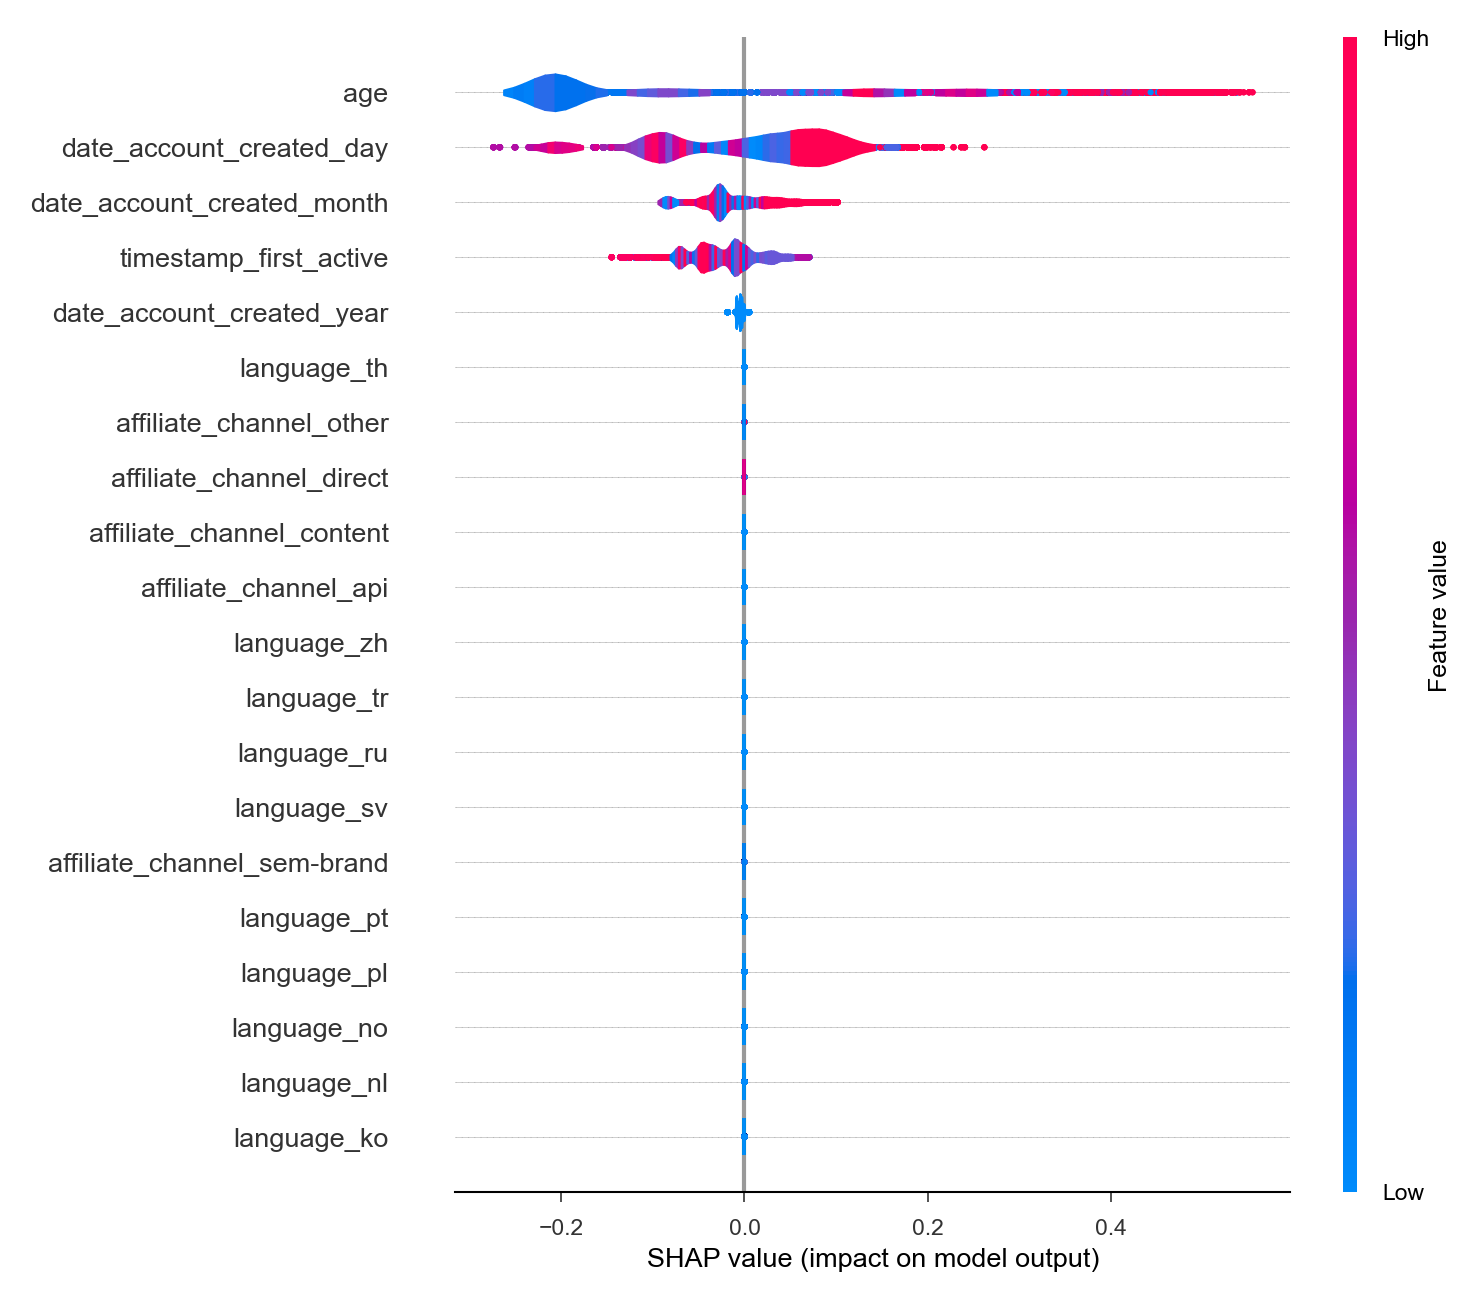

In [36]:
shap.plots.violin(shap_values[:,:,1])
# on the y-axis, features are listed in descending order of importance (with the most influential listed at the top).
# on the x-axis, there is a scale for SHAP values - values that are pulling the model’s prediction lower are to the left and values that are pushing the prediction higher are to the right
# colours differentiate the relative size of the feature values between instances. High values (relative to other instances) are colored red; low values are colored blue


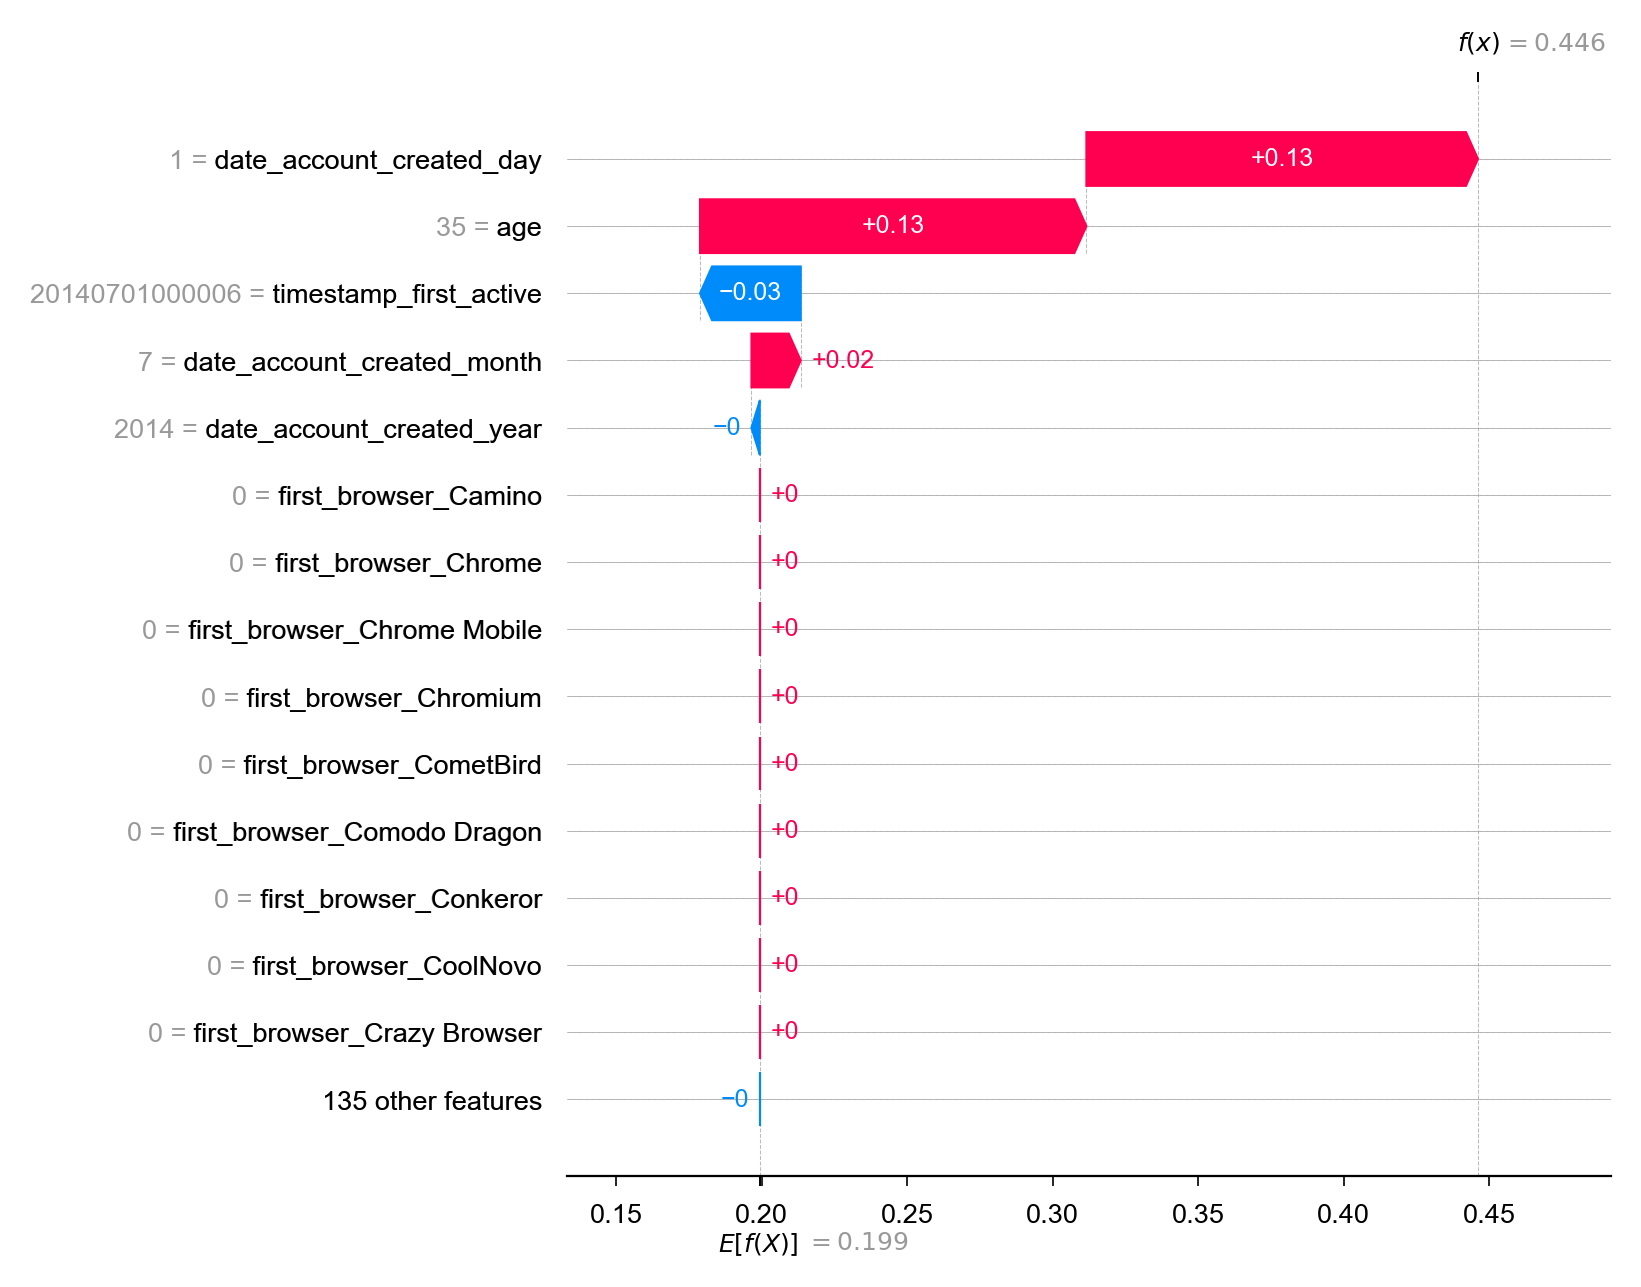

In [37]:
# LOCAL interpretability
# The SHAP waterfall plot is a visualization tool used to explain individual predictions with SHAP values. It breaks down the prediction for a single instance by showing how each feature contributes to the final prediction.
shap.plots.waterfall(shap_values[0,:,1], max_display=15)

**Numeric Interpretation**: SHAP values in waterfall plots are numeric, reflecting contributions to probabilities depending on the classification problem.
**Class Labels**: The numeric result at the end of a waterfall plot provides insight into the probability contributing towards the respective class, which needs conversion to be interpreted as class labels directly.
**Feature Contributions**: The same concept of feature contributions applies irrespective of the type of classification problem.
Understanding SHAP waterfall plots for classification involves recognizing that the plots depict how features influence numeric scores (log-odds or probabilities) that decide the final class prediction. The SHAP library allows converting these contributions into insightful visualizations for deeper model interpretability.